<a id='id_top'></a>
<b><h1>Truel problem analysis</h1></b>
Author: <i>gmnenad</i>
<br><br>

<a id='id_summary'></a>
<b><h2>Summary</h2></b>


* [**Abstract**](#id_abstract)
* [**Problem definition**](#id_problem_def)
* **1. Solutions** - [different ways to solve problem in <i>Python</i>](#id_solutions)
    - 1.1 <i>Simulation</i> - [approximate solutions - easier to make, but limited and slower execution](#id_simulation)
    - 1.2 <i>Mathematical calculation</i> - [exact solutions - more complex but more flexible and faster execution](#id_math_calc)
    - 1.3 <i>Optimal targets</i> search - [select optimal out of all possible targets](#id_optimal_targets)
* **2. Visualizations** - [Python functions that use one of solutions to visually present results for analysis](#id_visualization)
    - 2.1 ptruel    - [to find and print result for given hit probabilities and predefined or optimal targets](#id_ptruel)
    - 2.2 ptruelWhy - [to demonstrate "why" is target list returned in result really 'optimal'](#id_ptruel_why)
    - 2.3 <i>testAB</i>    - [to display results as colored graph image for any hit probability of first two players (A and B) on Y and X axis](#id_testAB)
* **3. Analysis** - [using visualization tools to explore results given different situations and constraints in truel problem](#id_analysis)
    - 3.1 [Comparison between "smart" and "normal" AB methods](#id_cmp_smart_normal)
    - 3.2 [Comparing simulations at different iteration counts](#id_cmp_random)
    - 3.3 [Investigate for three players: A, B and C](#id_investigate_3)
    - 3.4 Original problem - [three players with hit probabilities [ 1/3, 2/3, 1 ], and allowed targets Others/Miss](#id_original_problem)
    - 3.5 MISS target option - [exploring in which scenarios allowing player to Miss changes result, and especially where it changes <i>optimal</i> targets solution](#id_miss)
    - 3.6 Alternative problem - [three players with hit probabilities [ 75%, 55%, 100% ], and allowed targets Others/Miss/Random](#id_alternative_problem)
    - 3.7 RANDOM target option - [where and why it change optimal targets solutions](#id_random)
    - 3.8 SELF target option - [does it ever change optimal targets solutions, and how it influence results with predefined targets](#id_self)
    - 3.9 Four players - [how different options influence four players version of truel](#id_four_players)
    - 3.10 [Selecting optimal targets when multiple targets result in same win probability](#id_same_pwin)
* [**Copyright notice**](#id_copyright)   
<br><br>

<a id='id_abstract'></a>
<b><h2>Abstract</h2></b>

Truel problem is an old problem which can be summarized as : <br>
<font color=blue size=4><b>Several people are doing duel. <br>
    Given their probabilities to hit, what are probability of each of them to win and who should they choose as optimal initial target ?</b></font> <br>

This document presents solutions and analysis of different scenarios for "classical truel" problem - one where players can have different probabilities to hit, shoot sequentially with infinite number of bullets, and where missing is allowed. It contains several novel elements:
* **solving for optimal targets**: solutions that not only find/show win probabilities for predefined targets, but are able to find optimal targets for each player
* **interactive reusable solution**: interactive Python functions for fast solution and visualization, with flexible configurable parameters
* **random choice analysis**: demonstration that "random" target choice can be optimal for some players in certain scenarios
* **four players analysis**: analyze optimal targets in "four players" truel scenarios


Novel part about solution is that it is fast enough to be interactive even for visualization ( where millions of individual pixels/solutions need to be calculated in short time to present AB graph with all possible hit probabilities for players A and B ). That speed was achieved by implementing default solution using mathematical calculations, while still providing option for conventional solution using simulation. Solutions support not only finding win probabilities for players with predefined initial targets, but also finding actual optimal targets - which is another novel element not found in most previous truel related papers. Mathematical solution is around 400 times faster than simulation when solving for predefined targets, and over 2000 times faster when finding optimal targets in truel scenarios. Another novel aspect of the solution is that is support more than three players, both for solutions and for visualization ( AB graphs still show all hit probabilities for players A and B, with fixed but configurable hit probabilities for players C,D... ) - although such variants are not technically "truel". To further improve speed and allow interactivity, Numba accelerated Python functions are used, along with 'smart' optimizations for AB graph that use dynamic interpolation/calculation.

Novel part about truel analysis is that interactive solution was used to demonstrate situations where it is optimal for some players to choose "random" target, as opposed to choosing to target other players or to miss. Document also demonstrate that self targeting is not optimal choice in any situation, and confirms that intentionally missing is optimal choice in large number of cases. While analysis of intentional misses and even self targeting was done previously, it generally lacked proof or demonstration in which situation those options would be optimal choice - because most previous analyses did not solve for optimal targets. 

Code for this document is available at [GitHub repository](https://github.com/gmnenad/Truel), or in  [ZIP file at gmnenad.com](https://gmnenad.com/wp-content/uploads/2021/04/Truel.7z) site  ( which also include precalculated cache file, to save [around 45 min](#id_skipSlow) of initial execution )

<br><br>

<a id='id_problem_def'></a>
<b><h2>Problem definition</h2></b>
This document solves generalized version of truel problem: 

* <i>N players</i>: generalization of fixed three participants in original problem - so technically this may not be "truel", although most of analysis is done for truel version
* Any hit probability: unlike original problem which usually constrains 0 <= pA <= pB <= pC == 1, and especially makes it easier with pC fixed at 100%, this solution must support all possible hit probabilities in [0 .. 1] range for any player
* Optimal targets: in addition to solving for predefined initial targets ( which is easier), this solution must be able to find optimal targets for any or all players - so initial targeting order is part of solution result, in addition to win probabilities
* Target selection: to support different analyses solution should be able to include or exclude different target options, as combination of following:
    - Others:   standard target option, where player can select one among other players as target
    - Miss:     player can intentionally miss (shoot at ground etc)
    - Self:     player can shoot at himself ( suicide option ) 
    - Strongest:  player will shoot at highest threat - one of other remaining players with highest chance to hit 
    - Random:   player can, at each round, randomly select one of available target options to shoot at. This option should honor inclusion/exclusion of Others/Miss/Self/Strongest
 
 
 **Original problem:** <br>
 Three players are doing truel, where each can choose who to try to shoot, then next player plays and so on until only one winner is left. 
 If first player has 1/3 chance to hit, second has 2/3 and last has 100% chance to hit - what is the chance of first player to win and who he should target at start ? ( uses target= Miss )
 
  
 **Alternative problem:** <br>
 If first player has 75% chance to hit, second has 55% and last has 100% chance to hit - what is the chance of first player to win and who he should target at start ? ( uses target= Random )
 
 
 Assumptions for problems:
 - players can have different probabilities to hit
 - players shoot sequentially ( player A, then B, then C ... then again A etc )
 - players have infinite number of bullets 
 - missing is allowed as a potential target ( along with other options as self targeting or random targeting )
 - all players have same allowed targets ( if player A can choose to miss, so can players B and C )
 - all players are capable of finding optimal solution
 - players know which target choice was made by players before them ( for example, each player must announce his target choice on his first round and keep that choice until one player is eliminated )
   
 <br><br>

<a id='id_solutions'></a>
<b><h1>1. Solutions</h1></b>

There are two types of solutions to Truel problem in this document: exact matematical calculation and simulation. Both support solving for win probabilities and for optimal target order, and both support advanced targeting options like Miss, Self or Random targets. Simulation is slower to execute by factor 200-3000x, but even mathematical calculation can be slow for very large number of points ( in 2D graphs ) or very large range of targets ( especially for high random levels).  




While different functions will be used ( simulation, mathematical calculation, AB graphs), they all share certain input parameters - same way to define problem :

**function ( pHits, targets, search, ... )**

Explanation on main shared parameters:
* **pHits**: 
    - list of probabilities for each player to hit ( floats in range 0.0 .. 1.0 )
    - size of pHits list (or array) determines number of players, so for original truel problem it would have pHits=[ 1/3, 2/3, 1 ] 
    
* **targets**: 
    - list of predefined targets that each player will choose to shoot at in initial phase of game ( while no player is eliminated yet )
    - list where each element is one of:  A, B, C ..., Miss, Random, Self, Strongest,   Optimal  ( or alternative complex 1D targets, see below )
    - it should have same number of elements as number of players, and for example targets= [ Miss, C, B ] indicate that player A will intentionally miss, while B and C shoot each other
    - default empty list means Optimal for all players
    - valid targets for each player are those that are either specific single target (A,B,C,.., Miss), can be resolved to single target (Self, Strongest) or are able to find single target (Random, Optimal) among 'Search' options
    - if 'Random' is selected it has equal chance to select any target from 'search' list ( ignoring 'Random' option if in 'search' list ). If 'Miss' is also in search option, it has same chance as any player
    - if 'Optimal' is selected as target for any player, solution should **find optimal target** for that player ( among options allowed by 'search' list ) that will maximize players win probability
    - both Optimal and Random will use 'search' parameter to determine which targets are eligible/valid for selection
    - **Alternative** way to specify target for one player is to specify exact 'Random' distribution in list of N floats (probabilities that player would select each player as target) instead of single integer constant. So for example:
        - [ 1, 0, 0 ] is equivalent to 'A' ( player will target A with 1.0 probability, ie always). It is also equivalent to 'Self' if used by player A or 'Strongest' if used by B and player A is strongest etc
        - [ 0, 0, 0 ] is equivalent to 'Miss' - player will not select any target
        - [ 0.5, 0, 0.5 ] is equivalent to 'Random' if used by player B with search=[Other] - it will equally choose among A and C as targets ( each with 50% chance)
        - [ 0, 1/3, 1/3 ] is equivalent to 'Random' if used by player A with search=[Other, Miss] -  it will equally choose among B and C as targets ( each with 1/3 chance) and remaining chance is Miss (also equal to 1/3)
        - [ 1/4, 1/4, 1/4 ] is equivalent to 'Random' if used by any player with search=[Other, Miss, Self ] -  it will equally choose among A,B,C,Miss as targets ( each with 1/4 chance)
    - Alternative 1D targets ( list with N floats) allow for combinations that can not be expressed with simple 0D targets ( single integer ). For example:
        - [ 0, 30%, 70% ] is not equivalent to any simple target - here target will be randomly selected as B in 30% of cases and C in 70% of cases
        - [ 1/4, 0, 1/4 ] is also not equivalent to any simple target - here target will be randomly selected among A and C with equal chance, but only 25% chance each while there is 50% chance to select Miss 
    - Since **targets** parameter is list of preferred targets for each player, when each player use complex target it becomes list of lists. It is also possible to mix simple and complex targets:
        - targets= [ [0,0,0] , [0.5,0,0.5], [0,1,0] ] is equivalent to targets=[ Miss, Random, B ]
        - targets= [ Optimal, [30%,0,70%], B ] is mixed use of simple and complex targets ( where B has uneven random selection among A and C as targets)
    - 'Optimal' is only simple (single integer) target that can not be expressed as complex 1D target - since it is hint to solver to actually find best target for that player among all allowed with 'search' option
    - this parameter is only meaningful in first phase of truel, until one of players is eliminated and it turns into simple duel (where players always target each other). 
    - For N=4+ players, after one player is eliminated, solution will use 'targetLater' parameter ( and corresponding searchLater parameter )
       
        
        
* **search**: 
    - list or set of valid targets for optimal search or random selection. 
    - default is search= [ Others, Miss ] , meaning players can target other players or intentionally miss, but can not target themselves or shoot randomly 
    - it uses same constants as those in 'targets' , except 'Optimal' (since this is used to find optimal). In addition, it can use 'Others' - meaning any player except shooter
    - it can only accept integer target constants, not alternative 1D list targets - since it must work for reduced number of players too. But 'Random' as simple int constant is valid search option
    - for 3 player truel, this parameter is not used unless 'targets' list contains Optimal or Random. But for 4+ players it can be used anyway, after player is eliminated - see 'Optimal search' section
    
    
* these are only most important parameters. Full list of parameters can be seen in [definition of Test parameters](#id_visualization) , specifically "fields related to calculating solution".





<h3>Possible target choices</h3>

Options when defining predefined targets or possible targets in optimal searches. Each constant is usable by tg.Name, or directly by name. There are three places where these constants are applicable:  
* predefined '**targets**' : what targets will each player select in initial phase of game. It can be single specific player ( A, C ...), option that evaluate to single choice ( Self, Strongest, Miss ) or group choice ( Random, Optimal ).  It can not be Others, since it must be reducible to single target.<br>This is array of values, where each value define initial target for that player. So targets = [ Miss, C, Optimal ] means that initially player A will miss, player B will shoot player C, and player C will find optimal target for himself.
* '**search**' options : what targets are eligible when player is searching optimal target or shooting random target. Unlike for 'targets', it can be Others - since it define set of options. But it can not be Optimal , since it is used to find optimal.<br>This is basically set of values, that together define valid targets for all players. It can be represented as set or array, so search = { Others, Miss } = [ tg.Others, tg.Miss] means that when players look for optimal target , they can choose among other players or to miss.

* **result** 'targets' : part of solution result, it shows optimal targets as found by solution ( or passed predefined targets if no optimal option was present ). It can have same values as predefined target, except Optimal - whole idea of solution is to find what was that 'optimal' target and to replace it with best target for given player.<br>
This is array of values, where each value represent either predefined or optimal initial target for that player. So result targets = [ Miss, C, B ] for example predefined targets = [ Miss, C, Optimal ] means that solution kept supplied [ Miss, C, -] targets for A and B, and found that optimal initial target for C is 'B'


Constants defining possible targets are listed below. They could be used as members of **tg** class, or as direct variables ( so tg.Miss == Miss , tg.Optimal==Optimal, etc ) :

In [75]:
from enum import IntEnum



# predefining constants to use as target types
class tg(IntEnum):
    # target options
    A=0           # to allow use of [ tg.A ,..] instead of [ 0 ,.. ]
    B=1         
    C=2
    D=3
    E=4
    F=5
    G=6           # for players above 6, just use integer constants
    Miss= -1      # choose to intentionally miss or hit ground as target
    Random=-2     # randomly select target with equal chance out of all 'search' candidates except Random itself
    Self=-3       # allow self shooting (suicide attempt) as valid target
    Strongest=-4  # choose one of other remaining players who has highest chance to hit as target
    Others=-5     # all other players are included in random/optimal search (can NOT be in 'target' parameter, only in 'search')
    Optimal=-10   # find who is optimal target for this player (can NOT be in 'search' parameter, only in 'target')
    Invalid=-11 # internally used, do not pass in parameters

    # truel calculating algorithms
    math=21    # calculation type for truel:  math= mathematical calculation
    sim=25     # calculation type for truel:  sim = simulation of the result
    fake=29    # fake calculation, randomly return win probabilities ( for tests )
    
    # preCalc cache options
    cNone = 0   # do not use  :  it will always calculate and will not write to cache
    cUse = 1    # use cache   :  (default)  load from cache if exists, otherwise calculate and write to cache after calculated
    cUpdate = 2 # update      :  do not read from cache, but after calculation write to cache - thus updating cache
    cReadOnly = 3  # read only : must read from cache, never calculate. If not in cache, return empty matrix

    # internal options used in numba ( those used in normal code are in tg_ )
    skip2players = 1 # set 0 to force calculation even for 2 players
    
    

Functions to sanitize and print hits, targets and search parameters:

In [76]:
import numpy as np  
import numba 



# internal target types
class tg_:
    defaultSearch=np.array([tg.Miss, tg.Others] ,dtype=np.int32)  # by default, valid optimal or random targets are all other players and intentional miss
    defaultSearchLater=np.array([] ,dtype=np.int32)         # by default, search in later phases is same as in initial phase
    defaultTargets=np.array([],dtype=np.int32)              # default targets are not predeterminated, will search for optimal ( will expand to N*Optimal once N is known )    
    defaultTargetLater= tg.Optimal                          # default target to be used by all players after player number is reduced
    defaultAlg=tg.math                                      # default algorithm for truel calculation, among: math, sim
    defaultIterations=1000000                               # default number of iterations in each truel simulation, if alg==sim
    defaultRndLevel= None                                   # default random variations to try. None= just try even split on all targets (-1 -1 -1).  
    defaultRndLevelLater= -1                                # default random variations in later phase. -1 = just try even split on all targets.  
    All= [tg.Others, tg.Self, tg.Miss, tg.Random] # all possible target search options. It can be used directly (search=tg.All) or indirectly (search=[tg.All])
    allKnownOptions=[tg.Miss,tg.Self,tg.Strongest,tg.Random,tg.Optimal,tg.Others]
    maxSimSize=300        # to prevent accidental 300x300 simulations, which would take lot of time
    ShowTimes= True      # is time measured for individual functions

# user constants, to allow easier parameters. 
# WARNING : may be rewritten if variables A,B,C used ! Safer to use tg.A etc
A=tg.A 
B=tg.B
C=tg.C
D=tg.D
Miss=tg.Miss
Random=tg.Random
Self=tg.Self
Strongest=tg.Strongest
Optimal=tg.Optimal
Others=tg.Others
# truel calculating algorithms
algFake=tg.fake
algSim=tg.sim
algMath=tg.math
# preCalc cache options
cNone = tg.cNone  
cUse = tg.cUse   
cUpdate = tg.cUpdate
cReadOnly = tg.cReadOnly  


# convert targets to 2D numpy array, and expand them to Optimal for all 'n' players if they were empty (default for unknown number of players)
# called only single time by top level user functions ( those that have default options ) to initially sanitize input, since it can not be numba ( due to taking lists and arrays as inputs )
def npTargets(targets, n):
    if type(targets) is set:
        print("Targets can not be set {} ! It must be list or array, where each position define target for that player. Converted to defaultTargets ")
        targets=[]
    if (len(targets)>0) and (len(targets)!=n):
        print(f"Targets size {len(targets)} is different from number of players {n} !  Converted to defaultTargets ")
        targets=[]
    if len(targets) == 0:
        ntargets= np.full(n, tg.Optimal, dtype= np.int32)
    else:
        # convert to list , then to np.array of type int32
        ntargets= np.array( list(targets), dtype=np.int32)
    # test for invalid values
    for i in range(len(ntargets)):
        t=ntargets[i]
        if t==tg.Others:
            print (f"target for player {i} can not be Others ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
        elif t>=n:
            print(f"target for player {i} is {t}, which is larger than number of player {n} ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
        elif (t<0) and not( t in tg_.allKnownOptions):
            print (f"target for player {i} is {t}, which is unknown option ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
    # return as numpy array
    return ntargets


# convert search set or list to numpy array
# called only single time by top level user functions ( those that have default options ) to initially sanitize input, since it can not be numba ( due to taking both sets or arrays as inputs )
def npSearch(search, allowPlayers=False):
    # flatten elements of list, if it was set inside list like [ {All}, Miss]
    sSearch= npFlatSet(search)
    # test for invalid cases
    if tg.Optimal in sSearch:
        print (f"search set can not contain Optimal ! Removed. ")
        sSearch.discard(tg.Optimal)
    sRes= sSearch.copy()
    for x in sSearch:
        if x>=0:
            if not(allowPlayers):
                print(f"search set can not contain specific players, since they may be eliminated during game ! Removed player {x} from set. ")
                sRes.discard(x)
        elif not(x in tg_.allKnownOptions):
            print(f"search set contains unknown target option {x} ! ! Removed. ")
            sRes.discard(x)
    # convert to nparray
    nSearch= np.array(list(sRes),dtype=np.int32)
    return nSearch


# convert optRndLevel to numpy array, and expand them to -1 for all 'n' players if they were None or empty (default for unknown number of players)
def npOptRndLevel(optRndLevel, n):
    if (optRndLevel is None) or (len(optRndLevel) != n):
        optRndLevel = np.full(n,tg_.defaultRndLevelLater , dtype=np.int32)
    else:
        optRndLevel = np.array(optRndLevel, dtype=np.int32)
    return optRndLevel

# flatten nested lists, convert sets to lists etc
def npFlatSet( search ):
    # convert to list first, if it was set like { Others, Miss }
    if not( type(search) is list):
        try: # if element is set or array, or any other iterable, convert to list
            search=list(search)
        except: # if element was single value
            search=[search]
    # flatten elements of list, if it was set inside list like [ {All}, Miss]
    sSearch= set()
    for x in search:
        try: # if element is set or sub list, flatten
            sSearch.update(x)
        except: # if element was single value, add
            sSearch.add(x)
    # return set
    return sSearch




# convert single target integer to single character
def targetChar(target, search=tg_.defaultSearch, rndVec=True):
    if hasattr(target, "__len__"):
        # vector
        return targetToStr(target, search=search, rndVec=rndVec)
    else:
        # single number
        target= int(target)
        if target>=0 :
            return chr(ord('A')+target)
        if target==tg.Optimal :
            return 'b'
        if target==tg.Invalid :
            return 'i'
        tNames=['o','h','s','r','m']
        # Other, Strongest, Self, Random, Miss
        if (target>=-5) and (target<0):
            return tNames[target+5]
        return '?'
    
# convert targets array or list to string
def targetsStr(targets, search=tg_.defaultSearch, rndVec=True, brackets=True):
    res="[ " if brackets else ""
    for i in range(len(targets)):
        res += targetChar(targets[i])+" "
    res +="]" if brackets else ""
    return res

# convert search array or list or set to string, alllows nested list in list
def searchStr(search, brackets=True):
    search= npFlatSet( search )
    res="[ " if brackets else ""
    for x in search:
        res += targetChar(x)+" "
    res +="]" if brackets else ""
    return res


# convert probability array to string
def probStr(probs, brackets=True, perc=True, decimals=3):
    res="[" if brackets else ""
    fd="{:6."+ ( str(decimals-2) if perc else str(decimals) ) +"f}"
    for i in range(len(probs)):
        p= probs[i]
        if perc:
            res+= fd.format(p*100)+"%"
        else:
            res+= fd.format(p)
    res +=" ]" if brackets else ""
    return res


# convert 1D target of player 'p' to string
# A,B,C... m= Miss, R = standard random evenly across all valid targets (including Miss if in search), Rmb = evenly across b and miss ( or Rab etc ), r = uneven random
# if rndVec=True ( default) , uneven random is displayed as r[0.16 0.66 0]
def targetToStr(trg, search=tg_.defaultSearch, rndVec=True):
    n=len(trg)
    eps=1e-8
    def iseq(a,b):
        return abs(a-b)<eps
    # if sum is over 1, or any value under 0, return invalid
    sm= np.sum(trg)
    if sm>1+eps:
        return 'r>1?'
    for i in range(n):
        if trg[i]<0:
            return 'r-?'
    # if miss
    if iseq(sm,0):
        return 'm'
    # if specific target 
    for i in range(n):
        if iseq(trg[i],1): 
            return chr(ord('A')+i)
    # otherwise it is random. Recognize if standard random 'R' or mixed random 'r'
    # count all !=0 values, and test if all are equal
    allSame= True
    numSame=0
    sameVal=-1.0
    included=""
    for i in range(n):
        x=trg[i]
        if not( iseq(x,0) ):
            included+=chr(ord('a')+i)
            numSame += 1
            if sameVal < 0:
                sameVal= x
            elif not( iseq (x, sameVal) ):
                allSame= False
    # if sum is not 100%, miss=1-sm , and it also need to be same
    if sm<1-eps :
        included+='m'
        numSame += 1
        if not( iseq( 1-sm , sameVal )):
            allSame= False 
    # count all alternatives, including miss
    nat=0
    if tg.Others in search:
        nat+= n-1
    if tg.Self in search:
        nat +=1
    if tg.Miss in search:
        nat +=1
    
    # determine type of random distribution
    if allSame:
        # even distribution, check if aacross all valid
        if numSame == nat :
            return 'R'
        else:
            # show who is included in even distribution
            return 'R'+included
    else:
        # uneven distribution
        if rndVec:
            res=""
            for x in trg:
                rs="{:.2f}".format(x)
                res+= (" " if res !="" else "") + ( rs[1:] if rs.startswith("0.") else rs )
            return "r["+ res +"]"
        else:
            return 'r'
    


# convert 1D target to tg.int, assume it is valid
# -2=  any random, -1= Miss, 0,1,2..= A,B,C...
@numba.njit
def targetToInt(target):
    # if miss
    if np.sum(target) == 0:
        return np.int32(tg.Miss)
    # if specific target 
    for i in range(len(target)):
        if target[i]==1: 
            return np.int32(i)
    # otherwise it is random
    return np.int32(tg.Random)

# convert 2D targets ( n x n ) with random distributions to simple 1 D [ m A C ] format
@numba.njit
def targetsTo1D(targets):
    n= len(targets)
    res= np.empty(n, dtype=np.int32)
    for i in range(n):
        res[i]= targetToInt(targets[i])
    return res
  
    
# convert 1D target to simple target
#   similar to targetToInt
#   return tg.Invalid if invalid ( eg. complex random like [0.3 0 0.7], or partial miss like [0.5 0 0 ] )
@numba.njit
def targetToIntCheck(target):
    # if miss
    if np.sum(target) == 0:
        return np.int32(tg.Miss)
    # if not miss and sum!=1 , it is not valid
    if np.sum(target) != 1:
        return np.int32(tg.Invalid)
    # if specific target 
    for i in range(len(target)):
        if target[i]==1: 
            return np.int32(i)
    # otherwise check if equal split random
    tv=0
    for x in target:
        if (x !=tv) and (x!=0) and (tv!=0):
            return np.int32(tg.Invalid)
        if (x!=0) and (tv==0):
            tv=x
    return np.int32(tg.Random)

# convert 2D targets ( n x n ) with random distributions to simple 1 D [ m A C ] format, and check if all are valid simple targets
#  - return tg.Invalid in [0] index if any of targets is not valid simple target
@numba.njit
def targetsTo1DCheck(targets):
    n= len(targets)
    res= np.empty(n, dtype=np.int32)
    for i in range(n):
        r= targetToIntCheck(targets[i])
        res[i]= r
        if r== tg.Invalid:
            res[0]=r
    return res


#********************************************************************************************************************************
#********************************************************************************************************************************


# enumerate all valid target options , based on predefined 'targets' constraints and allowed 'search' options for optimal targets
#  - targets:  list or array with predefined target option for each player. If 'Optimal', then it will be unrolled to all possible combinations. Support partials: [ [0.1,0.2,0.3],Optimal, A]
#  - search:  set or list or array with allowed targets for Optimal search. 
#  - pHits:   probabilities of each player to hit , needed to determine 'Strongest' if present
#  - optRndLevel : how detailed to do optimal search in Random is included in 'search'. Default only check even random selection across all targets
# return 3D array with valid target combinations = [ nValidTargetCombos, n,n ]
def allTargetOptions(pHits, search=tg_.defaultSearch, targets=tg_.defaultTargets, optRndLevel=tg_.defaultRndLevel  ):  
    # sanitize targets and search and covnert to numpy arrays
    ot= createOptTargets(pHits, targets,search, optRndLevel)
    return nb_allTargetOptions( ot)
            
# based on OptTargets,  generate all possible combinations of target options for each player, 3D array valid targets = [ nValidTargets, n,n ]
#  - optTargets= one 2D array per each player, so end result is list of 2D arrays, eg targets=[C, Optimal=A|C|Miss|Random, B] -> optTargets= [ [[0 0 1]], [[1 0 0],[0 0 1],[0 0 0],[0.5 0 0.5]], [0 1 0] ]
# - if optTargets had as above [ C, [A,C,Miss,rndAC],B] , then this make all combinations of 3 targets: [ [C,A,B],[C,C,B],[C,Miss,B],[C,rndAB,B] ], where each single target is not int(A,rndAB..) but 1D array ([1 0 0],[0.5 0 0.5])
# - so final result is 3d numpy array of numCombos x n x n
@numba.jit(nopython=True, nogil=True)
def nb_allTargetOptions(OptTargets ):
    n=len(OptTargets)
    current= np.empty((n,n), dtype=np.float64)
    res=numba.typed.List()
    res.append(current)
    res.pop(0)
    # call recursive, starting with first player
    nb_inner_replaceOptimals(res, current, n, OptTargets, 0) 
    # convert to 3D numpy array
    ar= np.empty((len(res),n,n), dtype=np.float64)
    for i in range(len(res)):
        ar[i]= res[i]
    return ar    


## recursive to make all possible combinations of target options for each player, returning list of valid targets = list of np.float64[n,n]
# - if optTargets had as above [ C, [A,C,Miss,rndAC],B] , then this make all combinations of 3 targets: [ [C,A,B],[C,C,B],[C,Miss,B],[C,rndAB,B] ], where each single target is not int(A,rndAB..) but 1D array ([1 0 0],[0.5 0 0.5])
# - so final result is list of numCombos x n x n
@numba.jit(nopython=True, nogil=True)
def nb_inner_replaceOptimals(res, current, n, ot, p):
    # if after last player, insert into results
    if p>=n:
        res.append(current.copy())
        return
    # otherwise iterate all options for this player 'p'
    for x in ot[p]:
        current[p]=x
        nb_inner_replaceOptimals(res, current, n, ot, p+1)

        
def selectOptimalResult( allResults , pHit, ifEQ= +1, legend=False):
    # determine number of players and potential targets. allResults= ( nRes, n+2, n )
    N= len(allResults)
    if N==0:
        return
    ph= np.array(pHit, dtype=np.float64)
    n= len(allResults[0,0])
    # string list to store explanatory comments
    if legend:
        guide= np.empty(N,dtype='object')
        for i in range(N):
            guide[i]=''
    
    ### recursive function for specific player to return best target for himself, given previously selected targets
    #  - player: current player that needs to decide
    #  - targetsSoFar : selected targets by previous players from full [n,n] so only [0:player, n ] is set
    # returns index in allResults that he would choose, and annotate 'guide'
    def minmax(player, targetsSoFar):
        # find cip= all combos that are still in play = all that start same as targetsSoFar[0:player]
        preMask=allResults[:,2:2+player,:]== targetsSoFar[0:player]
        mask= np.all( preMask , axis=(1,2)) 
        cip= np.where(mask)[0] # indices of rows that satisfy condition
        if len(cip)==0:
            # no row satisfy condition, this should be invalid situation!
            return -1
        elif len(cip)==1:
            # only one row satisfy condition, so this player must plays that. If this is not beyond last player, comment on it
            idx= cip[0]
            if (player<n) and legend :
                guide[idx]+= targetChar(player)+"! "  # ! means player had only this as choice, so no choice actually
            return idx
        # find all unique possible options for player in this case (it may or may not be equal to options for this player in all cases)
        pop= np.unique(allResults[mask][:,2+player,:], axis=0)
        bestP=-1
        idx=-1
        for i in range(len(pop)):
            # call recursively next player to decide what he would choose if this player chose pop[i]
            targetsSoFar[player]= pop[i]
            r= minmax(player+1, targetsSoFar) 
            # is this better option for this player?
            if (r>0):
                p2=allResults[r,0,player]
                if p2 > bestP :
                    # if better win chance, it is always better option
                    bestP=p2
                    idx=r
                elif p2 == bestP:
                    # if same win chance, compare targets
                    tOld= allResults[idx,2+player,:]
                    tNew= allResults[  r,2+player,:]
                    pwOld=allResults[idx,0,:]
                    pwNew=allResults[  r,0,:]
                    # if new target is larger than old, select it ( default ifEQ > 0 ), otherwise select smaller target
                    if nb_cmpRes( ph, tOld,tNew, pwOld,pwNew, ifEQ):
                        bestP=p2
                        idx=r
        # notify in guide which option he would choose
        if legend :
            guide[idx]+= targetChar(player)+"+ "  # + means player had selected this option as best (maximal probability for given previous choices )
        return idx
    
    # call recursive function for first player A
    idx= minmax(0, np.zeros((n,n), dtype=np.float64) )
    # function to print one row
    def prow(ir):
        print(" "+"{0:4}".format(ir+1)+('*' if ir==idx else " ")+" |   " + targetsStr(allResults[ir][2:], brackets=False)+" | "+ probStr(allResults[ir][0],brackets=False) +"    |   "+ guide[ir])
        
    # if legend=True, display all possible options and their comments
    if legend==True:
        print(f"Legend:  * = best result, at #{idx+1}. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ ")
        print()
        print("    #  |  Targets |     win probabilities       |  + = max , ! = only  ")
        print("-------------------------------------------------------------------------------")
        for i in range(N):
            prow(i)
        print("-------------------------------------------------------------------------------")
    # return best solution row
    return allResults[idx]    



# compare if new result is better than old one
# pHit are hit probabilities for all players
# tOld/tNew are old and new targets for this player ( 1D probability distribution)
# pwOld/pwNew are win probabilities for all players
# ifEQ determine how to handle same win probabilities:
#   +1: (default) single target > miss > random, if same prefer to target higher hit prob player
#   +2: always prefer to target higher hit probability player ( so Miss is last )
#   +3: prefer to target player with highest win chance
#   neg/other: (old)  single player > random > miss, if same A>B>C...
@numba.jit(nopython=True, nogil=True)
def nb_cmpRes( pHit, tOld, tNew , pwOld, pwNew, ifEQ):
    isBetter=False
    # new default logic ( simpler is better )
    if ifEQ==+1: 
        t1m=np.max(tOld)
        t2m=np.max(tNew)
        if (t2m==1) and (t1m==1): # if both targets are 'simple' player targets, select one where target is better shot
            isBetter= np.sum(tNew*pHit)>np.sum(tOld*pHit)
        elif (t2m==1) and (t1m<1):  # if new target is single player, it is better ('simpler') than missing or targeting randoms
            isBetter=True  
        elif (t2m<1) and (t1m==1): # same for old target
            isBetter=False
        elif (t2m==0) and (t1m>0): # if new target is Miss, and old one is Random, select new one (simpler)
            isBetter=True  
        elif (t1m==0) and (t2m>0): # same for old target, Miss is better
            isBetter=False
        else:  # if both are random targets, select one where better shots are targeted most
            isBetter=  np.sum(tNew*pHit)>np.sum(tOld*pHit)
    # targeting better shots is always better, so Miss always last, but Random can sometimes be before single targets
    elif ifEQ==+2: 
        isBetter=  np.sum(tNew*pHit)>np.sum(tOld*pHit)
    # prefer to target player with highest win chance
    elif ifEQ==+3: 
        isBetter=  np.sum(tNew*pwNew)>np.sum(tOld*pwOld)
    # old logic, single player > random > miss
    else: 
        cmp= np.sign( np.max(tNew)-np.max(tOld) )
        if cmp == 0:
            # if same max ie [1,0,0] or [0,1,0], larger is one who first have higher value
            no=len(pHit)
            for i in range(no):
                cmp = np.sign( tOld[i] -tNew[i])
                if cmp !=0 :
                    break
        isBetter = cmp*ifEQ > 0
    return isBetter



@numba.jit(nopython=True, nogil=True)
def nb_selectOptimalResult( allResults , pHit, ifEQ= +1):
    # determine number of players and potential targets
    N= len(allResults)
    n= len(allResults[0,0])
    # if single result, no need to search for optimal
    if N==1:
        return allResults[0]
    # call recursive function for first player A
    idx= nb_inner_minmax(0, n, N, np.zeros((n,n),dtype=np.float64), allResults, pHit, ifEQ)
    # return best solution row
    return allResults[idx]    


### recursive function for specific player to return best target for himself, given previously selected targets
#  - player: current player that needs to decide
#  - targetsSoFar : selected targets by previous players, so only [0:player-1] is valid
#  - allResults :  ( N, 2, n ) - N results, i-th result probabilities ( n of them ) at a[i,0] and targets at a[i,1]
#  - ifEQ : how to choose if equal probabilities. Default +1 means choose higher target indexes ( so player over Miss/Random )
# returns index in allResults that he would choose, and annotate 'guide'
@numba.jit(nopython=True, nogil=True)
def nb_inner_minmax(player, n, N, targetsSoFar, allResults, pHit, ifEQ):
    # mask= true for all combos that are still in play = all that start same as targetsSoFar[0:player] 
    # mask= np.all( allResults[:,1,0:player]== targetsSoFar[0:player] , axis=1)  - axis NOT supported in numba
    # preMask=allResults[:,2:2+player,:]== targetsSoFar[0:player]
    # mask= np.all( preMask , axis=(1,2))
    mask = np.zeros(N, dtype=numba.boolean)
    for i in range(N):
        sameStart= True
        for p in range(player):
            for u in range(n):
                if targetsSoFar[p,u] != allResults[i,2+p,u]:
                    sameStart=False
                    break
        mask[i]= sameStart
    # cip= indexes of all combos that are still in play = all that start same as targetsSoFar[0:player]
    cip= np.where(mask)[0] # indices of rows that satisfy condition
    if len(cip)==0:
        # no row satisfy condition, this should be invalid situation!
        return -1
    elif len(cip)==1:
        # only one row satisfy condition, so this player must plays that. If this is not beyond last player, comment on it
        idx= cip[0]
        return idx
    # find all unique possible options for player in this case (it may or may not be equal to options for this player in all cases)
    arPlayerOptions= allResults[mask][:,2+player,:]
    pop= nb_unique(arPlayerOptions,n)   # np.unique(arPlayerOptions, axis=0)
    bestP=-1
    idx=-1
    for i in range(len(pop)):
        # call recursively next player to decide what he would choose if this player chose pop[i]
        targetsSoFar[player]= pop[i]
        r= nb_inner_minmax(player+1, n,N, targetsSoFar, allResults, pHit, ifEQ) 
        # is this better option for this player?
        if (r>0):
            p2=allResults[r,0,player]
            if p2 > bestP :
                # if better win chance, it is always better option
                bestP=p2
                idx=r
            elif p2 == bestP:
                # if same win chance, compare targets
                tOld= allResults[idx,2+player,:]
                tNew= allResults[  r,2+player,:]
                pwOld=allResults[idx,0,:]
                pwNew=allResults[  r,0,:]
                if nb_cmpRes( pHit, tOld,tNew, pwOld,pwNew, ifEQ):
                    bestP=p2
                    idx=r
    return idx


# since numba does not support axis in np.unique(allResults[mask][:,2+player,:], axis=0)
# input is [ [1,2,3], [4,5,6],... ] 
@numba.jit(nopython=True, nogil=True)
def nb_unique(arr,n):
    res=[]
    # is 1D array 'a' in 'res' ?
    def inRes(a):
        for x in res:
            same=True
            for i in range(n):
                if x[i] != a[i]:
                    same= False
                    break
            if same :
                return True
        return False
    # insert elements if not already there
    for r in arr:
        if not(inRes(r)):
            res.append(r)
    # return unique list
    return res













#********************************************************************************************************************************
#********************************************************************************************************************************





# inner recursive function for nb_enumSums, extracted outside for numba
@numba.njit
def nb_enumSumsInner( res,ar,exact, sumLeft, pos):
    # if last one, finalize and insert
    if pos == 0:
        start= sumLeft if exact else 0
        for ms in range(start,sumLeft+1):
            ar[pos]=ms
            res.append(ar.copy())
    else:
        # otherwise enumerate all and call recursion
        for ms in range(sumLeft+1):
            ar[pos]=ms
            nb_enumSumsInner( res, ar,exact, sumLeft-ms, pos-1)

# enumerate all possible vectors that sum up to certain integer value N
#   - n : size of vector
#   - sumValue: up to which value vector elements can sum
#   - exact : if True, sum(res)== sumValue, otherwise sum(res)<= sumValue
# uncallable from numba, due to list return. Replicate its code and call directly nb_enumSumsInner
#@numba.jit('ListType[float64[::1]] ( int32, int32, bool )', nopython=True, nogil=True )
#@numba.njit
def nb_enumSums(n, sumValue, exact):
    res=numba.typed.List()
    ar= np.zeros(n, dtype=np.float64)
    res.append(ar)
    res.pop(0)
    # call recursive
    nb_enumSumsInner(res, ar,exact, sumValue, n-1)
    return res





# generate optTargets for ALL N,N-1,N-2... players :
# Returns:  List [ List [ 2D np.array((num_target_options, no), float64) ]] with valid pTarget distribution for every player
#  1) topmost list contain elements for each combination of surviving players, 0=none left, 1= just player A, 7=ABC ... and elements for <=2 players can be empty (not used)
#  2) element for specific live players is also list, where each element is 2D array with valid target options for that player
#  3) innermost 2D array contain one row for each valid target of that player, each row has N elements with probability to choose/shoot each of N players
#  eg targets=[C, Optimal=A|C|Miss|Random, B] -> optTargetsABC= [ [[0 0 1]], [[1 0 0],[0 0 1],[0 0 0],[0.5 0 0.5]], [0 1 0] ]
def createOptTargetsALL(pHits, targets,search, targetLater, searchLater, optRndLevel):
    no= len(pHits)
    ph=np.array(pHits)
    nSearchLater= npSearch(searchLater) if len(searchLater)>0 else npSearch(search)        
    nTargetLater= np.int32(targetLater)
    # check if random levels ( granularity for optimal search that involves Random ) are supplied or need to be set to default
    if not (optRndLevel):
        optRndLevel32 = np.full(no,-1, np.int32)
    else:
        optRndLevel32 =  np.int32(optRndLevel)
    # solution is List of Lists
    optTargetsRed= numba.typed.List()
    #optTargets0= numba.typed.List()
    #optTargets0.append( np.empty((1,no), dtype=np.float64) ) #initial case with no players, empty 2D 
    #optTargetsRed.append(optTargets0)
    # insert target options for all cases with eliminated players
    for alive in range((1<<no)-1):
        ra= createOptTargetsLater(alive, ph, nTargetLater, nSearchLater, optRndLevel32)
        optTargetsRed.append( ra )
    # finally insert target options when all players are still alive
    optTargetsRed.append( createOptTargets(ph, targets,search, optRndLevel ) )
    # return result
    return optTargetsRed

# used by createOptTargetsALL, for later phase when some players are eliminated
# return optTargetsLater = optTargets for given live players ( alive= bit encoded 0..2^N-1 )
def createOptTargetsLater(alive, pHits, target,search, optRndLevel):
    no= len(pHits)
    n=bin(alive).count("1") # number of live players equals 1s in 'alive'
    optTargets1= numba.typed.List() 
    if n>2: # only generate if more than 2 players are alive, otherwise opTargets are not used
        # create list of live players, order is not important
        o=  np.empty(n, dtype=np.int32)
        io=0
        for i in range(no):
            if (alive & (1<<i))!=0:
                o[io]=i
                io+=1
        # convert each players target to 1D if needed, and append to optTargets
        for p in range(no):
            if p in o:
                # convert simple integer target to 2D, with single 1D or multiple if Optimal search needed
                ot= optTargetsPlayer(p,o, target,np.int32(search), pHits, optRndLevel)
            else:
                # for eliminated players just add empty 2D row
                ot= np.zeros((1,no), dtype=np.float64)
            optTargets1.append(ot)
    else:
        optTargets1.append( np.zeros((1,no), dtype=np.float64) )
    # append 2D array of potential player targets to optTargets for all players
    return optTargets1




# generate optTargets for ALL players :
# Returns:  List [ 2D np.array((num_target_options, no), float64) ] with valid pTarget distribution for every player
#  - for each player return either one row (xn) if single target, or mulitple rows for each target, in 2D array. 
#  - one such 2D array per each player, so end result is list of 2D arrays, eg targets=[C, Optimal=A|C|Miss|Random, B] -> optTargets= [ [[0 0 1]], [[1 0 0],[0 0 1],[0 0 0],[0.5 0 0.5]], [0 1 0] ]
def createOptTargets(pHits, targets,search, optRndLevel):
    n= len(pHits)
    ph=np.array(pHits)
    if ( targets is None) or (len(targets) == 0):
        targets= np.full(n, tg.Optimal, dtype= np.int32)    
    o= np.arange(n)
    optTargets= numba.typed.List()
    # check if random levels ( granularity for optimal search that involves Random ) are supplied or need to be set to default
    if not (optRndLevel):
        optRndLevel = np.full(n,-1, np.int32)
    # convert each players target to 1D if needed, and append to optTargets
    for p in range(n):
        x= targets[p]
        if hasattr(x, "__len__"):
            # if it is already 1D list or array  of prob distributions, convert to 2D (1,no)
            ot= np.empty((1,n), dtype=np.float64)
            ot[0]= x
        else:
            # convert simple integer target to 2D, with single 1D or multiple if Optimal search needed
            ot= optTargetsPlayer(p,o, np.int32(x),np.int32(search), ph, np.int32(optRndLevel))
        # append 2D array of potential player targets to optTargets for all players
        optTargets.append(ot)
    return optTargets
    
    
# generate optTargets for one player, given :
# - p:  player, global index in range(no) 
# - o:  which players are still in game, n=len(o) number of players in game, o[i]= global ingex of that player
# - target: simple target (Optimal,Miss,Strongest...), not p vector
# - search: options for targets if Optimal or Random search is needed
# - pHits : hit probabilities for original players, to determine Strongest
# Returns:  2D np.array((num_target_options, no), float64) with each valid pTarget distribution for given player
@numba.njit
def optTargetsPlayer(p,o, target,searchL, pHits, optRndLevel):
    no= len(pHits)
    search = set(searchL)
    atg= numba.typed.List()

    ### inner function that expand search option to specific players - so Self and Strongest become specific players , Miss is retained but Optimal/Random are removed
    def expandSearch(sSet):
        sRes= set()
        if tg.Others in sSet: # if 'other players' are in set, then all from still active players in 'o', except this player 'p'
            for x in o:
                if x != p:
                    sRes.add(np.int32(x))
        if tg.Self in sSet: #if shooting at himself/suicide is allowed, replace with 'p'
            sRes.add(np.int32(p))
        if tg.Strongest in sSet : #if highest threat, find which one of players in 'o' has highest hit chance, beside current player
            hi, hiPHit= (0, 0.0)
            for x in o:
                if x!=p:
                    phi=pHits[x]
                    if phi>=hiPHit:
                        hiPHit=phi
                        hi=x
            sRes.add( np.int32(hi) )
        if tg.Miss in sSet :
            sRes.add( np.int32(tg.Miss) )
        return sRes

    ### inner function that create standard random distribution (equal chances), based on validTargets
    def stdRandom(validTargets):
        nt = np.zeros(no, dtype= np.float64)
        if len(validTargets)>0:
            p1= 1.0/len(validTargets)
            for x in validTargets:
                if x >=0: # Miss is not given any prob
                    nt[x]=p1
        return nt


    if target== tg.Optimal:
        # create list of valid targets to search for optimal target
        validTargets= expandSearch(search)
        rndLevel= optRndLevel[p] # how many different random values per each target. Total combos ~ rndLevel^players^players !!!!
        # if Random is present in search options, and optRndLevel>0, created ranges will include specific targets anyway
        if (tg.Random in search) and (rndLevel>0) :
            exact = not(tg.Miss in validTargets) # if Miss is not allowed, allprobs must sum to 100%
            validTargets.discard(tg.Miss)
            nPos= len(validTargets)
            # create random ranges and convert to probs with sum up to 100%
            #rr= nb_enumSums(nPos, rndLevel, exact )
            rr=numba.typed.List()
            ar= np.zeros(nPos, dtype=np.float64)
            rr.append(ar)
            rr.pop(0)
            nb_enumSumsInner(rr, ar,exact, rndLevel, nPos-1)
            
            # map them to those players who are valid random targets
            rrmap=  np.array(list(validTargets), dtype=np.int32)
            for c in range(len(rr)):
                combo=rr[c]
                nt = np.zeros(no, dtype= np.float64)
                for i in range(nPos):
                    nt[ rrmap[i] ]= combo[i]/rndLevel
                atg.append( nt )
        else:
            # standard optimal options, insert single targets
            for x in validTargets:
                nt = np.zeros(no, dtype= np.float64)
                if x == tg.Miss: # if Miss, leave probs to hit anyone to zero
                    pass
                else: # specific player as target
                    nt[x]=1
                atg.append(nt)
            # standard random search option, to evenly select
            if (tg.Random in search) and ( rndLevel == -1) :
                atg.append( stdRandom(validTargets) )
    elif target== tg.Random:
        # append single random distribution ( evenly across all targets, but still single case )
        validTargets= expandSearch(search)
        atg.append( stdRandom(validTargets) )            
    else:
        # single target
        nt = np.zeros(no, dtype= np.float64)
        if target == tg.Miss: # if Miss, leave probs to hit anyone to zero
            pass
        elif target >= no: # specific player higher than max, invalid case
            pass
        elif target >= 0: # specific player as target
            nt[target]=1
        else:  # if Strongest,Self - convert to actual player
            singleTarget= expandSearch(set([target]))
            if len(singleTarget) >0:
                nt[ list(singleTarget)[0] ]=1
        atg.append(nt)
    # convert list of nparrays to 2D nparray, without using np.array()
    res= np.empty((len(atg),no), dtype=np.float64)
    for i in range(len(atg)):
        res[i]=atg[i]
    return res


<a id='id_skipSlow'></a>
Parameter **SkipSlowParts** allows to skip some initial calculation of few slower sections ( mainly 3.9 "4-player truel" and 3.2 "comparing simulations" ). Initial execution time of entire document is around 45 min, which will also create/populate cache file so that future 'run all cells' will execute in about minute. By default SkipSlowParts will be set to True ( in cell below ), which will result in initial exectution in 10 min instead of 45min - but some graphs will be missing in few sections. After initial run, SkipSlowParts can be set to False and next 'run all cells' will last remaining 35 min. Future 'run all cells' will only last a minute or so (regardless of value in SkipSlowParts), unless AB parameters are changed, since all large calculations will be stored in cache file. Alternative is to set SkipSlowParts=False from start, and wait for longer initial calculation.  

In [77]:
# SkipSlowParts parameter - change to enable/disable recalculation of slow parts
# True  : [default] slowest sections will not be calculated ( but will be used from cache if existing ). Initial run reduced to ~10 min
# False : entire document will be calculated, which on first run can take ~30min ( or ~20 min if first run was done with SkipSlowParts=True )
SkipSlowParts= False

# internal variable, do not change
cacheTypeSlow= cReadOnly if SkipSlowParts else cUse

In [78]:
from datetime import datetime
t0start= datetime.now()
print("Started calculation at ", t0start )

Started calculation at  2021-04-28 23:34:39.809224


<a id='id_simulation'></a>
<h2>1.1 Simulation as approximate solution</h2>

<b>Python function that simulate truel problem for arbitrary number of players, and finds not only winning chances for each player but also optimal targets.<br></b>
<ul>
    <li><i>approximate solution:</i>  returns simulation result, and while it defaults to 1 million rounds, it is still approximation</li>
    <li><i>slow:</i> since it need million rounds on average, single calculation can take 3ms - and search for optimal solution can take 100ms just for 3 players  </li>
    <li><i>find optimal targets:</i> can find optimal targets for each player, with options to allow intentional misses (default), selftargeting, or even random targeting </li>
    <li><i>predefined targets as parameter:</i> also allows specifying fixed targets for some or all players (for initial rounds while all are alive)</li>
</ul>

<br>
    
If we have N players with given targets and hit probabilities for each player, simulate until one player is eliminates, and then:  
* if N was 3, reduction to two players is simple : those two players will always continue to shoot at each other, until one hits and win
* if N was 4+, then simulation need to change player targets (since initial targets may not be valid any more ). Simulation will use 'targetLater' parameter, to determine if next targets should be: Optimal (default), Strongest  

Complexity of solution differs depending on supplied targets:    
* if only specific targets were supplied ( 'Others', 'Self' or even 'Miss' - targets that uniquely determine what to shoot ), then only single simulation ( with default million rounds ) is enough
* if one or more targets are 'Random', it does not change much in simulation - player will use 'search' option to determine who he can randomly target , but execution time remains roughly same
* but if one or more targets are 'Optimal', it increases complexity. Players will again use 'search' option to determine what targets are valid candidates for optimal search. But simulation needs to be run for each valid combination ( up to 125 times slower for 3 players ) 
* same optimal search needs to be done each time when number of players is reduced ( for N-1 players), if our goal is for players to find optimal targets. While for 3 players this is not significant issue, it can exponentially increase optimality search for N=4+ players

    
<i>Finding who to target ( optimal targets ) :</i>
<div style="margin-left: 30px">
Search for optimal targets is needed if any of initial 'targets' was 'Optimal' ( for example targets= [Optimal, C, B], asking solution to find optimal target for player A ; or targets= [Optimal, Optimal, Optimal] to find optimal targets for each player ), or in case of 4+ players when we want to keep searching for optimal targets even when some players are eliminated ( specified in 'targetLater' parameter, which default to 'Optimal' , although other options like 'Strongest' would not require increased time )  
Finding  optimal solution with simulations requires simulating every specific combination of targets ( ie, Random, Miss, A, B, C...). If we have N players, and all possible targets are allowed ie serach=[Others,Self, Random, Miss] , then each player has (N+2) possible targets, and total number of target combinations is:  $ nTargetCombinations =  (N+2)^N $  
For 3 players that amounts to 5^3 = 125 combinations, which all need to be simulated before algorithm for optimality search can be applied ( explained in section 1.3 ). Therefore if we are solving for targets= [Optimal, Optimal, Optimal] , it will take <i>125 times longer</i> execution than if we are solving for specific targets = [ Miss, C, B ] . For 4+ players, that time increases exponentially for optimality search.
</div>    
<br>
There is one <b>limitation</b> for simulation solution : when used for 4+ players, with targets=[Optimal,...] to find optimal targets, it does not propagate optimal search to cases when players are eliminated - instead, it default to targeting 'Strongest' opponent in those reduced cases. For example, when one player in 4-player duel is eliminated and it become 3-player truel, remaining 3 players will not use their true optimal targets. While in many cases targeting 'Strongest' opponent is optimal, it is not always - this mean that mathematical calculation should be used to find optimal targets in 4+ player cases, instead of simulation.
    




**nb_truel_sim**() function calculates win probabilities using simulations. It will select either optimized function for 3 players, or slower generic simulation for N players.  
<br>
<i>Starting parameters:</i>
* pHit: list with probabilities of each starting player to hit  
* targets: list with predefined target for each player  ( default is Optimal for each player )  
* search:  what targets are allowed when searching for optimal/best or random target ( default= tg.Miss | tg.Others )  
* targetLater: what should all players select as target after initial phase (after one player is eliminated, and initial 'targets' become invalid . default= Optimal )
* searchLater: if search options in later phases (when some player was eliminated) should be different than in initial phase    
* ifEQ : how to choose if equal probabilities. Default +1 means choose most 'simple' targets
* iterations : how many simulated rounds before averaging result. Default is 1 million

<i>Result:</i>  
* pw[]: probability of each player to win (given players shoot in pHits order) , array of float64 in [0,1] range
* tw[]: who is their initial target ( 0..n-1 index of player, or tg.Miss or tg.Random  ), array of int32 with target constants (-2,-1,0,1,2.. )


In [79]:
import numpy as np  
import numba  
from numpy import random
from numba import prange
from multiprocessing import cpu_count
import time
import typing







# takes one case version, prepare additional parameters. Assume inputs are right type ( ph is 1d, np.arrays )
# Return 2d float64 array: [ pw[], tw[] ]
@numba.jit(nopython=True, nogil=True)
def nb_truel_sim(n, pHits,   targetLater, searchLater, ifEQ,alg, iterations, optTargets ):
    # enumerate all possible target combos, based on all valid target choices of each player in optTargets ( while all players are alive )
    no=len(pHits)
    allTargetCombos= nb_allTargetOptions( optTargets[(1<<no)-1] )    
    N=len(allTargetCombos)
    # for each possible target combo, simulate result
    ar=np.empty((N,n+2,n), np.float64)
    for i in range(N):
        # simulate required number of iterations for each combination of targets. Call optimized N=3 version if possible
        if (n==3) and (alg==tg.sim) and (iterations>0):
            rw= nb_sim3p(n, pHits, allTargetCombos[i], iterations)
        else:
            rw= nb_simN(n, pHits, allTargetCombos[i], abs(iterations)) 
        # result list has probabilities and targets
        ar[i,0]= rw
        ar[i,1]= targetsTo1D(allTargetCombos[i]) # second row is old format of results ( to be discontinued in future if old algMath is removed and sim also return full nxn targets )
        ar[i,2:]= allTargetCombos[i]
    # find optimal solution among all results
    res= nb_selectOptimalResult( allResults=ar , pHit=pHits, ifEQ=ifEQ)    
    return res



# generic simulation for N players with specified targets with probability, eg targets= [ [0 0 1 ] , [0.5,0,0.5], [0 1 0] ] means [ C, rndAC, B]
@numba.jit(nopython=True, nogil=True)
def nb_simN(n, pHits,   targets, iterations):
    pW= np.zeros(n, dtype=np.float64)
    if (iterations>0) and (np.sum(targets)>0):
        # prepare some common values
        notMiss = np.empty(n, dtype=numba.boolean)
        for p in range(n):
            notMiss[p]= np.sum(targets[p]) > 0
        # repeat many times
        for it in range(iterations):
            # all players are in game at start
            targs= targets.copy()
            inGame=n
            triedHit=n
            stillPlay= np.full(n,True, numba.boolean)
            onMove=-1
            # loop while single player left in game
            while (inGame > 1) and (triedHit > 0):
                # next player
                onMove = (onMove + 1 ) % n
                # if this player is still in game and can hit anyone
                ph=pHits[onMove]
                if stillPlay[onMove] and (notMiss[onMove] or (inGame<n)) and (ph>0):
                    triedHit=n
                    # check if he hits
                    if ph > random.random():
                        # check WHO he hits
                        t=-1
                        rn= random.random()
                        smp=0
                        for p in range(n):
                            smp += targs[onMove,p]
                            if smp>rn:
                                t=p
                                break
                        if t >= 0:
                            stillPlay[t]= False
                            inGame -= 1
                            # TODO: CHANGE TARGETS !! either to Optimal or Strongest or ... currently only Strongest work !!:
                            for player in range(n):
                                targs[player]= np.zeros(n, dtype=np.float64)
                                if stillPlay[player]:
                                    hi, hiPHit= (0, -1)
                                    for p2 in range(n):
                                        if (p2 != player) and stillPlay[p2]:
                                            phi=pHits[p2]
                                            if phi>=hiPHit:
                                                hiPHit=phi
                                                hi=p2
                                    targs[player][hi]=1
                else:
                    # countdown to detect if no player remaining cah hit: all have 0% pHit or all have target= Miss or combination
                    triedHit -= 1
            # find which player remained last ( should be one that last was onMove, but if he was suicide ... )
            if inGame ==1 :
                for i in range(n):
                    if stillPlay[i]:
                        pW[i] += 1
                        break
        pW /= iterations
    return pW




#numba.config.THREADING_LAYER='workqueue' #'omp' 'tbb'
#print("Threading layer chosen: %s" % numba.threading_layer())
# need to use global var, since cant call from numba
nb_cpu_count= int(cpu_count())


# parallel version  of simulation, works only for N=3 truel but 100x (!) faster.  Main speedups :
#   - parallel execution
#   - unrolled tests for each of 3 players
#   - doing second random() only if needed
#   - not simulating 2 player cases (they always shoot each other, so calculate it later based on aggregates)
@numba.jit(nopython=True, parallel=True)
def nb_sim3p(n, pHits,   targets, iterations):
    pW= np.zeros(n, dtype=np.float64)
    # some variables for unrolling
    pA, tA = pHits[0], targetToInt(targets[0])
    pB, tB = pHits[1], targetToInt(targets[1])
    pC, tC = pHits[2], targetToInt(targets[2])
    # test edge cases to prevent infinite loops
    nAbleToHit  = 1  if (tA != tg.Miss) and (pA > 0) else 0
    nAbleToHit += 1  if (tB != tg.Miss) and (pB > 0) else 0
    nAbleToHit += 1  if (tC != tg.Miss) and (pC > 0) else 0
    if nAbleToHit == 0:
        return pW
    # launch several threads to simulate
    threads= max(4, nb_cpu_count)
    ckt= np.zeros((threads,n,n), dtype=np.int64)
    iter2= iterations // threads + 1
    for th in prange(threads):
        for i in prange(iter2):
            # loop while one player hits
            while True:
                if  (tA != tg.Miss) and (pA > random.random())  :
                    if tA== tg.Random :
                        t=-1
                        rn= random.random()
                        smp=0
                        for p in range(n):
                            smp += targets[0,p]
                            if smp>rn:
                                t=p
                                break
                        if t >= 0:
                            ckt[th,0, t ] += 1
                            break
                    else:
                        ckt[th,0, tA]  += 1
                        break
                if  (tB != tg.Miss) and (pB > random.random())  :
                    if tB== tg.Random :
                        t=-1
                        rn= random.random()
                        smp=0
                        for p in range(n):
                            smp += targets[1,p]
                            if smp>rn:
                                t=p
                                break
                        if t >= 0:
                            ckt[th,1, t ] += 1
                            break
                    else:
                        ckt[th,1, tB]  += 1
                        break
                if  (tC != tg.Miss) and (pC > random.random())  :
                    if tC== tg.Random :
                        t=-1
                        rn= random.random()
                        smp=0
                        for p in range(n):
                            smp += targets[2,p]
                            if smp>rn:
                                t=p
                                break
                        if t >= 0:
                            ckt[th,2, t ] += 1
                            break
                    else:
                        ckt[th,2, tC]  += 1
                        break
    # aggregate
    pkt= np.sum(ckt, axis=0, dtype=np.float64)/(threads*iter2)
    # calculate duel probabilities for all combinations of k=player on move and t=targeted/eliminated player
    for k in range(n):
        for t in range(n):
            pc= pkt[k,t] # percentage of times that this combination of players remained
            if pc > 0:
                # first remaining player
                a = (k+1) % n
                if a==t:
                    a = (a+1) % n
                # second remaining player
                b = (a+1) % n
                if b==t:
                    b = (b+1) % n
                # result for remaining players
                pa=pHits[a]
                pb=pHits[b]
                if (pa>0) or (pb>0):
                    p= pa/(1-(1-pa)*(1-pb))
                    pW[a] += p*pc
                    pW[b] += (1-p)*pc
    return pW




<a id='id_math_calc'></a>
<h2>1.2 Mathematical calculation</i> for exact solutions</h2>

<b>Python function that solves truel problem for arbitrary number of players, and finds not only winning chances for each player but also optimal targets.<br></b>
<ul>
    <li><i>exact solution:</i>  returns exact mathematical solution, not approximate simulation result</li>
    <li><i>fast:</i>  computes fast even with 4+ players. It is 400-2000 times faster than simulation for 3 players, and much faster for 4+ players </li>
    <li><i>find optimal targets:</i> can find optimal targets for each player, with options to allow intentional misses (default), self targeting, or even random targeting </li>
    <li><i>predefined targets as parameter:</i> also allows specifying fixed targets for some or all players (for initial rounds while all are alive)</li>
</ul>

<br>
<h>Solution reasoning:</h><br>
<div style="margin-left: 30px">
     if we have N players, with probability of i-th player (0..N-1) in pHit[i], then if i-th player is on move and he is targeting T:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;<b>pwin</b>(i first out of N)= <b>pHit</b>[i]* <b>pwin</b>(i+1 first out of N-1, T is removed ) + (1-<b>pHit</b>[i])* <b>pwin</b>(i+1 first, out of N)<br>
     Assuming we can get exact result for reduced number of players (N-1), we can express solution for N players with i-th player on move as function of solution for (i+1)th player on move:<br>
        &nbsp;&nbsp;&nbsp;&nbsp; <b>pwin</b>(i)= <b>v</b>[]+ k*<b>pwin</b>(i+1)  , where <b>v</b>[]= constant vector with N elements = pHit[i]*pwin(i+1 first out of N-1, T is removed )  , and k= 1-ph[i]  ... so we can express this as tuple pwn=(v[], k)  so that pwin(i)=pwn*pwin(i+1)<br>
    <br><i>Infinite loop:</i>
     <div style="margin-left: 30px">
        Recursively calling pwin(i+1) will eventually get to last player, who will have to rely on first player result calling pwin(0) - which would result in infinite loop<br>
        That infinite loop can be avoided by passing function that express result for win probabilities if initial player is on move as function of win probabilities if (i+1)th player is on move : pwin(0)=pw0=  f( pwin(i+1) ) =  pwn * pwin(i+1) , with pwn= (v[],k ) <br>
        That pw0 can be modified by each successive player, and when we get to last player and he recalculate pw0, he will have pw0= f ( pwin(N+1) ) = f ( pwin(0) ) ... or pw0 = f(pw0 ) which can be solved directly, avoiding infinite loop<br>
        Given pwn=(v[],k) and pw0= pwn*pw0=  v[]+k*pw0 ->   pw0(1-k)= v[] ->  pw0[]= v[]/(1-k)  ... resulting in probability to win for each player, if first to play is initial player <br>
        That exact result for pw0 can be now returned back to exactly calculate pwin(N-1), pwin(N-2)... all way back to pwin(0) which will get same result as pw0.<br>
    </div>
     <i>Finding who to target  ( optimal targets ) :</i>
     <div style="margin-left: 30px">
        above calculation assume that each player knows in advance who is best target for him to shoot at (T).  If he does not know that, he need to apply same calculation to every possible target (including no target) and select one which give him best chance to win<br>
        when 'no target' is selected, his chance to win is slightly different formula:  pwin(i)= pwin(i+1)   - or if we want to present in same format as before ( pwin(i)= v[]+ k*pwin(i+1) ), then v[]=[0,0..0] and k=1, or in tuple for ([0,0...0], 1.0)<br>
       special case is if everyone decide to skip (no target), which would lead to infinite loop, so need to be forbidden in some way. For example - last player is not allowed to skip if everyone else did it.<br>
    </div>
</div>



**nb_truel_math**() function calculates win probabilities using mathematical solution (as opposed to simulations). It will initialize dictionary and check parameters before calling recursive truelC.  
Function **truelC** is main mathematical solution to recursively finds probability to win and optimal targets for each player.  
<br>
<i>Starting parameters:</i>
* pHit: list with probabilities of each starting player to hit  
* targets: list with predefined target for each player  ( default is Optimal for each player )  
* search:  what targets are allowed when searching for optimal/best or random target ( default= tg.Miss | tg.Others )  
* targetLater: what should all players select as target after initial phase (after one player is eliminated, and initial 'targets' become invalid . default= Optimal )
* searchLater: if search options in later phases (when some player was eliminated) should be different than in initial phase    
* ifEQ : how to choose if equal probabilities.  Default +1 means choose most 'simple' targets

<i>Result:</i>  
* pw[]: probability of each player to win (given players shoot in pHits order) , array of float64 in [0,1] range
* tw[]: who is their initial target ( 0..n-1 index of player, or tg.Miss or tg.Random  ), array of int32 with target constants (-2,-1,0,1,2.. )


In [80]:


# new math calculation, can handle complex random distributions - all possible target combos are in optTargets
    
    
# takes one case version, prepare additional parameters. Assume inputs are right type ( ph is 1d, np.arrays )
# Return 2d float64 array: [n+1,n]  =  [ pw[], tpA[], tpB[],..tpN[]  ]
# result is (n+1) tuples of (n): first (0,n) for win probabilities , and other (1:n+1,n) for targets
@numba.jit(nopython=True, nogil=True)
def nb_truel_mathR(n, pHits,     targetLater, searchLater, ifEQ, optTargets):
    # they shoot initially in order [0,1,2,...]
    o= np.arange(n , dtype=np.int32) 
    # initial solution vector
    pw0= ( np.zeros(n), 1)
    # max size of dictionary
    dMax=(n+1)**(n+1)
    # create cache dictionary
    dicValid= np.zeros(dMax,dtype=np.uint8)
    dicPW= np.empty((dMax,n),dtype=np.float64)
    dicTW= np.empty((dMax,n,n),dtype=np.float64)
    # call recursive truelC to really calculate results 
    bestPW, bestTW = truelCR(pHit=pHits,  target=targetLater,search=searchLater,   o=o,c=n,pw0=pw0,ifEQ=ifEQ,   dicValid=dicValid,dicPW=dicPW,dicTW=dicTW,  optTargets=optTargets)
    # cast result from tuple ( float64[], int32[] ) to single type array(2d,float64)
    res = np.empty((n+2,n), dtype=np.float64)
    res[0,:]= bestPW  # first row are probabilities
    res[1,:]= targetsTo1D(bestTW) # second row is old format of results ( to be discontinued in future if old algMath is removed and sim also return full nxn targets )
    res[2:,:]= bestTW  # full (n,n) result targets
    return res
    
    

# Standard parameters:
#    pHit: array with probabilities of each starting player to hit. ph=[0.3,0.2,0.1,1] means there are 4 players initially
#    target: ( targetLater, single target option like Optimal or Strongest )  what to target, used only if optTargets not supplied.
#    search: ( searchLater ) what targets are allowed when searching for optimal or random targets. Used only if optTargets not supplied.
#    optTargets: target options - all allowed target combinations, for each player, in full target format (rnd prob to shoot each)

# Recursive parameters
#    o :  list of remaining players in order of shooting. Players are integer values,  A=0, B=1 ...
#    c :  number of remaining players to process before closing loop back to original player
#    pw0 : solution vector for win probabilities if initial player goes first, modified by all previous players
#    ifEQ : how to decide if equal probabilities for different targets

# Dictionary parameters
#    dicValid :  boolean array (uint8), with dicValid[key]==True if that value was already set/calculated. Key= order of shooting
#    dicPW :     array of [float32] arrays, with win probabilities for each player for each target combo. So for 3 players dicPw=[[0.1,0.7,0.2],[0.5,0.5,0.0],[...]] 
#    dicTW :     array of [int32] arrays, with all combos of selected targets for each player. So for 3 players dicTW=[[1,2,0],[0,2,-1],[...]]     
    
# result is (n+1) tuples of (n): first (0,n) for win probabilities , and other (1:n+1,n) for targets
# in('Tuple([float64[:], int32[:]]) ( float64[:], int32[:], int64, Tuple([ float64[:], int64 ]), int32[:], int32[:], int32[:],  uint8[:],float64[:,:],int32[:,:] )', nopython=True, nogil=True )
@numba.jit(nopython=True, nogil=True, fastmath=True)
def truelCR(pHit,   target,search,   o,c,pw0,ifEQ,   dicValid,dicPW,dicTW, optTargets ):
    # array lengths
    no=len(pHit) # starting number of players - results always have this many elements regardles of len(o)
    n=len(o) # number of players remaining in game
    m=o[0] # m= index of player on move 

    # check edge cases with single player, before cache
    if n<=1:
        bestPW=np.zeros(no, dtype=np.float64)
        bestTW=np.zeros((no,no), dtype=np.float64)
        if n==1: 
            # for n==1 , only player has 100% chance to win, and will target noone
            bestPW[m]=1.0 
        # for n==0 leave all zero chances to win
        return (bestPW, bestTW)

    # check cache 
    key= np.int64(0)
    for i in range(n):
        key= key*(no+1) + o[i]+1
    if dicValid[key]>0:
        cPW,cTW= (dicPW[key], dicTW[key])
        return ( dicPW[key], dicTW[key] )

    bestPW=np.zeros(no, dtype=np.float64)
    bestTW=np.zeros((no,no), dtype=np.float64)
    # check n=2 players edge case AFTER cache, so it can be inserted in cache
    if (n==2) and (tg.skip2players !=0): 
        # directly calculate. Stopping at n==2 is purely due to performance, since algorithm can terminate at n==1
        m2=o[1]
        p1=pHit[m]
        p2=pHit[m2]
        if (p1>0) or (p2>0):
            p= p1/(1-(1-p1)*(1-p2))
            bestPW[m]=p
            bestPW[m2]=1-p
        bestTW[m,m2]=1
        bestTW[m2,m]=1
    else:
    
        # make new order where next player goes first
        o2=np.append(o[1:], o[0])
        
        # calculate reduced target coefs for each potentially eliminated target of first player, so they can be reused by compositeReducedCoefs
        phm= pHit[m] # probability of player on move to hit
        vsList= np.empty((n,no), dtype= np.float64)
        for i in range(n):
            # make reduced player list (without player 'i'), starting with next player ( so remove i-1 )
            o2r= np.delete(o2,i-1)
            # probabilities to win if o[0] hits o[i] - reduction to one less player.  
            pwM,_=truelCR(pHit,    target=target, search=search,   o=o2r,c=n-1, pw0=( np.zeros(no), 1),ifEQ=ifEQ,    dicValid=dicValid,dicPW=dicPW,dicTW=dicTW,  optTargets= optTargets) # recursive call with n-1 players
            vsList[i,:]=phm*pwM
        

        #### inner function that calculate win probabilities (pw, tw, valid), given chances to select targets in 'trg'
        # calculate win probabilities if player *miss* his target, then combine with supplied reduction probabilities if player did hit
        # return (pw, tw, valid )
        def oneTarget(trg):
            # calculate composite reduction coefs - cases where one player was eliminated
            vs=np.zeros(no, dtype=np.float64)
            ks= 0.0
            pSum=0
            for i in range(n):
                t=o[i]
                psel= trg[t]
                pSum += psel
                vs += vsList[i] * psel
                ks += (1-phm)* psel
            # if there is remaining selection probability up to 100%, its for Miss
            ks += (1-pSum)
            # combine with case where all players missed
            v0,k0=pw0
            pw0n=(v0+k0*vs, k0*ks)
            # calculate probability if missed and next player is on move
            if c>1:
                pwN, tw= truelCR(pHit,   target=target,search=search,    o=o2,c=c-1,pw0=pw0n,ifEQ=ifEQ,     dicValid=dicValid,dicPW=dicPW,dicTW=dicTW,  optTargets=optTargets) # recursive call with same # players
            else:
                # last player in circular list - he would rely on first player result (infinite loop if recursive call), but we use it to calculate exact 1st player chance as pwN
                # pw0= pw0n*pw0 = v0f+ k0f*pw0 ->  pw0(1-k0f)= v0f ->  pw0= v0f/(1-k0f)  ... and we store pwN= pw0
                v0f,k0f=pw0n
                tw= np.zeros((no,no), dtype=np.float64)
                if k0f<1 :
                    pwN= v0f/(1-k0f)
                else:
                    return (np.zeros(no), tw ,False)
            # now finalize probabilities and targets for player o[0] if he targets players with probabilities 'trg'
            pw=vs+ks*pwN
            tw[m,:]=trg
            return (pw,tw,True)

        
        # check if list of optimal targets was supplied, or need to create it here ( should always be supplied ! )
        if optTargets is None:
            tgList= optTargetsPlayer(m,o, target, search, pHit, np.full(no,-1, np.int32) ) # only standard rndLevel, TODO pass actual optRndLevel. 
        else:
            # use supplied valid targets for this player on move, based on number of remaining players
            alive=0
            for x in o:
                alive |= 1<<x
            tgList= optTargets[alive][m]
            
        # try each optional target, and find best one
        bestP =-1
        for trg in tgList:
            pw,tw,valid= oneTarget(trg)
            if valid:
                p2= pw[m]
                isBetter=False
                if p2 > bestP:      # always better if higher win chance
                    isBetter=True
                elif p2 == bestP :  # if same win chance, compare target order - default is 'simpler' target ( ifEQ=1)
                    isBetter= nb_cmpRes( pHit, bestTW[m], tw[m] , bestPW, pw, ifEQ)
                # update best option if this one is better
                if isBetter:
                    bestP=p2
                    bestPW=pw
                    bestTW=tw        

    # combine pw and tw into result
    # store in cache (only for initial layer call) and return result
    res=(bestPW, bestTW)
    if c==n:
        dicPW[key]=bestPW
        dicTW[key]=bestTW
        dicValid[key]=1

    return res



In [81]:
print(numba.__version__)

0.53.1


<a id='id_optimal_targets'></a>
<h2>1.3 Optimal targets</h2>

Finding optimal targets and win probabilities is more complex problem than just finding win probabilities for predefined initial targets.  


<h3><i>What are "predefined targets"  ?</i><br></h3>

Lets say that we have three players, customarily labeled as A (first to shoot), B (second to shoot), and C(third to shoot). And lets use probabilities to hit from original problem, so pA=1/3, pB=2/3 and pC=1.  
That could be written as pHits=[1/3,2/3,1] , where size of list determine number of players (here three), and players shoot in order of list ( so player A is represented by pHits[0], player B by pHits[1] etc ).  

Now let's say we want to solve problem where all players will always shoot at highest threat ( which is often optimal strategy ). In this case it means A and B will target C, and C will target B. That could be written as targets=[C,C,B] . And that 'targets' list would represent "predefined targets" for this problem setup.  
But it is important to understand how and where those targets are used. Using them in initial phase of the game ( "game" refers to one duel/truel match until final winner is known ) is straightforward - and "initial phase" means that all players are still in game.  
In initial phase, player A will target C, when he miss then player B will target C, when B miss player C will target B, and when/if player C miss (not possible in case when pC=100%, but in general) then player A will again target player C and so on.  
What happens when one player is eliminated?  Let's say player A hits player C, and only players A and B remain with player B on the move.  It is obvious that player B can not follow 'targets' any more, since playe C is eliminated.  
But what if player could follow 'targets' in next phase (after one player is eliminated)? Let's say our predefined targets were [Miss, C, B] , meaning player A would intentionally miss and players B and C shoot each other. Assuming player B hits player C, should player A still shoot to miss? Obviously not, if playe A wants to win.  

Conclusion is that:

> <h4>'targets' only define what players will shoot in initial phase of game, while all players are still in game. As soon as one player is eliminated, 'targets' are not applicable any more.</h4>


Note that this holds true both for problem input ( predefined targets ) and problem result ( optimal targets ) - since "optimal targets" (as solution result), can be viewed as "predefined targets" that give best chance to win to all players.

This is often glossed over in Truel analyses, since for three players it is obvious that, when reduced to two players, optimal strategy is to shoot each other. Therefore specifying "targets" for truel completely define how each player will behave during entire game.  
But it is not so for more players. If we have four players with targets=[ D,D,D,C ] and player D is eliminated, what will remaining three players target in next phase? Clearly, old targets are not applicable, but neither is simple 'shoot each other' as in duel case.  
Therefore, predefined 'targets' parameter does <i>not</i> define all player choices in games with four or more players. To fully specify how four players should play it would need initial 'targets' while all are in game, and at least four additional 'targets' for each of four possible three player cases, and possibly even more than four - if player D is eliminated by player A (so now player B is on move), new targets could be [Miss,C,B,-]. But if player D was eliminated by player B instead ( so now player C is on move), it is possible that players would choose different target, for example [C,C,B,-]. At maximum that would mean 12 different possible 'targets' choices for three remaining players, depending on which player was eliminated and by who. This only gets more complex with 5+ players. So initial targets alone can not uniquely define rest of the game, unless we assume that, as soon as one player is eliminated, players will select targets for next phase in some predefined way. Such predefined way could be "select highest threat", or "keep old target if alive, otherwise Miss" or even "all suicide" etc ... but most of them would not be logical choices since players would tend to select targets that maximize their chance for victory. In any case, choice for targetsLater, or targets to apply after one player is eliminated, must be something applicable to all remaining players regardless of their number and of which players were eliminated. So it can not be "target player C" ( C could have been eliminated), or "Miss" (since it is pointless if all players choose to miss).  

Valid options for **targetLater** would be:
- Strongest : everyone target strongest player
- Optimal:  everyone finds optimal target - this is most logical choice, and only one that allows to find real optimal targets for 4+ players, so it is default 

It follows that:
> <h4> initial predefined 'targets' can define entire game only if we assume that, after one player is eliminated, remaining players will all select same type of target, specified in 'targetLater' - 'Optimal' should be logical choice</h4>


<h3><i>What are **"optimal targets"**  ?</i></h3>

From above discussion, it follows that:

> <h4> "optimal targets" are predefined targets that would maximize victory chance of all players.</h4>

Since we have shown that 'predefined targets' only define initial phase ( while all players are still in game), that also holds true for 'optimal targets'. Similarly, if new 'optimal targets' are selected once one player is eliminated ( for example, from 4 to 3 players ), that new optimal targets will be valid only until next player is eliminated.


<h3>How to "maximize victory chance of all players" ?</h3>

Truel game is inherently **zero-sum game** ... if one player increase their chance to win, it must reduce some others player chance. Ultimately, sum of all players chance to win must be one:

$$ \sum_{player} pWin\, (player) = 1 $$


That presents problem to maximize victory chance for all players - if we maximize for player A, it will not be optimal for player B. But it is still possible to determine "optimal" targets if we make following assumptions:  
* Assumption: players are able to detect which target players before them have selected. This is straightforward, and can either work by assuming players can 'see' what others shot, or by some other means like each player must announce his target before he shoots.
* Assumption: it is possible to calculate win probabilities given predefined targets. This is even more straightforward, since it is main assumption of entire 'Truel' problem.

We need some way to reduce complex problem of 'find optimal targets' to simpler problem of 'find probabilities to win for predefined targets', using above assumptions.  
<br>

> <h4> finding optimal targets can be solved using form of **minimax approach**:  </h4>

Last player to shoot (player C in three players example) will see/know targets of A and B ( as per assumptions ), and would be able to calculate his optimal target by calculating win probabilities for series of predefined targets, where those predefined targets will always have same targets selected by A and B, and his own targets will be his every possible target option. Let's say that A selected tgA=B, B to shoot tgB=A ... and possible targets for C are A/B/Miss. Player C will calculate three times:  
- for targetsC1= [ B, A, A], winProbabilities=[  0.0%   14.8%   85.2% ]  
- for targetsC2= [ B, A, B], winProbabilities=[  7.4%    0.0%   92.6% ]  
- for targetsC3= [ B, A, Miss], winProbabilities=[  0.0%    0.0%  100.0% ]  C+

Player C will obviously select for his target option where his pwC is maximal - in this example, one marked with 'C+' where pwC=100% - so he will Miss, and all targets are [ B, A, Miss] ).  He needed 3 calculations for that.

How does that influence selection process of player B?  
When player B is on the move, he knows what is target of player A (tgA=B in above example), and he also can analyse each of his possible choices. But for each of his choices, he needs to analyse potential responses of player C, in the same way that C would reason it from above. Player B will need 9 calculations (3x3):
* for targetsB1= [ B, A, * ] -> B can expect 0%, since C will choose 100% as his maximum in B13 case
    - for targetsB11= [ B, A, A ], winProbabilities=[  0.0%   14.8%   85.2% ]  
    - for targetsB12= [ B, A, B ], winProbabilities=[  7.4%    0.0%   92.6% ]
    - for targetsB13= [ B, A, Miss ], winProbabilities=[  0.0%    0.0%  100.0% ]  C+
* for targetsB2= [ B, C, * ] -> B can expect 25.4%, since C would choose 48.1% in B22 case
    - for targetsB21= [ B, C, A ], winProbabilities=[ 19.0%   40.2%   40.7% ]    
    - for targetsB22= [ B, C, B ], winProbabilities=[ 26.5%   25.4%   48.1% ] C+ B+
    - for targetsB23= [ B, C, Miss ], winProbabilities=[ 24.5%   32.7%   42.9% ]
* for targetsB3= [ B, Miss, * ] -> B can expect 0%, since C will choose 100% in B33 case
    - for targetsB31= [ B, Miss, A ], winProbabilities=[  0.0%   44.4%   55.6% ]  
    - for targetsB32= [ B, Miss, B ], winProbabilities=[ 22.2%    0.0%   77.8% ]
    - for targetsB33= [ B, Miss, Miss ], winProbabilities=[  0.0%    0.0%  100.0% ] C+
* therefore B chooses max ( 0%, 25.4%, 0% ), and it turns to be pwB22=25.4% ( marked with B+), so B chooses 'C' as target. It also means that C will choose 'B' as target, and that optimal targets are [ B, C, B ] if A targeted B

Same logic now extend to player A.  He needs to evaluate each of his target options tgA in { Miss, B, C }, and for each of them repeat logic that B would apply, so he will need to do 27 calculations (3x3x3).  
After determining what targets would B and C choose if he select each of his targets, he select one where he has maximal win probability. Note that it may not ( and in many cases will not ) be situation where player A has best win probability of all players. It will merely be one of three options where he has largest probability. In above example, player A options are:
* if A targets B : as above, B will do 9 calculations and choose to target C, targets=[ B, C, B ] -> pwin=[ 26.5%   25.4%   48.1% ]
* if A targets C : after 3x3 calculations B will choose to target C,  targets=[ C, C, B ] -> pwin=[ 31.2%   54.0%   14.8% ]
* if A targets Miss : after 9 calculations B will again choose to target C,  targets=[ Miss, C, B ] -> pwin=[ 39.7%   38.1%   22.2%  ]
* so after 3x9=27 calculations, player A will find max( 26.5%, 31.2%,39.7%) of his win probabilities, and select to Miss as optimal initial target
* meaning final problem solution for above example with pHits=[1/3,2/3,1] is targets=[ Miss, C, B ] and pwin=[ 39.7%   38.1%   22.2%  ]
    

<h3>What if different targeting options are available ?</h3>


It should not change logic, it will only change number of available target options for each player. For example, if players can target themselves (with Self option), they will have 4 target options at each step, so player C will examine 4 cases, player B 4x4 and player A 4x4x4  
In general, there will be $ T^N = TargetChoices ^ {Players} $ cases .

If 'Random' option is available, where players can randomly shoot at any other player each round, it can be considered just as another option - as long as we know how to calculate win probabilities when Random is included in predefined targets, for example targets=[ Random, C, B ]

Same approach can be applied for cases where only some players are allowed to search for optimal target, and other players are fixed to predefined targets. Lets say that we have:  
- predefined targets = [ Optimal, C, Optimal ]

In this case, player A and C can choose any target, but player B must shoot at player C. It only changes step for player B ( who does not have anything to choose ), and player A will need smaller number of total calculations to find optimum (3x1x3=9).  
Basically, different options will change total number of possible 'predefined targets', but logic of choosing optimal targets after that should be same application of minimax.

Conclusion:

> <h4> Optimal targets can be found by using minimax approach on all possible combinations of specific predefined targets  </h4>


<br>

<h3>Is same approach to find optimal targets applicable both in mathematical calculations and in simulations ?</h3>

In essence, yes.  
Simulations need to use this approach just as explained, by simulating all possible predefined targets combinations (27 in above example), and then applying this approach to find optimal target.  
Mathematical calculation can do the same, but also has an option to optimize calculation and at same time calculate for optimal and for specific targets, as explained in later section.

So simulating for targets=[Optimal, Optimal, Optimal ] will generally takes 27x more time than for specific predefined targets=[ Miss, C, B ]. Even more for more target options, for example if target options are { Others, Self, Miss, Random }, which means 5 target options ( A,B,C,Miss,Random), then it needs 5^3= 125 more calculations to find optimal solution than to find one specific solution using simulations. Using optimized mathematical calculations instead of simulation can avoid calculation of some of those Targets^Players, but would still need more time than single calculation needed for predefined specific targets .

**allTargetOptions** is function that generate **all possible specific targets** , based on predefined 'targets' and 'search' options for valid targets, and probability to hit of each player

Function <b>selectOptimalResult</b> is used to <b>select optimal targets among all possible </b>
- finds optimal targets among supplied list of target candidates and their results, using minimax approach
- returns single result with optimal targets
- optionally can print all options and indicate reasons why this result is optimal, which is used by ptruelWhy 


In [82]:
# allTargetOptions are defined before 1.1 , since they are used in simulation solution

**truel**() function calculates win probabilities using mathematical solution (as opposed to simulations). It enumerate all possible target combinations based on inputs, and then call numba function to actually produce result. 
Function **nb_truel** is numba accelerated version which calls either simulation or math calculation, based on specified algorithm.  
<br>
<i>Starting parameters:</i>
* pHit: list with probabilities of each starting player to hit  
* targets: list with predefined target for each player  ( default is Optimal for each player )  
* search:  what targets are allowed when searching for optimal/best or random target ( default= Miss | Others )  
* targetLater: what should all players select as target after initial phase (after one player is eliminated, and initial 'targets' become invalid . default= Optimal )
* searchLater: if search options in later phases (when some player was eliminated) should be different than in initial phase. Default=[], which uses same as 'search'    
* ifEQ : how to choose if equal probabilities. Default +1 means choose higher target indexes ( so player over Miss/Random )
* iterations : how many simulated rounds before averaging result. Default is 1 million
* alg : what algorithm is used to find truel solution: 'tg.math' solves by calculation, 'tg.sim' by random simulation ( default alg= tg.math )

<i>Result:</i>  
* pw[]: probability of each player to win (given players shoot in pHits order) , array of float64 in [0,1] range
* tw[]: who is their initial target, array of int32 with target constants 


In [83]:


# non-numba caller for truel, will check and sanitize inputs. Intended for direct usage by users, or functions that are making single call
def truel(pHits,   targets=tg_.defaultTargets, search=tg_.defaultSearch,    targetLater= tg_.defaultTargetLater, searchLater=tg_.defaultSearchLater, ifEQ=+1, alg=tg_.defaultAlg, iterations=tg_.defaultIterations, optRndLevel=tg_.defaultRndLevel):
    # convert inputs to numpy arrays (if it was list) or create if empty
    n=len(pHits)
    ph= np.array(pHits, dtype=np.float64)
    nSearchLater= npSearch(searchLater) if len(searchLater)>0 else npSearch(search)
    # create all valid target combinations ( so targets&search params are not needed any more for f-ons that use optTargets, like mathR )
    #optTargets= createOptTargets(ph, targets,search, optRndLevel)
    optTargetsALL= createOptTargetsALL(ph, targets,search, targetLater,searchLater, optRndLevel)
    # return 2D array float64 [[pw],[tw]]
    return nb_truel(pHits=ph, targets=None, search=None, targetLater= np.int32(targetLater), searchLater=nSearchLater, ifEQ=ifEQ, alg=alg, iterations=iterations, optTargets=optTargetsALL )
        
    

    
# select which numba truel calculation algorithm to use - math or sim
@numba.jit(nopython=True, nogil=True)
def nb_truel(pHits,   targets, search,    targetLater, searchLater, ifEQ, alg, iterations, optTargets):
    n= len(pHits)
        
    # call appropriate calculation: math or sim
    if alg== tg.math:
        return nb_truel_mathR(n=n, pHits=pHits,  targetLater=targetLater,searchLater=searchLater,  ifEQ=ifEQ, optTargets=optTargets )
    if alg== tg.sim:
        return nb_truel_sim(n=n, pHits=pHits,  targetLater=targetLater,searchLater=searchLater,  ifEQ=ifEQ, alg=alg, iterations=iterations, optTargets=optTargets)

    # if not real algorithm, return either zeros or fake win probs
    pW=np.zeros(n,dtype=np.float64)
    if alg== tg.fake:
        # generate random pWins, but ensure they sum to 100%
        pLeft=1.0
        for i in range(n):
            p= random.random()* pLeft
            pLeft -= p
            pW[i]=p
    res= np.empty((n+2,n), dtype=np.float64)
    res[0]= pW
    return res


<a id='id_visualization'></a>
<b><h1>2. Visualization</h1></b>

Multiple visualization procedures use similar parameters to define one 'test case', with given number of players, their probabilities to hit etc. This is **Test** class which contain all those parameters:

In [84]:
# typed class to be used for test parameters, eg:  Test( pHits=[0,1,1], points=200)
class Test(typing.NamedTuple):
    # **** fields related to calculating single solution, passed to truel() solver
    
    # hit probabilities for each player, length of the list determine number of players
    pHits:typing.List=[0,0,1]   
    # initial targets for each player, default=[Optimal, Optimal, ...]
    targets:np.ndarray=tg_.defaultTargets  
    # what targets are allowed when searching for Optimal or Random targets. Default = [ Others, Miss ]
    search:np.ndarray=tg_.defaultSearch    
    # what players will target AFTER number of players is reduced (ie after any player is eliminated). Default = Optimal
    targetLater:np.ndarray=tg_.defaultTargetLater   
    # allowed targets for optimal/random search AFTER number of players is reduced. Default = [] which means same as 'search'
    searchLater:np.ndarray=tg_.defaultSearchLater   
    # what target will player choose if both give him equal maximal win chance. Default = +1 :  player C,B,A,Miss,Random
    ifEQ:int= +1
    # what algorithm is used: 'algMath' solves by calculation, 'algSim' by random simulation. Default is 'algMath'
    alg:int=tg_.defaultAlg  
    # number of iterations in each truel simulation, if alg== sim. Default= 1 million
    iterations:int=tg_.defaultIterations     
    # how many random levels per player if search includes 'Random'. Default = evenly random across all targets
    # optRndLevel=[10,5,5] means that player A will try random choices in 10% steps, others in 20% steps
    optRndLevel:numba.typed.List =tg_.defaultRndLevel        
        
    # **** fields related to calculating matrix 2D solutions, used by testAB() and diffAB() functions

    # how many different pA and pB values to calculate. Resulting image will have points x points dimension 
    points:int=300      
    # for AB functions,  how to calculate truel probability values for each point. Default 'smart' is much faster
    # "smart" will calculate only where needed and interpolate others, while "normal" will calculate all points
    method:str='smart'  
    # in AB functions, can player A have higher hit probability than player B. 
    # If True, full square is drawn. If False, only bottom right triangle is drawn, where pA <= pB <=1 
    AgtB:bool=True   

    # **** fields related to displaying results, used by testAB() and diffAB() functions
        
    # custom title for individual image
    title:str=""        
    #  when colors represent winners, what range of win probability should map to intensity. Rarely changed.
    intensityRange:typing.Tuple[float, float]=(0.4,0.9)    
    # for AB functions,  first letter determine color of points on image (type of graph), and second letter is player (optional) 
    # 'w'=winners, 'u'=unusual targets, 'p'= best win probability, 'tA'= player A targets, 'pA'=player A probabilities
    colors:str='w' 
        
    # **** internal fields used to cache results
    
    # precalculated result matrix with probabilities. If made by preCalc(), AB functions will use it instead of new calculation
    mat:np.ndarray= None 
    # time [ms] needed to calculate matrix
    mat_ms: int=0        



<a id='id_ptruel'></a>
<h2>2.1 <b>ptruel</b>    - to find and print result for given hit probabilities and predefined or optimal targets</h2>

<br>Helper <b>ptruel</b> <i>(pHits < , targets, search, targetLater,searchLater, ifEQ, alg, iterations, timeit > )</i> function used to invoke single truel() calculation and pretty print result. <br>
It accept same starting parameters as truel(), and return same result (but only for single case , ie single set of probabilities )
In addition it display result as :  pHit%= [,,..] pWin%= [,,..] targets= [,,..] tm= h:mm:ss.ms &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ; win probabilities are rounded to one decimal, and targets are final/optimal targets for each player (tw[]) zero based. Asterix (*) denote that target was forced as parameter.<br>

In [85]:
# Time and print truel result
# find probability for each player to win truel, given chances to hit - if they shoot in order with [0] first
def ptruel(pHits, targets=tg_.defaultTargets, search=tg_.defaultSearch, targetLater=tg_.defaultTargetLater, searchLater=tg_.defaultSearchLater,ifEQ=1, alg=tg_.defaultAlg,iterations=tg_.defaultIterations, optRndLevel=tg_.defaultRndLevel, timeit=True):
    t0= time.perf_counter_ns()
    r=truel(pHits=pHits, targets=targets,search=search,  targetLater=targetLater,searchLater=searchLater, ifEQ=ifEQ, alg=alg,iterations=iterations, optRndLevel=optRndLevel ) # call recursive solution
    tm=(time.perf_counter_ns()-t0)//1000
    # put asterix in front of predefined targets
    if len(targets)==0:
        ts=targetsStr(r[1])
    else:
        ts=""
        for i in range(len(targets)):
            ts=ts+", "+("" if targets[i]==tg.Optimal else "*")+targetChar(r[1][i])
        ts="["+ts[1:]+" ]"
    print(" pHit%",probStr(pHits),":  pWin%=",probStr(r[0]),"  targets=",ts,( "tm= "+ '{:,}'.format(tm)+" us" if timeit and tg_.ShowTimes  else ""))


# format truel result to on eline string
def res2str(pHits, res):
    return f" pHit% {probStr(pHits)}:  pWin%= {probStr(res[0])}  targets= {targetsStr(res[2:])}"


<br>Solution to original problem, where first player can hit in 1/3 cases, second player in 2/3 cases and last player always hit - and program is allowed to find optimal targets for each player:<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to <b>intentionally miss</b> ( 'm' as first value in targets )</li>
    <li>his probability to win is 39.7% ( first value in pWin%[] ) ... in fact, first player has highest win probability of all 3 players</li>
    <li>best target for other two players are each other ( second player shoot third and vice-versa )</li>
    </ul>
</div>

In [86]:
ptruel([1/3,2/3,1]) # default is alg=tg.math, first calculation slow due to numba compiles
ptruel([1/3,2/3,1],alg=tg.math) # math calc when numba methods were already compiled
ptruel([1/3,2/3,1],alg=tg.sim)  # simulation, slower than math calculation


 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 21,659,583 us
 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 756 us
 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 108,549 us


<br><br>Example that demonstrate how truel() can find optimal solution for generalized problem with N players - here with 4 players, each 25% better shot than previous.<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to shoot last player, and he has 22.2% chance to win</li>
    <li>best for second player is to shoot first player, and he has 41.8% chance to win - most of all players</li>
    <li>best for third player is to shoot last player, and he has 27.8% chance to win</li>
    <li>best for last player is to shoot third player, and he has only 8.2% chance to win - least of all players, even if he is best shot</li>
    </ul>
</div>

In [87]:
ptruel([1/4,1/2,3/4,1], alg=tg.math )

 pHit% [  25.0%  50.0%  75.0% 100.0% ] :  pWin%= [  22.2%  41.8%  27.8%   8.2% ]   targets= [ D A D C ] tm= 2,226 us


<br>Same example as above, but we force all to shoot at highest shot, so B and C shoots D, D shoots C, allowing only first player A to find optimal target. We also do not find optimal targets when 3 players remain, instead forcing them to shoot at strongest.<br>
Now first player is better ( at 32% chance to win ) but second player is worse and now best chance to win has third player with 35%. Note how slower simulation is in this case, even if we did optimal search only for one player.

In [88]:
ptruel([1/4,1/2,3/4,1],targets=[ Optimal, Strongest, Strongest, Strongest ], targetLater=Strongest, alg=tg.math);

 pHit% [  25.0%  50.0%  75.0% 100.0% ] :  pWin%= [  32.1%  30.5%  34.7%   2.6% ]   targets= [ D, *D, *D, *C ] tm= 1,427 us


In [89]:
ptruel([1/4,1/2,3/4,1],targets=[ Optimal, D, D, C ], targetLater=Strongest, alg=tg.sim);

 pHit% [  25.0%  50.0%  75.0% 100.0% ] :  pWin%= [  32.1%  30.6%  34.7%   2.6% ]   targets= [ D, *D, *D, *C ] tm= 6,062,118 us


<a id='id_ptruel_why'></a>
<h2>2.2 <b>ptruelWhy</b> - to demonstrate "why" is target list returned in result really 'optimal'</h2>

Function <b>ptruelWhy</b> <i>(pHits <, search, targets,ifEQ, alg > )</i> to generate all possible target combinations and <b>select optimal targets</b> among them , while printing all options and reasoning behind choices.
- uses allTargetResults function  to generate all posible target combinations and calculate their probabilities using truel() with all predefined targets
- uses selectOptimalResult function to find best target among all candidates, using minimax approach
- print all options and indicate reasons why this result is optimal.


In [90]:
# Function to calculate probability values for  all possible specific targets
# returns res= ( nPossibleTargets, n+2, n ) array, with (n+2,n) result for each possible target, each result with standard: r[0]=pWin, r[1]= simple targets, r[2:]= (n,n) full targets
def allTargetResults(pHits, search=tg_.defaultSearch, targets=tg_.defaultTargets, optRndLevel=tg_.defaultRndLevel , alg=tg_.defaultAlg ):
    # get all possible specific default target combos, with 'Optimal' replaced
    allTargetCombos= allTargetOptions(pHits, search, targets, optRndLevel )
    # for each of them, calculate result and return 
    N=len(allTargetCombos)
    n=len(pHits)
    res=np.empty((N,n+2,n), np.float64)
    for i in range(N):
        r=  truel(pHits, targets=allTargetCombos[i], search=search, alg=alg,optRndLevel=optRndLevel)
        res[i]= r
    return res




# Function to calculate and display optimal targets, with comments on selection reasons
def ptruelWhy(pHits, search=tg_.defaultSearch, targets=tg_.defaultTargets,ifEQ=1, optRndLevel=tg_.defaultRndLevel, alg=tg_.defaultAlg):
    ar= allTargetResults( pHits, search, targets,optRndLevel, alg)
    r=selectOptimalResult(ar, pHits, legend=True,ifEQ=ifEQ)
    print("Optimal/best result :  ",  res2str( pHits, r))
    #return r




<h3>Example of minimax selection process for Optimal result</h3>

* using ptruelWhy function that actually calculate all probabilities for all possible target options for three players with hit chances pHits= [ 1/3, 2/3, 1] and possible targets { Others, Miss }
* it then uses minimax approach to select optimal targets for all players ( see also explanation in 1.3 about minimax approach ):
    - player C will, for each combination of targets selected by players A and B before him, select one out of three target options ( Miss, A , B ) that gives him best result. So for cases #1..3 , where A and B target [B,A] ( each other ), best option for C is #3 ( to Miss ) with 100% chance to win.  That option is marked by "C+". Similarly, if A and B selected [ C, C ] before him , his best option is #14 ( 14% #14 > 7% #13 > 0% #15 ), so he selects #14 in that case ( marked with C+ on line #14), etc...
    - player B can also select three options (Miss, A, C ) for every target that A select before him. But he knows that, for each of his selections, he can expect player C to select one of rows marked with "C+". So if player A selected Miss, player B can only choose among rows #21,23,26 , and best win probability for him in that case is 38% at row #23 , so he chooses that one (marked with B+). Similarly, if A select to target C, player B can choose among C+ rows at # 11,14,17  where best result for him is at #14 with 54%, so #14 gets B+, and in similar way #5
    - when player A need to select his best target, he also have three options ( Miss, B , C ). For each of them he will get options marked by B+ from player B, so he needs to choose among three of those ( at rows #5, #14 and #23 ), and best win probability for player A among those is one at row #23 with 39.7% chance ( where A chose to Miss, and that row gets marked by A+)
    - therefore A chooses as his target Miss , B chooses to target player C, anc C chooses to target player B  or targets = [ m C B ] as shown in row #23, with win probabilities [ 39.7%   38.1%   22.2% ], meaning 40% chance for player A to win, 38% for player B and just 22% for player C
* if 'search' parameter is expanded to search=[Others,Miss,Self,Random] , then number of rows ( possible target combinations ) would increase to 125 ( 5^3). Or in general:    nTargetCombinations =  nTargetOptions ^ nPlayers 
    

In [91]:
ptruelWhy(pHits=[1/3,2/3,1],search=[Others,Miss])


Legend:  * = best result, at #23. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |    0.0%  14.8%  85.2%    |   
    2  |   B A B  |    7.4%   0.0%  92.6%    |   
    3  |   B A m  |    0.0%   0.0% 100.0%    |   C+ 
    4  |   B C A  |   19.0%  40.2%  40.7%    |   
    5  |   B C B  |   26.5%  25.4%  48.1%    |   C+ B+ 
    6  |   B C m  |   24.5%  32.7%  42.9%    |   
    7  |   B m A  |    0.0%  44.4%  55.6%    |   
    8  |   B m B  |   22.2%   0.0%  77.8%    |   
    9  |   B m m  |    0.0%   0.0% 100.0%    |   C+ 
   10  |   C A A  |    4.8%  43.4%  51.9%    |   
   11  |   C A B  |   12.2%  28.6%  59.3%    |   C+ 
   12  |   C A m  |    6.1%  36.7%  57.1%    |   
   13  |   C C A  |   23.8%  68.8%   7.4%    |   
   14  |   C C B  |   31.2% 

<a id='id_testAB'></a>
<h2>2.3 <b>testAB</b>    - to display results as colored graph image for any hit probability of first two players (A and B) on Y and X axis </h2>

Functions in this area are intended to create AB image/graph showing how win probabilities or optimal targets change for all possible combinations of hit probabilities for first two players, A and B ( hence 'AB' in names )  
They can work for any number of players, using fixed hit probabilities for player C and above (players 3+), and exploring entire [0..1] range of probabilities for first two players A and B.
On all images Y-axis represent every possible probability 0%..100% to hit for player A (0% chance is bottom, 100% chance for A to hit is top ) and X-axis represent players B chance to hit ( 0% is left, 100% is right)  
Most functions share same parameters, that allows different data to be shown. Main AB functions are :  
* <font color=maroon><b>testAB</b></font>([tests] <, title="", inches=7 > ) has parameters passed in members of **test** class, either as single class or as list ( in which case <i>multiple images</i> side-by-side are generated )
* <font color=maroon><b>diffAB</b></font>(tests1, [tests2], < colors=['w','dp','do'], title="", inches=7 > )  calculate difference in results of test1 and one or more [tests2], and display them using specified color schemes. 
* <font color=maroon><b>testAB3</b></font>(< pC=[1.0] >, ... params... ) fixed for 3 players, ignoring parameter pHits and recreating it from new optional parameter **pC**= list of probabilities for player C ( default pC=[1.0]) . If multiple pC, it create <i>multiple images</i> side-by-side


<h4>Common parameters, either passed directly or as members of typed class <b>test</b>:</h4>

Initial three parameters are standard parameter passed to <i>truel</i> function:
* **pHits**: chance of each player to hit. Only chances for player C and above are used ( so pHits[2:] ), since pA and pB will be changing along Y-axis and X-axis. For real truel (3 players) typical pHits value here is [0,0,1]
* **targets**: predefined targets for each player. If not specified, optimal targets will be searched for players. Default = [] , meaning find optimal target for each player
* **search**: valid targets to choose when searching for optimal target or random target. Default = [ Others, Miss ]

Next three parameters are also passed to truel(), but are rarely changed from default. They define search/target behaviour after one player is eliminated :
* <font color=darkgrey><b>targetLater</b></font>: what will remaining players target in later phases of game, after some player is eliminated. Default= Optimal ( they will try to find optimal target )
* <font color=darkgrey><b>searchLater</b></font>: what will be valid targets for Optimal/Random search in later phases of game after someone is eliminated. Default = same as 'search' parameter
* <font color=darkgrey><b>ifEQ</b></font>: what target will player choose if both give him equal maximal win chance. Default = +1 , choose higher target first, player C,B,A,Miss,Random ( so exotic options chosen last). use ifEQ=+1 for opposite order

Following are ImageAB specific parameters:
* **points**: how many different pA and pB values to calculate. Resulting image will have points x points dimension - so higher points require more time to calculate. Default is 300 ( so 300x300 pixels image )
* **AgtB**: if True (default), pA can be greater than pB - thus pA and pB will both cover every possible value between 0.0 and 1.0 and image will be square. If False, pA < = pB and image will be bottom right triangle
* **method**: how to calculate truel probability values for each point:
    <ul>
        <li>'smart': (default) progressive resolution, calculating every point near edges using truel() function, and interpolating points in homogenous areas</li>
        <li>'normal': calculating every point using truel() function - slower than 'smart' option, and does not result in noticeable difference.</li>
    </ul>
* **intensityRange**: when probability is used for color intensity, determine where to have max/min intensity. Default is max intensity for pWin < = 40%, and min intensity for pWin > = 90%. Rarely changed.
* **colors**: how to determine color of points on image. Just initial letter of option is enough to pass in parameter. If passed as list , eg colors=['u','w'], it generate <i>multiple images</i> side-by-side. Can specify for which player ( eg "p" vs "pA" ). Default is "w".
    - **w**: 'winner' (default) color is based on which player has most chance to win at that point. Red for player A, Green for player B and Blue for player C. Intensity is brighter for lower chance to win, darker for higher chance to win.
        - <font color=red>Red</font>:   player A has highest chance to win
        - <font color=green>Green</font>: player B has highest chance to win
        - <font color=blue>Blue</font>:  player C has highest chance to win
    - **o**: 'win order' color is based on win order - similar to "w" so same primary colors are retained based on who has most chance to win, only its subdivided to different colors based on order 1st/2nd/3rd
    - **p**: 'pwin' , color is based on best probability to win at that point , with gamut from black / dark blues for low probabilities to white / bright green for high probabilities. If "pC" it shows probabilities of player C to win.
    - **u**: 'unusualTargets', color is based on how unusual result targets are ( targets they will use while still alive ). When multiple 'unusual' targets are present, most unusual one determine color in order:
        - <font color=green>green</font>: random target.
        - <font color=red>red</font>: self target / suicide 
        - <font color=blue>blue</font>: intentional miss 
        - <b>black</b>: other player, but not one with highest chance to hit
        - <font color=lightgrey><b>lightgrey</b></font>: other player who has highest chance to hit - there will be most of those. 
    - **t**: 'targets', color is based on optimal/selected target for that pA,pB.  If player is specified, eg. "tB", it shows targets of player B



<a id='id_testAB_calc'></a>
### Calculate AB result matrix :  makeMatAB



Function that **calculate** result matrix [ points, points, 2, N ], with win probabilities and target orders for every mat[x,y] point:  

**makeMatAB** : create full matrix ( size x size ) with probabilities and targets for entire AB image area ( where Y axis represent probabilities of player A to hit, from 0.0 to 1.0 , and X-axis is same for player B ), using one of:
* **fixResolution** : create matrix by calling truel() calculation for every point, if method=="normal"
* **smartResolution** : create matrix by calling truel() calculation only for non-homogenous areas ( around edges or where targets change ), and interpolate for homogenous areas. faster than fixResolution, if method=="smart"
    - CalcMat: recursive function that determine if it can use interpolation or need to subdivide further
    - InterpolateMat: interpolation for homogenous areas ( with same win order )


In [92]:
import math

# calculate AB matrix, based on parameters
def makeMatAB(test):
    # if already precalculated matrix, return that one
    if not(test.mat is None) and (len(test.mat)>0) :
        return test.mat, test.mat_ms
    # prevent accidental large simulation calculation
    if (test.alg==tg.sim) and (test.points > tg_.maxSimSize):
        return None, 0
    # otherwise calculate using smart or normal methods
    t0= time.perf_counter_ns()
    ph= np.array(test.pHits, dtype=np.float64)
    targ= npTargets( test.targets,len(ph))
    srch= npSearch(test.search)
    srchLater= npSearch(test.searchLater) if len(test.searchLater)>0 else srch
    trgLater= np.int32(test.targetLater)
    ifEQ=int(test.ifEQ)
    n= len(ph)
    mat= np.full((test.points+1,test.points+1,n+2, n), tg.Invalid, dtype=np.float64)
    #optTargets= createOptTargets(ph, test.targets,srch, test.optRndLevel ) # for now, later need to pass rnd level in test. Passing unsanitized test.targets, to allow for [ [0.33,0,0], A, B ] tg_.defaultRndLevel
    optTargetsALL= createOptTargetsALL(ph, test.targets,srch, test.targetLater, test.searchLater, test.optRndLevel)
    # calculate result matrix
    if test.method.lower().startswith('s'):
        # "smart" method: calculate at edges, interpolate between
        mat= smartResolution(  mat=mat,  pHits=ph, targets=targ, search=srch,   targetLater=trgLater, searchLater=srchLater,ifEQ=ifEQ,alg=test.alg,iterations=test.iterations,optTargets=optTargetsALL,  AgtB=test.AgtB, size=test.points )
    else:
        # 'normal' method, calculate every point
        mat= fixResolution( mat=mat,  pHits=ph, targets=targ, search=srch,   targetLater=trgLater, searchLater=srchLater,ifEQ=ifEQ,alg=test.alg,iterations=test.iterations,optTargets=optTargetsALL,  AgtB=test.AgtB, size=test.points )
    tm=(time.perf_counter_ns()-t0)//1000000
    return mat, tm



# fixResolution: calculate full matrix ( size x size ) with results ( pWin[], targets[]) for each point
@numba.jit(nopython=True, nogil=True, fastmath=True)
def fixResolution( mat, pHits,   targets,search,    targetLater,searchLater,ifEQ,alg,iterations,optTargets,   size, AgtB ):
    n= len(pHits)
    for a in range(size+1):
        for b in range(size+1):
            if (a<=b) or AgtB:
                pHits[0]=a/size
                pHits[1]=b/size
                r= nb_truel(pHits,  targets=targets, search=search,   targetLater=targetLater,searchLater=searchLater,ifEQ=ifEQ,alg=alg,iterations=iterations,optTargets=optTargets) 
                mat[a,b]=r
    return mat


# SmartResolution: calculate full matrix ( size x size ) with results ( pWin[], targets[]) for each point , using either calcMat or interpolateMat
def smartResolution( mat, pHits,   targets, search,   targetLater,searchLater,ifEQ,alg,iterations,optTargets,    size, AgtB ):
    n= len(pHits)
    # determine initial parts:  higher initial parts result in slightly slower execution, but better precision. 30 is ok even for lower resolutions, and later increases
    parts= max(30, math.ceil(size/40))
    calcMat(mat, size,n,parts,AgtB, 0,0, size,size, pHits,search,targets,  targetLater,searchLater,ifEQ=ifEQ,alg=alg,iterations=iterations,optTargets=optTargets)
    return mat


### helper functions for 'SmartResolution'

# interpolate rectangular area on result matrix (change probability values inside 'mat'), based on edges
@numba.jit(nopython=True, nogil=True, fastmath=True)
def interpolateMat( mat, a0,b0,  a1,b1):
    db=b1-b0
    if db<=0:
        return
    trg= mat[a0,b0][1:] # homogenous area, means they all have same targets
    for a in range(a0+1,a1):
        pw0=mat[a,b0][0]
        pw1=mat[a,b1][0]
        dp=pw1-pw0
        for b in range(b0+1,b1):
            pk= (b-b0)/db
            pw= dp*pk+pw0
            mat[a,b][0]=pw
            mat[a,b][1:]=trg
    return

# calculate rectangular area of matrix with results ( pWin[], targets[]) for each point
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=False)
def calcMat ( mat, points,n,parts,AgtB, a0,b0,  a1,b1,   pHits,search, targets,   targetLater,searchLater,ifEQ,alg,iterations,optTargets):
    # if AgtB forced, skip rectangles entirely outside area
    if not(AgtB) and (a1>b1):
        return
    ### inner function to calculate fingerprint of result:  order of win probabilities and exact targets
    def FP(r):
        fp=0
        # order of win probabilities
        sortedPWidx= np.argsort(r[0]) 
        for i in range(n):
            fp=fp*n + sortedPWidx[i]
        # exact targets, possible 0..n-1 (for players, including self) and -1(==tg.Miss), -2(==tg.Random) .. so (n+2) possibilities
        # TODO:  test entire nxn targets, not simple r[1] 
        tw=r[1]
        for i in range(n):
            fp=fp*(n+2) + (tw[i]+2)
        return fp
        
    ### inner function to calculate one point
    def calcPoint(a,b):
        pHits[0]=a/points
        pHits[1]=b/points
        r= nb_truel(pHits,  targets=targets, search=search,   targetLater=targetLater,searchLater=searchLater,ifEQ=ifEQ, alg=alg,iterations=iterations,optTargets=optTargets)   
        mat[a,b]=r
        return r
    ### inner function to check fingerprint of one point ( calculate point if needed )
    def checkFP(a,b):
        if mat[a,b,1,0]==np.int32(tg.Invalid):
            return FP( calcPoint(a,b) )
        else:
            return FP( mat[a,b] )
        
    # determine if this rectangle can do interpolation or need deeper calcMat
    Homogen=True
    minLimit= 4
    homValue= checkFP(a0,b0)
    if parts==0: # if parts are alreasy supplied, it assume non-nomogenity so skip this
        # what is minimal side size of this area
        minSize= min( a1-a0, b1-b0)+1  
        minFinal= (minSize <= minLimit)
        # calculate boundaries, to determine if area is homogenous
        # check if point is already calculated, and if it is homogenous
        def onePoint(a,b):
            if not(AgtB) and (a>b):
                return False
            fp= checkFP(a,b)
            return Homogen and (fp==homValue)
        # check top horizontal corners for homogenity        
        Homogen=onePoint(a1,b0)
        Homogen=onePoint(a1,b1)
        # check horizontal edges for homogenity        
        for a in range(a0,a1):
            Homogen=onePoint(a,b0)
            Homogen=onePoint(a,b1)
            if not(Homogen or minFinal):
                break
        # check vertical edges for homogenity        
        for b in range(b0,b1+1):
            Homogen=onePoint(a0,b)
            Homogen=onePoint(a1,b)
            if not(Homogen or minFinal):
                break
        # if it is homogenous area, use interpolation
        if Homogen:
            interpolateMat(mat,a0,b0,a1,b1)
            return
        # if no interpolation was possible, determine in how many parts to partition
        # if too small area, do direct calculation of each point (skip already calculated edges)
        if minFinal :
            # calculate for all points inside
            for a in range(a0+1,a1):
                for b in range(b0+1,b1):
                    if AgtB or (a<=b):
                        calcPoint(a,b)
            return
        else:
            # partition in enough pieces so that min size is under 8 points, but not more that 8 pieces per axis
            parts= min( math.ceil(minSize/minLimit) , 8 )
    #partition area to smaller ones and do deeper calcMat on them
    da= math.ceil((a1-a0+1)/parts)
    db= math.ceil((b1-b0+1)/parts)
    if (da<=0)or(db<=0):
        return
    for a in range(a0,a1,da):
        for b in range(b0,b1,db):
            # recursive call of calcMat for this subarea. Ensure edges overlap, to avoid double computations for fingerprints
            calcMat ( mat, points,n,0,AgtB,  a,b,  min(a+da,a1), min(b+db,b1),   pHits,search, targets,   targetLater,searchLater,ifEQ,alg,iterations,optTargets)
    return



# calculate difference of two already calculated matrices, and return dif matrix and also scalar difference score
@numba.jit(nopython=True, nogil=True, fastmath=True)
def diffMatAB(mat1, mat2):
    size= len(mat1[0])
    n=len(mat1[0,0][0])
    mat= np.zeros((size,size,2,n), dtype=np.float64)
    difOrder=0.0
    difProb=0.0
    tot=0
    if len(mat2[0]) != size:
        # this is error, matrices have different sizes
        return mat, 101.0
    # compare each pixel
    for a in range(size):
        for b in range(size):
            tot += 1
            r1=mat1[a,b]
            r2=mat2[a,b]
            # 'do' = difference in order, in  mat[a,b,1,0] :
            # 0= no diff, 1=first diff at first place (ABC vs BAC) , 2= first diff at 2nd place ( ABC vs ACB), 3= diff at 3rd+ place (only for 4+ players , ABCD vs ABDC )
            o1 =np.flip(np.argsort(r1[0]))
            o2 =np.flip(np.argsort(r2[0]))
            for i in range(n):
                if o1[i] != o2[i]:
                    mat[a,b,1,0]=i+1
                    difOrder += n-i
                    break
            # 'dp' = diff vector size , in mat[a,b,0,0]
            # it is sqrt of diff sqares, also fraction of total probability which is normally always 1.0
            nd=0
            for i in range(n):
                nd += (r1[0][i]-r2[0][i])**2
            nd= math.sqrt(nd)
            mat[a,b,0,0] = nd*100
            difProb += nd
    # return result matrix with special diff values, and combined scalar dif score
    # probability diff in fractions, weighted number of different orders in int part ( diffs per 100 pixels )
    difScore= math.ceil(difOrder/(size*size/100)) + difProb / tot 
    return mat, difScore
            
            
            
                    
            


<a id='id_testAB_image'></a>
### Make AB result image :  makeImageAB

Functions that create image from result matrix:  

* **makeImageAB** : create AB image from params ( using Fixed or Smart methods), and return  (image, label, title ). Can return multiple images, one for each option in '**colors**'
    - **colorImageAB** : create image from matrix, based on 'colors' parameter
        - CalcMat: recursive function that determine if it can use interpolation or need to subdivide further
        - InterpolateMat: interpolation for homogenous areas ( with same win order )
* **horizImages** : display multiple results of makeImageAB horizontally in same cell.

In [93]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
    
# create AB image from result matrix and return  (image, label, title ). Can return multiple images, one for each option in 'colors'
def makeImageAB(test, mat, tm0=0, isDiff=False, label=""):
    t0= time.perf_counter_ns()
    colors= test.colors
    # create image from probabilities and targets, one for each colors type
    if not(type(colors) is list):
        colors=[ colors ]
    res=[]
    n= len(test.pHits)
    for col in colors:    
        colIdx, player= colorsIdxP(col, n)
        gimage, score= colorImageAB(mat=mat, pHits=test.pHits, intensityRange=test.intensityRange, points=test.points, colorsAlg=colIdx, player=player )
        tm=(time.perf_counter_ns()-t0)//1000000 + tm0
        t0= time.perf_counter_ns()
        tm0=0
        # define label 1st line
        if label == "" :
            label1="pA= Y axis, pB= X axis, pC"
            if (n>3):
                label1 += ".."+ chr(ord('A')+n-1)
            label1 += "= "+str( round(sum(test.pHits[2:])*100) )+"% "
        else:
            label1 = label
        label1 += " in "+str(tm)+"ms"  if tg_.ShowTimes and (tm>1 ) else "" 

        # check scores in given order, and attach names. Names are list of lists [['name11','nam112',],['name21','name22'],...] to allow for short and long names
        def scoreStr(names,order=[], showZero=False, decimals=1 , mult=1.0):
            if len(order)==0:
                order=np.arange(len(score))
            # create mulitple labels with different name sizes
            lres= ["" for i in range(len(names))]
            fd="{:0."+str(decimals)+"f}"
            for x in order:
                if (x< len(score)) and (x<len(names[0])):
                    if (score[x]>0) or showZero:
                        xs= "= "+fd.format(score[x]*mult)+"% " # f"={score[x]}% "
                        for i in range(len(names)):
                            if names[i][x] != "":
                                lres[i]+= names[i][x]+xs
            # return first/longest one that is under 50 chars
            for lr in lres:
                if len(lr)<50:
                    return lr
            # if none is under 50, return last one
            return lres[-1]

        # define title and score label (2nd line)
        title2=""
        label2=""
        inputTS="" # t="+targetsStr(test.targets)+" s="+searchStr(test.search)
        tPlayer= ("player "+targetChar(player) if player!=-2 else "winner") if player !=-1 else "" # 'player B' or 'winner' or ''
        # compose player text like: 'for player B', 'for winner' or defaults like 'with max' if no player specified, and append inputTS debug info
        def txtPlayer(prefix, default):
            if player == -1:
                return default+inputTS
            return prefix+tPlayer+inputTS
            
        if colIdx==0: # w
            if isDiff:
                title2= "Player with highest DIFF"
            else:
                title2= "WINS : player with highest pWin "+inputTS
            label2 = scoreStr(names=[ ['A(red)','B(green)','C(blue)','D(purple)','E+(brown)'] ])
        elif colIdx==1: # p
            if isDiff:
                title2= "pWin DIFF "+ txtPlayer("for ",", worst case")+" [%]"
                label2 = scoreStr(names=[ ['avg diff pWin(A)','avg diff pWin(B)','avg diff pWin(C)','avg diff pWin(D)','avg diff pWin(E+)'] ]   if player>=0 else [['avg diff (pWin)']] , decimals=12, mult=0.01)
            else:
                title2= "pWin "+ txtPlayer("for ","best")
                label2 = scoreStr(names=[ ['pWin(A)','pWin(B)','pWin(C)','pWin(D)','pWin(E+)'] ]  if player>=0 else [['avg pWin(max)']], decimals=4)
        elif colIdx==2: # u
            title2= "Unusual targets "+ txtPlayer("for ","")
            label2 = scoreStr(names=[ ["Self(red)","Random(green)","Miss(blue)","LowHit(black)","rest(grey)"],  ["self(R)","random(G)","miss(B)","weak(blk)","rest(grey)"],  ["s(R)","r(G)","m(B)","weak(blk)","~(gry)"] ], order=[1,0,2,3,4] )
        elif colIdx==3: # t
            if isDiff:
                title2= "Targets DIFF "+ txtPlayer("for ", "with max difference" )
                label2 = f"Different target at {np.sum(score)} % points "
            else:
                title2= "TARGETS "+ txtPlayer("of ", "with max index" )
                label2 = scoreStr(names=[ ['Random(brown)','Miss(yellow)','A(red)','B(blue)','C(green)','D(purple)'] , ['r(brwn)','m(ylw)','A(red)','B(blu)','C(grn)','D(prpl)'] ])
        elif colIdx==4: # o
            title2="Win ORDER  "+inputTS
        elif colIdx==5: # do
            if isDiff:
                title2= "DIFF in Win Order "
            else:
                title2= "color='do' is only valid in diffAB ! "
            label2 = scoreStr(names=[ ['','1st(red)','2nd(purple)','3rd(orange)','4th+(yellow)'] , ['','1st(red)','2nd(prpl)','3rd(orn)','4th(ylw)'] ])
        elif colIdx==6: # dp
            if isDiff:
                title2= (f"pWin average DIFF [%]")
                label2 = scoreStr(names=[ ['avg diff pWin(players)'] ] , decimals=12, mult=0.01)
            else:
                title2= "color='dp' is only valid in diffAB ! " 
                label2 = scoreStr(names=[ ['avg diff pWin(players)'] ] , decimals=12, mult=0.01)
        # combine titles and labels
        def addLines(lin):
            res=""
            for x in lin:
                if res !="":
                    res +="\n"
                res += x
            return res
        # append result as tuple ( image, label, title )
        res.append((  gimage, addLines([label1, label2]), addLines([test.title,title2]) ))
    return res




# index for color algorithm, based on first letter: 'w': 0 - winners (default), 'p': 1- pwin, 'u': 2- unusual targets, 't': 3 - player targets  
# subindex determine for which specific player, based on 2nd letter: -1= none, 0='A', 1='b'...etc. Not all coloring schemes suppor indexing ('w' and 'u' does not)
def colorsIdxP(color, n):
    colorsIdx=-1
    subIdx=-1
    cs=color.lower()
    # main type
    subPos=1
    if cs.startswith("w"):
        colorsIdx=0
    elif cs.startswith("p"):
        colorsIdx=1
    elif cs.startswith("u"):
        colorsIdx=2
    elif cs.startswith("t"):
        colorsIdx=3
    elif cs.startswith("o"):
        colorsIdx=4
    elif cs.startswith("do"):
        colorsIdx=5
        subPos=2
    elif cs.startswith("dp"):
        colorsIdx=6
        subPos=2
    # subindex, 2nd letter, usualy player number
    if len(cs)>subPos:
        if cs[subPos]=='w':
            subIdx= -2 # for winner
        else:
            chi=ord(cs[subPos])-ord('a')
            if (chi>=0) and (chi<n):
                subIdx= chi
    # check color index validity
    if colorsIdx<0:
        print ("Unknown coloring scheme ",color)
    if (subIdx != -1) and ( colorsIdx in [0,4,5]):
        print ("Coloring scheme ( "+color+" ) does not support player specification. ")
    # return index and subindex
    return colorsIdx, subIdx



# determine coloring algorithm and return (image, score)
def colorImageAB(mat, pHits, intensityRange, points, colorsAlg, player):
    ph= np.array(pHits, dtype=np.float64)
    n= len(ph)
    if colorsAlg==1:
        return nb_colorImageAB_pwin(mat, points, player)
    elif colorsAlg==2:
        return nb_colorImageAB_unusualTargets(mat, ph, points, player)
    elif colorsAlg==3:
        # player targets, create color scheme:  brown=Random, yellow=miss, red=A, blue=B, green=C, purple=D
        fixColors=np.array([(0x66, 0x33, 0x00),(0xff, 0xff, 0x00),(0xff, 0x00, 0x00),(0x00, 0xff, 0x00),(0x00, 0x00, 0xff),(0x99, 0x00, 0x99)], dtype=np.uint8)
        colors= np.empty((n+2,3), dtype = np.uint8)
        canFix= min(6,n+2)
        colors[:canFix ,:]=fixColors[: canFix]
        for i in range(6,n+2):
            colors[i,:]=np.random.randint(0,256,dtype=np.uint8)
        # call for it
        return nb_colorImageAB_Targets(mat, points, player, colors)
    elif colorsAlg==4:
        return nb_colorImageAB_win_order(mat, points)
    elif colorsAlg==5: # different win order in compare: 0=none=white, 1=at highmost=red, 2=at 2nd=purple, 3=at 3rd=orange, 4= at 4+= yellow
        fixColors=np.array([(0xFF, 0xFF, 0xFF),(0xff, 0x00, 0x00),(0x99, 0x00, 0x99),(0xff, 0xA0, 0x00),(0xff, 0xff, 0x00)], dtype=np.uint8)
        return nb_colorImageAB_DIFF_win_order(mat, points, fixColors)
    elif colorsAlg==6: # diff prob ( square vector of diff )
        return nb_colorImageAB_pwin(mat, points, 0)
    else:
        return nb_colorImageAB_winners(mat, intensityRange, points)


# winners - players with highest win probability : red=A, green=B, blue=C, purple=D, brown=rest, black= over N   ;  scores are for those colors , 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_winners(mat, intensityRange, points):
    gimage = np.zeros((points+1, points+1,3), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(5) # 0=red,1=green,2=blue,3=black,4=grey , count colors
    tot=0
    cMin, cMax= intensityRange
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]== np.int32(tg.Invalid):
                    gimage[a,b,:]=1.0
                else:
                    tot +=1
                    # 'winner': color is based on which player has most chance to win. Red=A, Green=B, Blue=C. Intensity is scaled to <cmin, cMax>, and brighter for lower chance to win
                    w= np.argmax(r[0])
                    pw1= r[0][w]
                    if (pw1>0):
                        p=1-(pw1-cMin)/(cMax-cMin)
                        if w<3:
                            score[w]+=1
                            gimage[a,b,w]= max(min(p ,1.0),0)
                        else:
                            # E+ are all counted as E: brown
                            gimage[a,b,:]= (0.2, 0.4, 0.0)
                    else:
                        # if max probability is zero, then all are zero - this is difference chart, so show white
                        gimage[a,b,:]=1.0

    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score


# probabilities to win - for best player if -1, or for specific player , 2D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_pwin(mat,  points, player):
    gimage = np.zeros((points+1, points+1), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(n) # how many times was he 1st place, 2nd, 3rd etc....TBD
    tot=0
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]== np.int32(tg.Invalid):
                    gimage[a,b]=1.0
                else:
                    tot +=1
                    if player<0:
                        p= np.max(r[0])
                        score[0]+=p
                    else:
                        p= r[0][player]
                        score[player]+=p
                    gimage[a,b]= p
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score



# most unusual targets of any player: green=Random, red=self, blue=miss, black= low threat, grey= rest   ;  scores are for those colors , 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_unusualTargets(mat, ph, points, player):
    gimage = np.zeros((points+1, points+1,3), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(5) # 0=red,1=green,2=blue,3=black,4=grey , count colors
    tot=0
    ar=np.arange(n)
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]== np.int32(tg.Invalid):
                    gimage[a,b,:]=1.0
                else:
                    tot +=1
                    # 'unusualTargets': color is based on how unusual result targets are . When mulitple 'unusual' targets are present, most unusual one determine color in order
                    pw= r[0]
                    trg= r[1].astype(np.int32)
                    winner= np.argmax(pw)
                    ### helper function to check if integer is in trg, since "if x in arr" does not work in numba
                    ### if specific player given ( or 'winner'), check only his targets
                    def inTg(x):
                        if player==-2 : # winner only
                            return trg[winner]==x
                        elif player==-1 : # check all players
                            for i in range(n):
                                if trg[i]==x:
                                    return True
                        else: # specific player only
                            return trg[player]==x
                        return False
                    # check if any target is 'Random', as most unusual, and mark it Green
                    if inTg(tg.Random):
                        if (n>2) and (trg[2]==tg.Random):
                            col= (1,0,1) # purple for C
                        elif trg[1]==tg.Random:
                            col= (0,1,0) # yellow for B 
                        else:
                            col= (0,1,0) # green if A
                        score[1]+=1
                    else:
                        # check if anyone targets himself ( Self/Suicide), and mark it red
                        hasSuicide=False
                        for i in range(n):
                            if trg[i]==i:
                                hasSuicide=True
                        if hasSuicide:
                            col= (1,0,0) # red
                            score[0]+=1
                        else:
                            # check if anyone intentionally miss, and mark it blue
                            if inTg(tg.Miss):
                                col= (0,0,1) # blue
                                score[2]+=1
                            else:
                                # check if anyone targets player who is not highest threat
                                ph[0]= a/points # recreate hit probabilities that were input for this point calculation
                                ph[1]= b/points
                                # for each player, see if his target is player, but NOT highest hitter
                                targetLower=False
                                for i in range(n):
                                    if (trg[i]>=0): # if this player target another player (it should, since miss and random are checked above)
                                        pmx=np.amax(ph[np.where(ar!=i)]) # highest hit chance apart from this players own
                                        if ph[trg[i]] < pmx: # he target someone with lower chance
                                            targetLower= True
                                            break
                                if targetLower:
                                    col= (0,0,0) # black
                                    score[3]+=1
                                else:
                                    # default 'usual' color
                                    col = (0.8,0.8,0.8)  # light grey
                                    score[4]+=1

                    # apply target color
                    gimage[a,b,:]= col
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score


# targets of specific player: green/teal=Random, yellow=miss, red=A, blue=B, green=C, ...   ;  scores are for those colors, 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_Targets(mat, points, player, colors):
    gimage = np.zeros((points+1, points+1,3), dtype = np.uint8)
    n=len(mat[0,0][0])
    score=np.zeros(n+2) # how many times was each target selected
    tot=0
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                winner= np.argmax(r[0])                
                if r[1][0]== np.int32(tg.Invalid):
                    gimage[a,b,:]=0xff
                else:
                    tot +=1
                    if player >=0 :  # specific player
                        t= int(r[1][player]+2)
                    elif player==-2: # winner
                        t= int(r[1][winner]+2)
                    else:
                        # if player==-1, find 'highest' target of any player ( highest is most unusual )
                        t=-100
                        for i in range(n):
                            t= int(max ( r[1][i], t ))
                        t += 2
                    if t>=0:
                        gimage[a,b,:]= colors[t]
                        score[t] +=1
                    else:
                        # differences are lowered by -1, so -1 here means no difference at targets
                        gimage[a,b,:]=0xff
                        
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score


# order of winners, colors standard (red=A, green=B, blue=C), but weighted by their position (11100000, 00011100, 00000111 ) , 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_win_order(mat,  points):
    gimage = np.zeros((points+1, points+1,3), dtype = np.uint8)
    n=len(mat[0,0][0])
    score=np.zeros(n+2) 
    col = np.zeros(3, np.uint8)
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]== np.int32(tg.Invalid):
                    gimage[a,b,:]=0xff
                else:
                    # indices sorted by pWin
                    sp =np.flip(np.argsort(r[0]))
                    # color is based on order of first three players: A,B,C
                    col[:]=0
                    sh=0
                    for i in range(n):
                        # color index: sp[0]= first player, with highest probability chance. if it was A, we want high red, if it was B then high green etc
                        ci= sp[i] 
                        if ci<=2:
                            col[ci]= 0b11110000 >> sh
                            sh += 1
                    gimage[a,b,:]= col
    return gimage, score


# diff of win order ( white = no diff, red= largest diff at 1st, orange at 2nd, purple at 3rd ), 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_DIFF_win_order(mat, points, colors):
    points= len(mat[0])
    gimage = np.zeros((points, points,3), dtype = np.uint8)
    n=len(mat[0,0][0])
    maxCol= len(colors)
    score=np.zeros(maxCol, dtype=np.float64) # 0=no diff , 1= diff at 1st...
    tot=0
    # process each point
    for a in range(points):
        for b in range(points):
                r=mat[a,b]
                tot +=1
                c= int( r[1][0] )
                if c >= maxCol:
                    c= maxCol-1
                gimage[a,b,:]= colors[c]
                score[c] += 1
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score





# ------------------------------------------------------------------------------


# plot multiple images in single row, taking list of [ tuple(image,label) ] as input
def horizImages(ImagesLabels, figTitle="", inches= 7):
    N= len(ImagesLabels)
    rcParams['figure.figsize'] = ((N+1)*inches, inches)
    fig, ax = plt.subplots(1,N, squeeze=False)    
    if figTitle != "":
        fig.suptitle(figTitle, fontsize=16)
    # create image data
    for i in range(N):
        image,label,title= ImagesLabels[i]
        # interpolation does not help much, since rectangles are larger than single pixels at low pA,pB resolutions
        im=ax[0,i].imshow( image, origin='lower', extent=	(-0.5, 100.5, -0.5, 100.5), interpolation='antialiased', cmap='viridis');
        ax[0,i].set_xlabel(label, fontsize=12)
        ax[0,i].set_title(title, fontsize=12)
        # determine if 2D image, to show colorbar
        if image.ndim==2:
            #plot = ax[0,i].pcolor(image)
            #fig.colorbar(plot)
            fig.colorbar(im,ax=ax[0,i], shrink=0.7)
    plt.show()











<a id='id_testAB_display'></a>
### Main AB functions :  testAB and diffAB

Functions that allow user to calculate and display test results in AB image format :  
* **testAB**([tests] <, title="", inches=7, cache=1 > ) has parameters passed in members of **test** class, either as single class or as list ( in which case <i>multiple images</i> side-by-side are generated )
* **diffAB**(tests1, [tests2], < colors=['w','dp','do'], title="", inches=7, cache=1 > ) calculate difference in results of test1 and one or more [tests2], and display them using specified color schemes. Additional supported colorings are:
    - 'dp'=  pWin average DIFF% : average difference in win probabilities across all three players  ( with colorscale, dark means low difference )
    - 'do'=  DIFF in Win Order  : colored cases with different win order, regardless or how much probabilities differ ( white means no change in win order )

Additional formats for above functions or useful helper functions :
* **testAB3t**(test <, pC=[1.0], inches=7 > )  fixed for 3 players, ignoring parameter pHits and recreating it from new optional parameter **pC**= list of probabilities for player C ( default pC=[1.0]) . If multiple pC, it create <i>multiple images</i> side-by-side
* **testAB3**  same as testAB3t, but parameters are passed directly instead of in Test class 
* **Replace**( [tests], field1=val1, field2=val2, ...) to replace same field values in multiple test cases ( works on single test case as well )
* **preCalc**( [tests] , cache=cNone/cUse/cUpdate/cReadOnly) - precalculate all tests and return new list of [tests]  with those precalculated matrix results included. Rarely needed, included in all testXY, diffXY functions

For each test case, parameter **colors** can also be list, again generating multiple side-by-side images with different coloring schemes.



In [94]:

# generate single image, or up to cases x pHits in each case x colors images side by side:
# parameters passed in members of **test** class, either as single class or as list ( in which case mulitple images side-by-side are generated )
# for each individual test case, parameter colors can also be list, again generating mulitple side-by-side images
def testAB(testList, title="", inches= 7, cache=1):
    # precalculate if needed ( default cache=1= use )
    tests= preCalc( testList, cache)
    # convert single test case to list
    if not(type(tests)== list ):
        tests= [ tests ]
    # process each case and add to list of images and labels
    ImagesLabels=[]
    for x in tests:
        # calculate result matrix if not already precalculated
        mat,tm= makeMatAB(x)
        if not (mat is None):
            # create image from matrix
            imgLab= makeImageAB(x, mat, tm)
            ImagesLabels.extend(imgLab)
        else:
            print(f"Simulation size ({x.points}) over maximal allowed ({tg_.maxSimSize}), skipped display of this test !")
    # display all images
    horizImages(ImagesLabels, figTitle=title, inches= inches)

# similar to testABt, but take difference between two tests and display them, according to 'color' in first test
# useful to compare different methods (smart vs fixed) or 
def diffAB(test1,tests2, colors=['w','dp','do'], title="", inches= 7, cache=1):
    # convert single cases to lists
    if not(type(tests2)== list ):
        tests2= [ tests2 ]    
    if not(type(colors) is list):
        Colors=[ colors ]   
    else:
        Colors = colors
    # precalculate if not already done
    test1 = preCalc( test1, cache)
    tests2= preCalc( tests2, cache)
    # if there are special diff colorings , remove from initial colors and apply later
    specColors=[]
    regColors= Colors.copy()
    for x in Colors:
        if x in ['do','dp']:
            regColors.remove(x)
            specColors.append(x)
    # define diff image title based on titles of two tests
    def difTitle(ta, tb):
        if (ta.title!="") and (tb.title!=""):
            return ta.title + " vs " + tb.title
        else:
            return ""
    # process each case and add to list of images and labels
    mat1,tm1= makeMatAB(test1)
    if mat1 is None:
        print(f"Simulation size ({test1.points}) over maximal allowed ({tg_.maxSimSize}) for test 1, aborting DIFF !")
        return
    ImagesLabels=[]
    for test2 in tests2:
        # calculate result matrices
        mat2,tm2= makeMatAB(test2)
        if not (mat2 is None):
            matX= np.abs(mat2-mat1)  # absolute difference, to be able to map colors like for normal images
            matX[:,:,0,:] *= 100     # convert probability differences to %, to easier show on scale
            matX[:,:,1,:] -= 3       # decrease target diffs by 3 ( since -1=miss,-2=random), so -3 now is "no difference at all", and will be neutral color (white) on 'tA' graphs
            # create image from matrix, using color scheme
            if len(regColors)>0:
                DiffImages= makeImageAB(test2._replace(colors=regColors, title= difTitle(test1,test2)), matX, tm1+tm2, isDiff=True)
                tm1,tm2=0,0
                ImagesLabels.extend(DiffImages)
            # create special diff matrix to calculate compound diff score and special diffs that are not visible by just subtracting
            matD, diffScore = diffMatAB( mat1, mat2 )
            diffStr= "Diff level = " + "{:0.12f}".format(diffScore) 
            if len(specColors)>0:
                SpecImages = makeImageAB(test2._replace(colors=specColors, title= difTitle(test1,test2)), matD, tm1+tm2, isDiff=True, label=diffStr)
                tm1,tm2=0,0
                ImagesLabels.extend(SpecImages)
        else:
            print(f"Simulation size ({test2.points}) over maximal allowed ({tg_.maxSimSize}), skipped comparing to this test !")
    # display all images 
    horizImages(ImagesLabels, figTitle=title, inches= inches)    
    
    
    
# Investigate for three players: A, B and C ;  pC= list of player C probabilities (one per image ) and other parameters passed in single test class. Always preCalc
def testAB3t( test, pC=[1.0], inches=7, cache=1 ):
    ph= np.zeros(3, np.float64)
    tests=[]
    for i in range(len(pC)):
        ph[2]=pC[i]
        tests.append(test._replace(pHits=ph.copy()))
    testAB( tests, inches=inches, cache=cache )
    
# Investigate for three players: A, B and C ; pC= list of player C probabilities (one per image ) , other parameters standard
def testAB3(search=tg_.defaultSearch, targets=tg_.defaultTargets,   targetLater=tg_.defaultTargetLater,searchLater=tg_.defaultSearchLater,ifEQ=+1,alg=tg_.defaultAlg,iterations=tg_.defaultIterations,  AgtB=False, intensityRange=(0.4,0.9), points=300, inches=7, pC=[1.0], method='smart',colors='w', cache=1):
    testAB3t( Test( targets=targets,search=search,     targetLater=targetLater,searchLater=searchLater,ifEQ=ifEQ,alg=alg,iterations=iterations,   AgtB=AgtB, points=points, intensityRange=intensityRange, method=method, colors=colors),     pC=pC, inches=inches, cache=cache )    

    
# replace fields in one or [multiple] Test variables, return new variable
def Replace( t, **kwargs ):
    if type(t) == list:
        res=[]
        for x in t:
            res.append(x._replace(**kwargs) )
        return res
    else:
        return t._replace(**kwargs)
    
    
npzCacheFile="truelCache.npz"

# add/update  dictionary to cache, writting multiple key:value pairs to cache at once - faster
def writeCacheDict(kvp):
    try:
        dct = dict(np.load(npzCacheFile, allow_pickle=True)) 
    except:
        # if cache not created yet, create empty one
        dct= { 'none':None }
    # add/update all new key/value pairs
    for key, val in kvp.items():
        dct[key]=val
    # write entire dictionary to cache
    try:
        np.savez(npzCacheFile, **dct)
        return True
    except:
        # failed to save, ignore
        return False

# write just one key/value
def writeCache(key, val):
    return writeCacheDict( {key:val} )
    
    
# this lazy open cache and read back only needed key value. Return 'default' if not found    
def readCache(key, default=None):
    try:
        npzCache = np.load(npzCacheFile) 
        res= npzCache[key]
    except:
        res= default
    # return what was read, or None if failed
    return res

    
    
# precalculate all tests and return new list of [tests]  with those precalculated matrix results included - to allow reuse in multiple testAB/diffAB working with same test problems
# ! mostly internally used by all testXY, diffXY functions, so no need to call directly !
# cache will save precalculated results to file, so next time they will be read directly.
#   - cache= tg.cNone      :  do not use cache, it will always calculate and will not write to cache
#   - cache= tg.cUse       :  ( default) try to load matrix from cache if exists, otherwise calculate and write to cache after calculated
#   - cache= tg.cUpdate    :  do not read from cache ( calculate matrix ), but after calculation write to cache - thus updating cache
#   - cache= tg.cReadOnly  :  must read from cache, never calculate ( to prevent long executions ). If not in cache, return empty matrix
def preCalc(tests, cache=1):
    # convert single test case to list
    if not tests:
        return
    if not(type(tests)== list ):
        wasList= False
        tests= [ tests ]
    else:
        wasList= True
    # process each case and precalculate
    newTests=[]
    timeStr=""
    tmx=0
    prevented= 0
    for t in tests:
        # check cache if needed
        mat = None
        # key should include ALL fields that can change RESULTS, for matrix(points,method...) and single pixel(pHits,search/targets...), but NO field that only change visualization (colors,title...)
        key= "sz="+str(t.points)+",agb="+str(t.AgtB)+",met="+str(t.method)+";pH="+str(t.pHits)+",srch="+str(t.search)+",trg="+str(t.targets)+",srL="+str(t.targetLater)+",tgL="+str(t.searchLater)+",eq="+str(t.ifEQ)+",alg="+str(t.alg)+",itr="+str(t.iterations)+",rndL="+str(t.optRndLevel)
        # for title, only include in the key if it starts with '!', to allow forced recalculation ( eg two separate runs for same simulation parameters )
        if t.title.startswith('!'):
            newTitle= t.title[1:]
            key+= ",t="+newTitle
        else:
            newTitle= t.title
        # separate key for execution time
        key_tm= key+"_tm"
        if cache in [tg.cUse, tg.cReadOnly] :
            mat = readCache(key)
            tm= readCache(key_tm, 0 )
        # calculate result matrix if needed ( if not found in cache )
        tStr=""
        notCached= mat is None
        if notCached:
            if cache != tg.cReadOnly:
                # calculate matrix
                mat,tm= makeMatAB(t)
                tStr= str(tm)+"ms "
                tmx +=tm
                # write result in cache if needed
                if cache != tg.cNone :
                    writeCacheDict({ key:mat , key_tm:tm})
            else:
                # prevented from calculation, so make empty matrix
                tStr= "prevented "
                prevented += 1
                mat, tm = np.zeros((t.points+1,t.points+1,2,len(t.pHits)), dtype=np.float64) , 0
        else:
            tStr= "cache "
        # insert result matrix in test
        newTests.append(t._replace(mat=mat, mat_ms=tm, title=newTitle))
        timeStr += "None " if mat is None else tStr
    # display time needed
    if tg_.ShowTimes:
        prStr= "    Precalculated for "+str(len(tests))+" tests in [ "+timeStr+"], on average "+str(tmx//len(tests))+" ms"  
        if prevented > 0:
            prStr += "   - prevented ( by cache=3 ) to calculate "+str(prevented)+" tests not found in cache ! Change to cache=1 to recalculate  !!! "
            print(prStr)
    # return new list of tests, or single test if it was single input
    if wasList:
        return newTests
    else:
        return newTests[0]
        


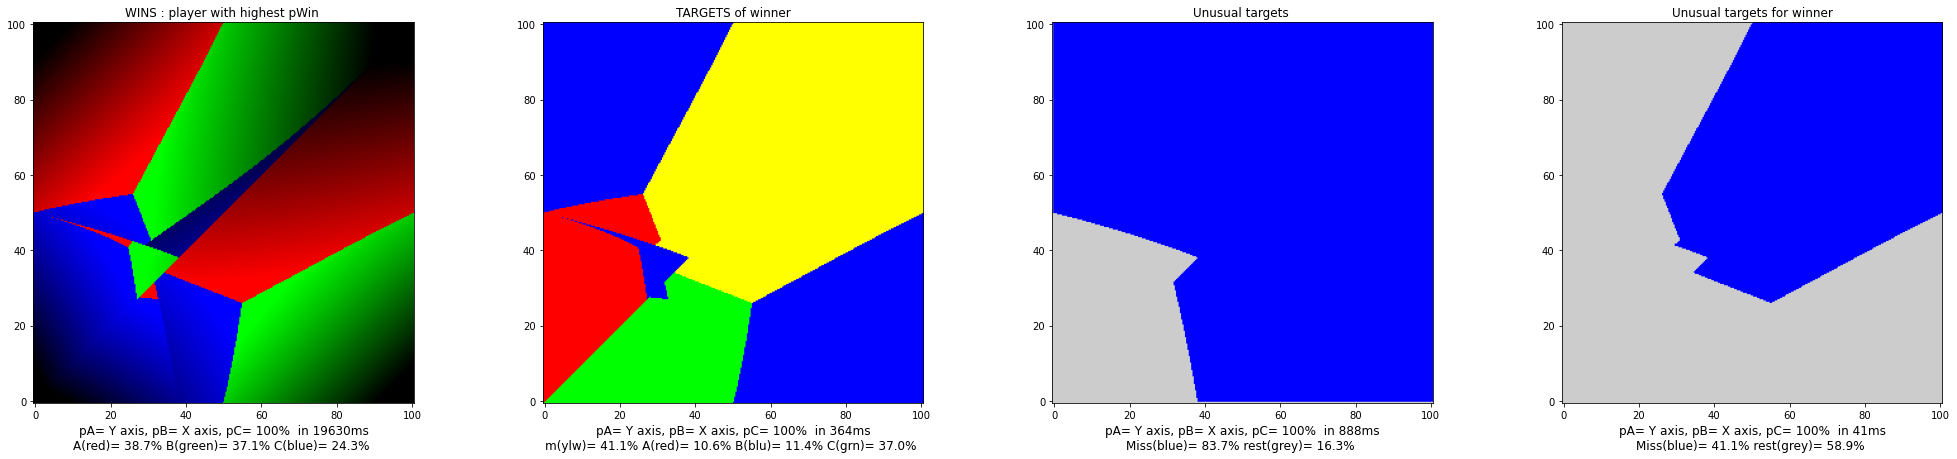

In [95]:
testAB3(colors=['w','tw','u','uw'],AgtB=True)

<a id='id_analysis'></a>
<b><h1>3. Analysis</h1></b>

<a id='id_cmp_smart_normal'></a>
<h2>3.1 Comparison between "smart" and "normal" AB methods</h2>

There are two methods available for every 'AB' function:
* **Normal method** : calculate value of truel() solution for every point x point case in 0<= pA,pB <=1 range ( using simulation or math calculation algorithm )
* **Smart method** :  (default) performance optimization that does not calculate for every point. Instead, it subdivide image to smaller areas, and if area is homogenous then it interpolate values, otherwise subdivide/calculate.

Performance advantage range from moderate for small images (200 x 200), to dozens or hundreds of times for larger images ( 1000 x 1000 ) - depending not only on size of image, but also on parameters of AB function like search options etc.  
But any optimization has potential to introduce errors, so here we will use those same AB functions to analyze difference between 'smart' and 'normal' methods. It will show that smart method is acceptable approach with very low result difference.

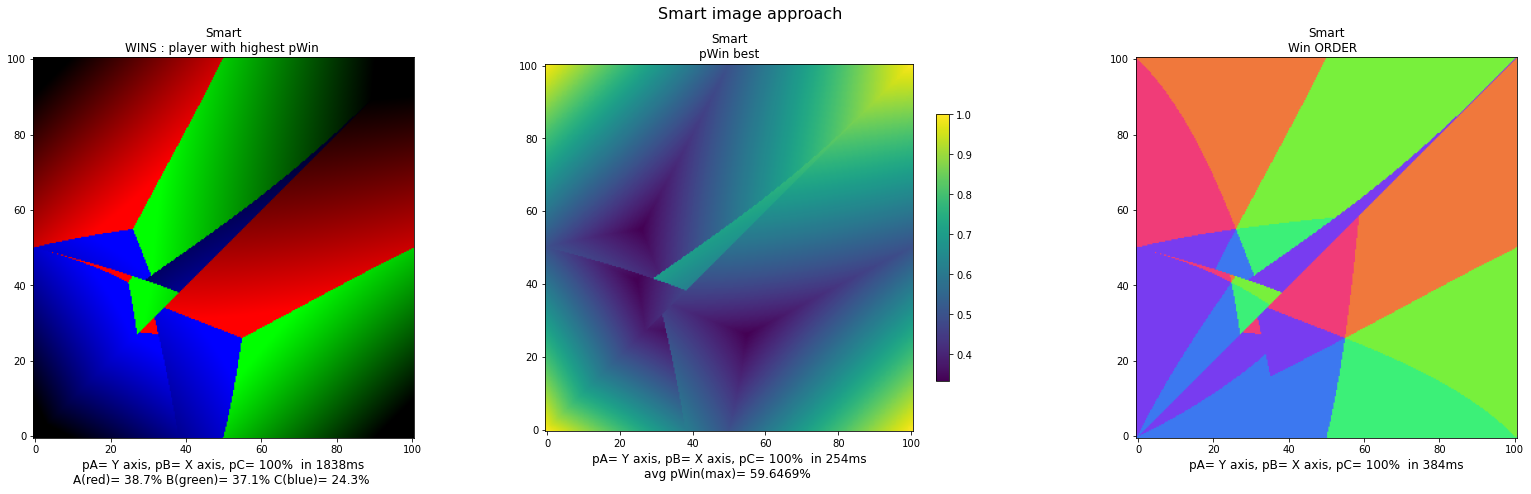

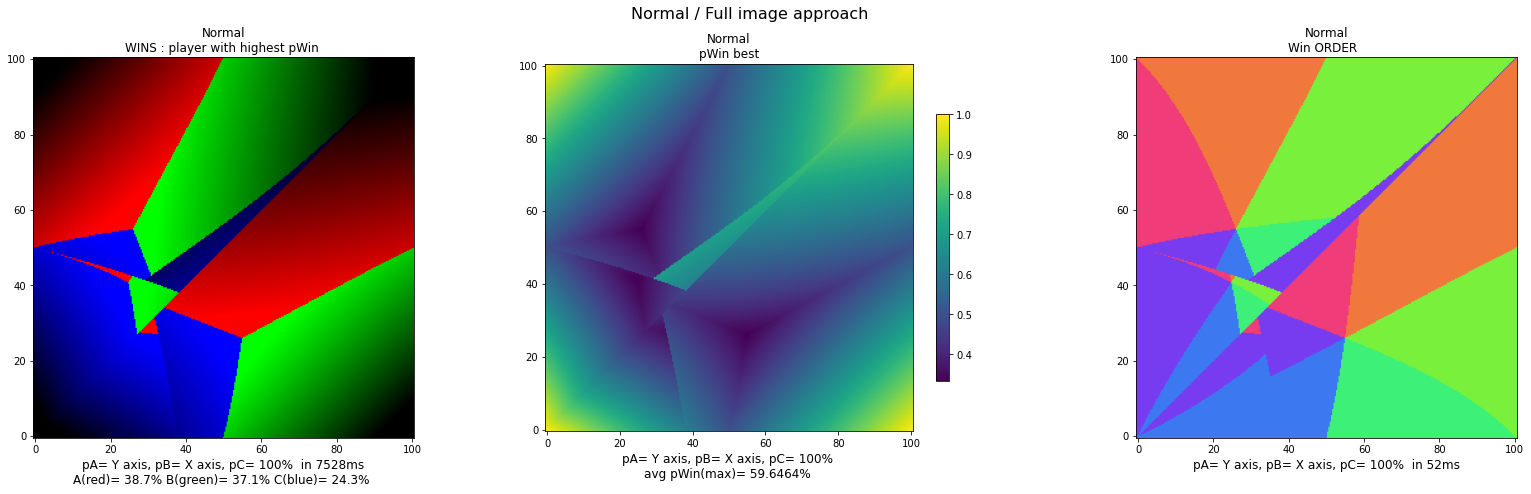

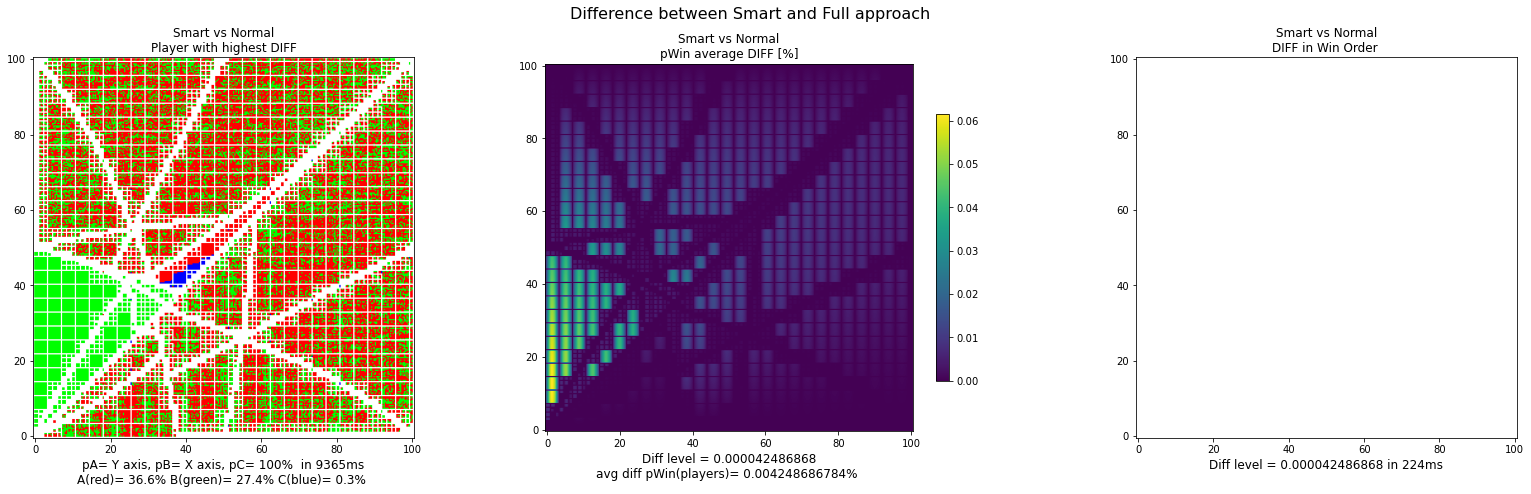

In [96]:
tSmart=Test(points=300, targets= [Optimal, Optimal, Optimal ] , search= [ Others, Miss], colors=['w','p','o'], method="smart", title="Smart") 
testAB(tSmart, title="Smart image approach")
tNormal= tSmart._replace( method="normal", title="Normal")
testAB(tNormal, title="Normal / Full image approach")
diffAB( tSmart, tNormal, title="Difference between Smart and Full approach")

Above comparison is for standard AB image that cover any win probability for A and B ( 0<= pA,pB <= pC ; pA is on Y axis and pB is on X axis ), while pC is fixed at 100%.  
It also use standard parameters for initial targets [ Optimal, Optimal, Optimal ], meaning solution is finding optimal targets at every point, among default options [ Others, Miss ] ( so players can shoot at other players or intentionally miss )  

* First two rows shows graphs for 'smart' method (1st row), and 'normal' method (2nd row), with same type of **testAB** images per columns, or 'colors' scheme:
    1. 'w': WINS image shows which player has higher chance to win at every point, with colors as mentioned on label under picture. It also shows time needed to calculate, so we see  that even for small 300x300 picture it is already 2.5x faster
    2. 'p': pWin BEST shows probabilities to win for player who has highest win probability for each point, color coded between 50% ( dark colors) and 100% chance (light colors)
    3. 'o': Win ORDER show different color for each order of win probabilities. It is similar to first WINS image, with each primary win color subdivided in 3 shades

* Third row directly compare two results, using **diffAB** function with same parameters as above  testAB. This analyze absolute difference of two results across entire area, both for probabilities and for optimal targets found:
     1. 'w : Player with highest DIFF - color coded which player has highest difference at each point. Not significant indicator for this, since it count any difference no matter how small.
     2. 'po': pWin AVERAGE DIFF - shows for each point average error/difference across all 3 players ( it range from 0% to 0.06%), and then average across all points ( **just 0.004%** )
     3. 'do': DIFF in Win ORDER - color each point where error/difference is large enough to change win order ( **no error** was so large here )
     
     
Same pattern is visible on first two AB DIFF images in third row:
- pattern shows rectangles, since 'smart' method subdivide image to smaller rectangles and then either interpolate or further subdivide at boundary areas
- therefore those boundary areas have highest precision, since they are mostly completely calculated. On 'p' color scheme those are dark purple areas near 0.000, and on 'w' scheme those are white areas ( where no player has difference )
- while win probabilities have very small differences  ( around 0.02% for players with highest diff at each point ), they never influence optimal target selection or overall winner 

### Conclusion:
Smart AB calculation is **acceptable alternative** to full size x size calculation. It has an order of magnitude smaller error margin ( compared to exact mathematical solution ) than simulation solution with 1 million rounds per each point, which itself is still acceptable approach used in many analyses.
    

<a id='id_cmp_random'></a>
<h2>3.2 Comparing simulations at different iteration counts</h2>

Simulations are inherently approximate solutions with variability in results even when run twice with same input parameters. That variation, and related simulation errors, are reduced when number of iterations for each result ( each pixel in AB images ) is increased. Default number of iterations here is 1 million simulations per pixel. Precision of simulation result could be estimated either by analysing that variability in results over same inputs , or by difference in results to exact solutions ( when available ) . In this case, both approaches are used :
* variability in simulation results when compared two simulations with same input parameters
* differences in simulation results when compared to exact solutions from mathematical calculations
* both of above, for smaller number of iterations ( 100k instead of 1 million )

Another area of interest related to simulation is its performance - in other words, execution time. Execution time of simulation should increase linearly with increase in 'iterations' ( thus simulation with 100k iterations should be 10x faster than one with 1 million iterations ).  When simulation is also searching for optimal targets, it needs to repeat simulation for every valid target combination. For example, if players can choose each other as targets then each of three players has only 2 target options initially. But if players can also choose to Miss, then nTargetOptions=3 ,  if they can also shoot Self then nTargetOptions=4, and if they can also choose Random target then maximal nTargetOptions=5 .  And if solution is searching optimal target for every player, number of possible targets combinations is nTargetOptions ^ nPlayers , or 5^3 = 125 in this worst case for three players. Therefore execution time for simulation can increase hundreds of times depending on optimal search options.

Below comparison uses predetermined (fixed) target option without search for optimal targets, targets= [Miss, C, B ] , to compare variability of simulation results: 

(it has potentially 15 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation)

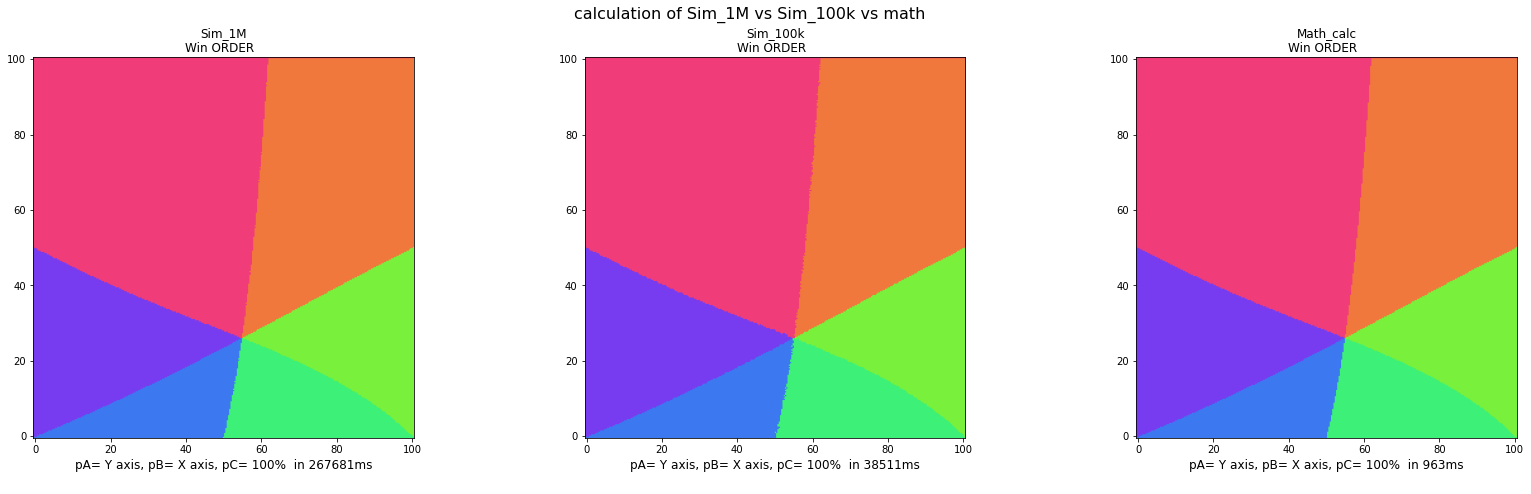

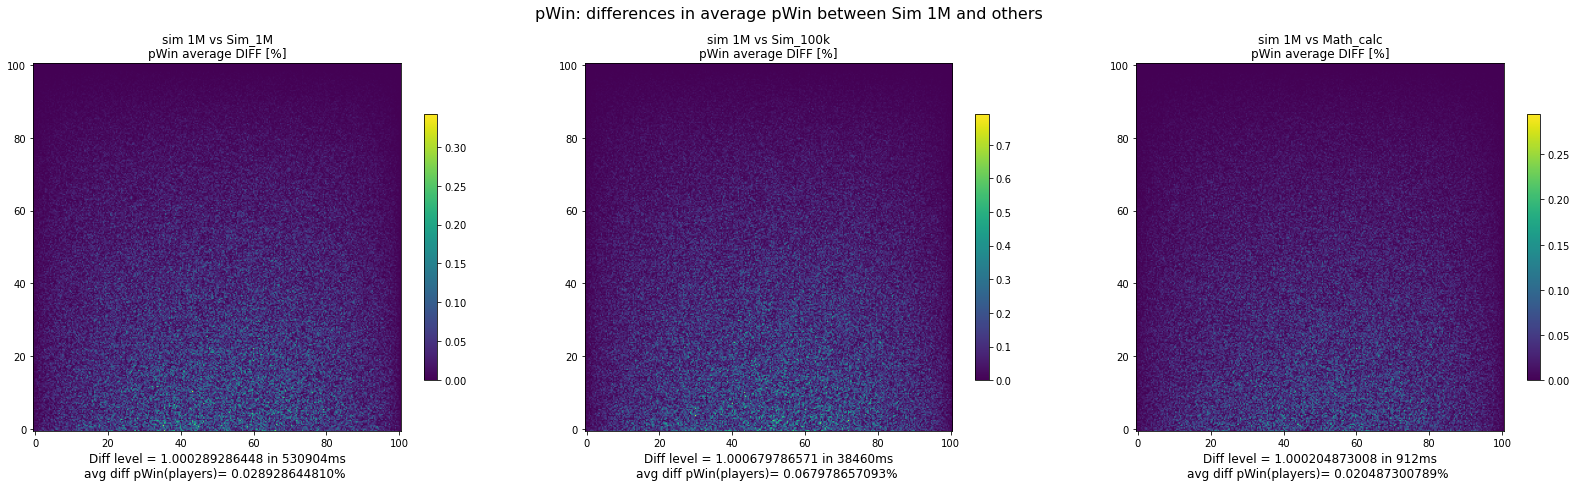

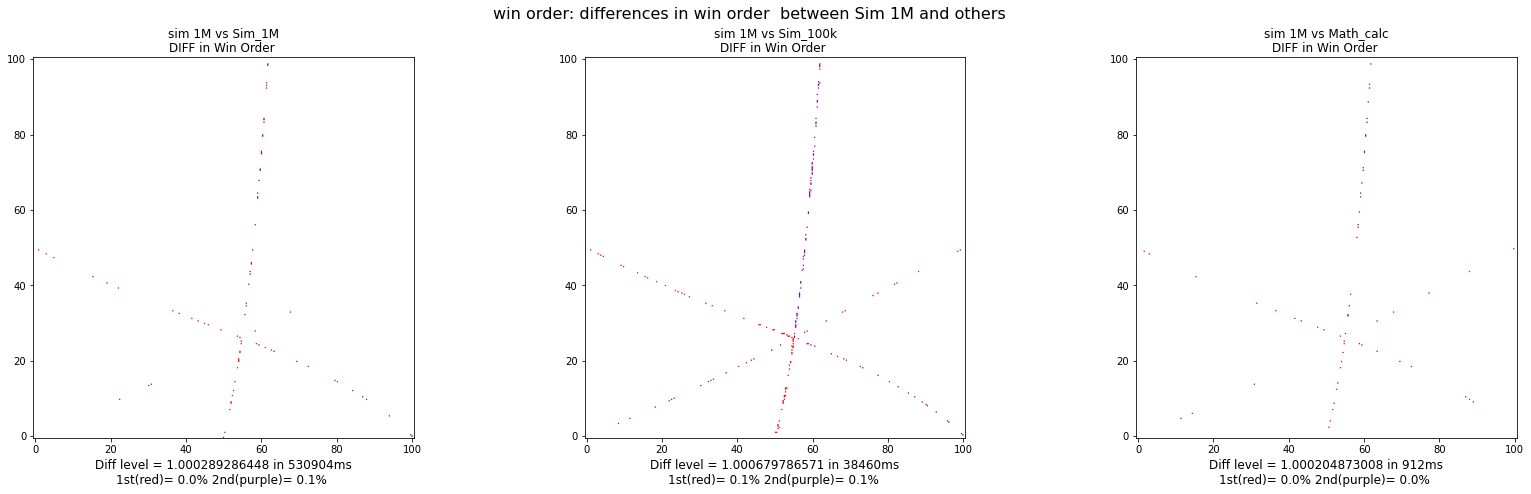

In [97]:
# create 300x300 AB test with standard problem ( fixed targets, no Optimal, for faster simulations)
tst1=Test(points=300, targets= [Miss, C, B ] , colors=['o'], method="normal", alg= algSim, iterations=1000000, title="Sim_1M") 
tst2=tst1._replace(iterations=100000, title="Sim_100k")
tst3=tst1._replace(alg=algMath, title="Math_calc")
tstAgainst= [tst1,tst2,tst3]
tstMain= tst1._replace(title="!sim 1M") # add '!' to title to force recalculation ( instead of cache )
testAB(tstAgainst , title="calculation of Sim_1M vs Sim_100k vs math", cache=cacheTypeSlow)
diffAB( tstMain, tstAgainst, title="pWin: differences in average pWin between Sim 1M and others", colors='dp', cache=cacheTypeSlow)
diffAB( tstMain, tstAgainst, title="win order: differences in win order  between Sim 1M and others", colors='do', cache=cacheTypeSlow)

Random calculation have small variations in results when rerun with same parameters ( as expected). It can be seen in "Sim_1M vs Sim_1M" images above, and it amount to 0.03% average difference in win probabilities of players ( second row, first image, pWim average DIFF). Those small differences can, in rare cases, even result in different 'win order' (order of players by their win chances), as seen in third row where every point with different win order is colored (red when even best player has changed, purple for 2nd, orange for 3rd). That naturally happens on borders between areas with different win orders, as seen in first row of images depicting 'win order' in different colors.  

Smaller number of simulation iterations ( 100,000 in Sim_100k as compared to 1,000,000 in Sim_1M ) result in higher average difference in win probabilities  ( again, as expected ). In this case it amount to 0.07% average difference in win probabilities of players, or over 2x more difference compared to natural variation in randomness (ie compared to just rerunning Sim_1M again ). But 0.06% is still acceptably small, and its difference in win order is similar in scale and position (along borders ) compared to Sim_1M.

Compared to exact mathematical calculations, Sim_1M has similar level of differences ( ~ 0.02% average difference in win probabilities of players between Sim_1M and Math_calc) as when compared to random variations ( ~0.03% when Sim_1M is compared to another Sim_1M rerun ). That further confirms suitability of Sim_1M for analysis.


Execution time for simulation in above example is kept low due to use of specific target ( targets= [Miss, C, B ] ) - therefore simulation did not need to calculate multiple cases for each pixel, and in general Sim_1M was 10x slower than Sim_100k ( as expected), while mathematical calculation was over 400x faster than Sim_1M.  But asking simulation to find optimal targets ( targets= [Optimal, Optimal, Optimal ] ) increases its time by the factor **nTargets ^  nPlayers** . If allowed targets are other players and Miss, then nTargets=3 for each player, so expected time increase would be 3^3= 27. But if we also allow self targeting and random targets ( 5 options in total), that factor is at least **5^3 = 125**  . That is confirmed in graphs below, where all 3 players are searching optimal target among all 5 possible target options ( 2 other players, self, miss, random ) :

( It has around 3 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

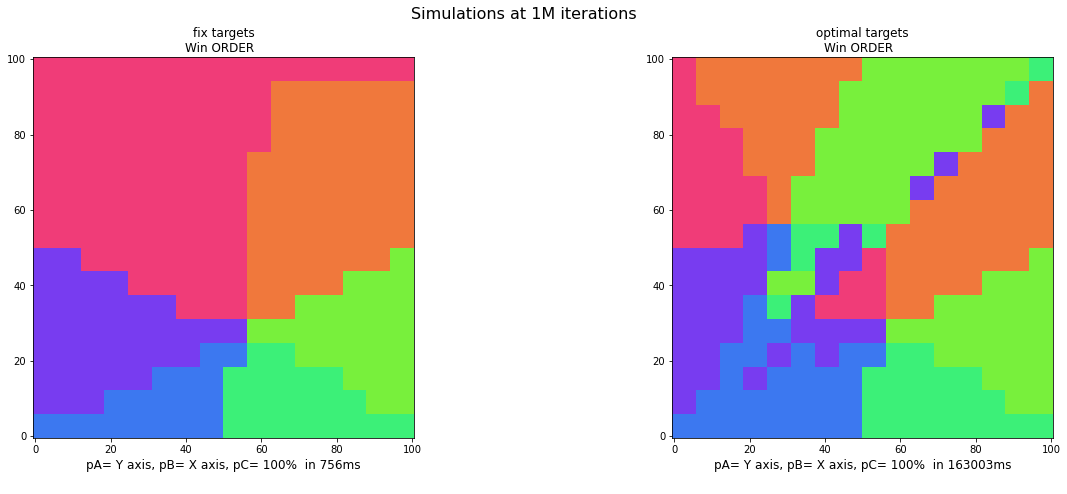

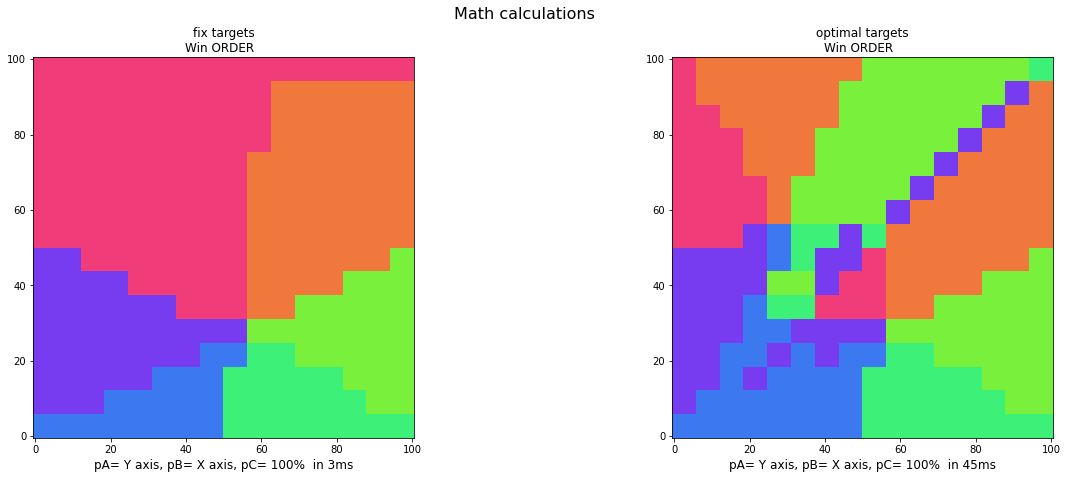

In [98]:
tst1=Test(points=15, targets= [Miss, C, B ] , search=[ Others,Self,Miss,Random ],colors=['o'], method="normal", alg= algSim, iterations=1000000, title="fix targets") 
tst2=tst1._replace(targets= [Optimal, Optimal, Optimal ], title="optimal targets")
tstSim= [tst1,tst2]
testAB( tstSim, title="Simulations at 1M iterations", cache=cacheTypeSlow)
tstMath= Replace(tstSim, alg= algMath) 
testAB( tstMath, title="Math calculations", cache=cacheTypeSlow)

Comparing execution times of simulation with fixed targets (top left image) and when searching for optimal targets (top right image) shows that optimal search is over 170x slower, which is in line with "at least 125". On the other hand,  mathematical calculation for optimal results is just 15-60x slower than calculating for fixed results, which is much less than factor 125.  Therefore performance advantage of math calculation increases from **x400** with fixed targets to over **x3000+** with search for all optimal targets.

Above comparisons are done with only 15x15 points, in order to limit execution time of simulations. Below is example of that same image in higher 300x300 resolution, using only math calculation:

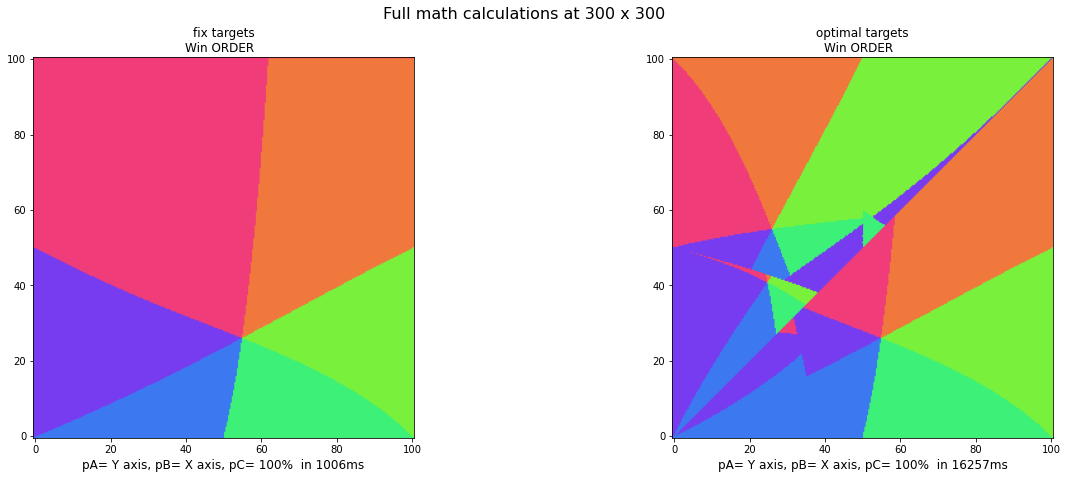

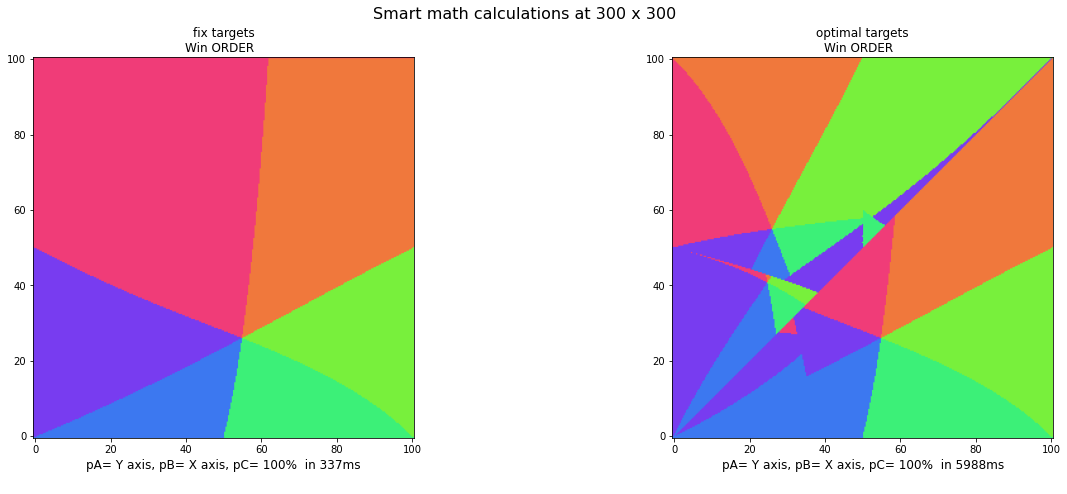

In [99]:
tst1=Test(points=300, targets= [Miss, C, B ] , search=[ Others,Self,Miss,Random ],colors=['o'], method="normal", alg= algMath, title="fix targets") 
tst2=tst1._replace(targets= [Optimal, Optimal, Optimal ], title="optimal targets")
tstFull= [tst1,tst2]
testAB(tstFull, title="Full math calculations at 300 x 300")
tstSmart= Replace(tstFull, method="smart") 
testAB(tstSmart, title="Smart math calculations at 300 x 300")





### Conclusion:
- natural variation in simulation results due to randomness, when 1 million iterations is used for each pixel, is on the order of 0.02% 
- compared to exact mathematical calculations, simulation result from 1 million iterations has similar level of average difference in win probabilities of players, around 0.03%
- using smaller number of iterations in simulation result in higher result difference. For simulation with 100,000 iterations it is around 2x higher , but still acceptable 0.07%
- execution time for simulations linearly increase with number of iterations, and for suggested 1 million iterations it is between x400 and over x3000 slower than mathematical calculation ( depending on optimality search )




<a id='id_investigate_3'></a>
<h2>3.3 Investigate for three players: A, B and C</h2>

Analyze every combination for hit chances of first two players ( A and B ), so pA=[0..1] and pB=[0..1], with fixed hit probability of third player C ( usually at pC=100%). Results in square picture.<br>
In some cases analyze more constrained scenario where 0 < = pA < = pB < = pC , and pC==1 . In other words, first player to shoot (A) has lowest chance to hit, and last player (C) always hit. Results in triangle picture due to pA<=pB .<br>

Plot will show pA on Y-axis (0% at bottom .. 100% at top ) and pB on X-axis (0% left .. 100% right ), while pC is constant at 100%<br>
Standard colors are darker for higher chance to win, and lighter for lower chance to win, and RGB color determine person who has highest chance to win ( the "winner" at that point ) :<br>
<ul style="margin-left: 30px"> 
    <li><font color=red>Red</font>:   player A has highest chance to win</li>
    <li><font color=green>Green</font>: player B has highest chance to win</li>
    <li><font color=blue>Blue</font>:  player C has highest chance to win</li>
</ul>





In [100]:
ptruel( [1/3, 2/3, 1] )


 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 1,208 us


Above is solution to original problem with fixed hit probabilities pA=1/3, pB=2/3 and pC=100%, which finds :
   - win probabilities ( pWin%=  [    39.7%   38.1%   22.2% ] ): player A wins in ~40% cases, followed by player B in ~38% cases and player C at just 22% cases, even if player C has highest hit probability
   - optimal targets ( targets=  [ m C B ] ):  it is optimal for player A to target "m" ( which means to intentionally Miss ), player B to target player C  and player C to target player B ( in initial rounds of truel while all of them are still alive ) 

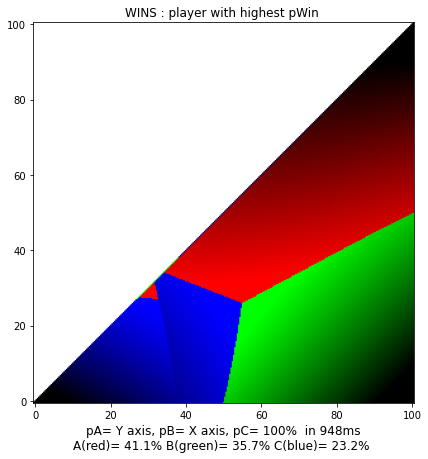

In [101]:
testAB3()

Above is default image comparison for different hit probabilities of players A and B ( Y and X axis) while player C has fixed hit probability at 100% :
* default for testAB method is 3 players, and for testAB3 it is actually fixed to exactly 3 initial players
* shows only cases where pA< pB ( so AgtB=False, resulting in triangle image which is default for testAB3 - while testAB method has default AgtB=True )
* default size is points=300
* default color="w" means it shows which player has highest chance to win at each point location ( for each combination of hit probabilities for A and B )
* default probability for player C to hit is 100%
* default initial targets are targets=[Optimal,Optimal,Optimal]
* default allowed targets are search=[ Others, Miss ] , meaning players can target other players or deliberately miss, but can not have more exotic options like target self ( suicide ) or random targeting
    
It does not show what are optimal targets for players at each point ( that would be color="p" option ) , nor what are win probabilities, but it shows that player A has highest change to win in most cases under above conditions (red color wins in almost 42% of cases )
<br><br>

We can also investigate cases where players are choosing fixed instead of "optimal" targets. 

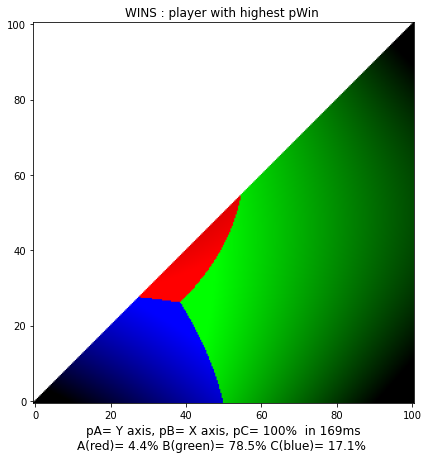

 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  31.2%  54.0%  14.8% ]   targets= [ *C, *C, *B ] tm= 704 us


In [102]:
testAB3(targets=[Strongest,Strongest,Strongest])  # targets=[C, C, B] would be identical here
ptruel( [1/3, 2/3, 1] , targets=[Strongest,Strongest,Strongest])

Above is case when all players are shooting at highest threat - so A and B target C, and C target B.
We see that player A can win in very small number of cases ( 4.4%, red color for player A is dominant only in small area around pA ~ 40% and pB ~ 40% )

It also shows win probabilities for original problem ( pHitA=1/3, pHitB=2/3 and pHitC=1 ) when all players target strongest player ( so targets=[C, C, B] ):  player A wins in  31% cases, which is less than in 'optimal' solution when he choose to Miss, and also less than player B win chances.

<br>When B and C are shooting at highest threat (each other) and A intentionally miss :<br>
Here player A can win in much more cases - in fact, red area is largest at 41.1%, meaning he wins more than B or C.

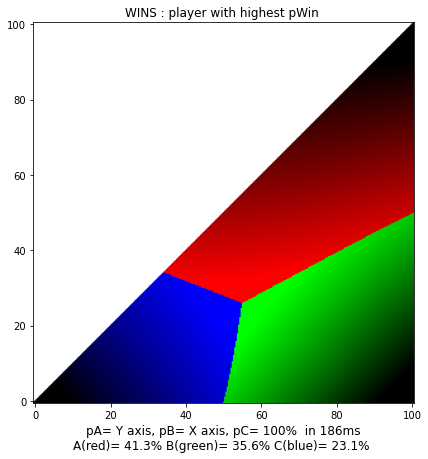

In [103]:
testAB3(targets=[Miss,C,B])

<br>Above is case when B and C are shooting at highest threat (each other) and A always intentionally miss :<br>
Here player A can win in much more cases - in fact, red area is largest at 41.1%, meaning he wins more than B or C.<br>

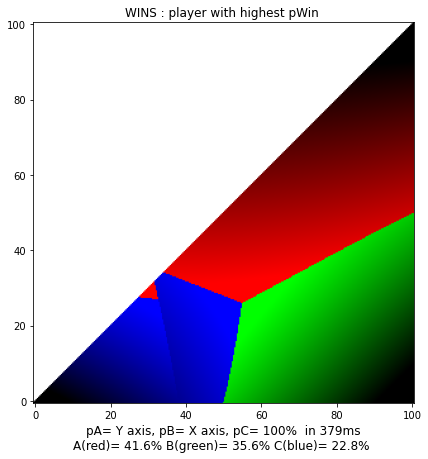

In [104]:
testAB3(targets=[tg.Optimal,2,1])

<br>Above is case when B and C are shooting at highest threat (each other) and A chooses optimal target <br>
This does not improve much, just by 0.3% - obviously shooting to miss was optimal tactic for A in most cases anyway. Only place it improves is small additional red area around pA ~ 30% and pB ~30%

To demonstrate that small improvement, here is calculation at pA=pB=30%, when A must miss (then C has highest chance to win, not A) and when A can choose optimal target ( targeting C, and A has highest chance to win)

In [105]:
ptruel([0.3,0.3,1],targets=[Miss,C,B])
ptruel([0.3,0.3,1],targets=[Optimal,C,B])

 pHit% [  30.0%  30.0% 100.0% ] :  pWin%= [  38.6%  12.4%  49.0% ]   targets= [ *m, *C, *B ] tm= 692 us
 pHit% [  30.0%  30.0% 100.0% ] :  pWin%= [  39.4%  26.3%  34.3% ]   targets= [ C, *C, *B ] tm= 1,403 us


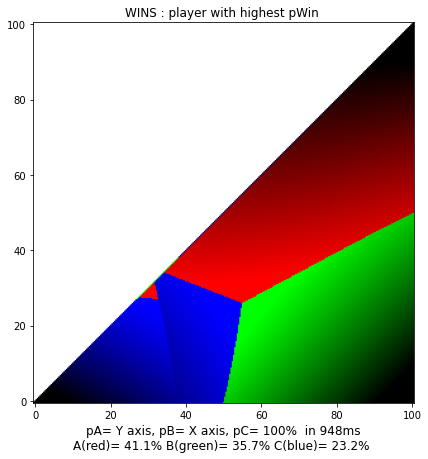

In [106]:
testAB3()

<br>Above is again situation initially shown, when all players are allowed to select optimal target:<br>
This is exactly same as when only A was allowed to select optimal target, indicating that for B and C it is always optimal to shoot each other.

<br><h4>But what if we look at entire area, including cases when pA > pB ? </h4><br>
Will "B and C target each other and A always miss" still be similar to "all players choosing optimal target" ? <br>
<br>
This is case when "B and C target each other and A always miss" :  player A wins in vast majority of cases (61.7%) - because others ignore him even when pA>pB <br>

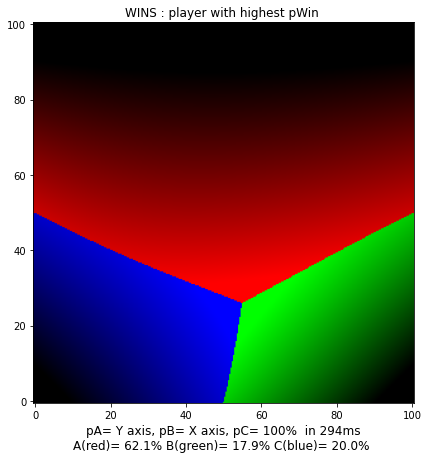

In [107]:
testAB3(targets=[Miss,C,B], AgtB=True)

<br>This is case when "all players choosing optimal target" :  player A now wins much less (38.9%), almost tied with B (36.7%) - since now all choose optimal target, and thus B and C fare bit better<br>
Another effect is that area is not so uniformly separated - now there are patches where different players have highest chance to win.

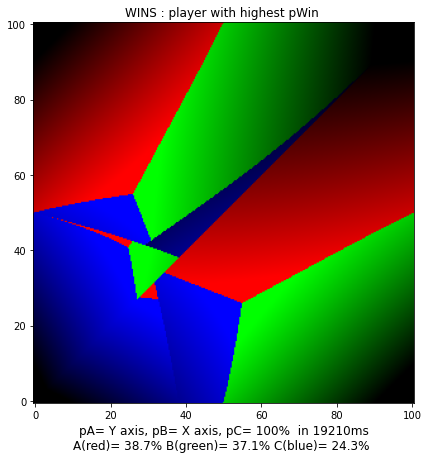

In [108]:
testAB3(AgtB=True)

Above shows that, while optimal targets result in very similar winners to fixed [Miss, C, B] targets in lower right triangle ( where pHitA< pHitB ), graph with optimal targets significantly differ from fixed one for cases when pHitA > pHitB ( upper left triangle) - which was expected, since in that area we would expect player B to start behaving like player A , meaning we would expect graph in upper left side to be similar ( almost symmetric ) to one in bottom right side, only with win colors swapped between player A (red) and player B (green). 

Indeed, those two triangles are almost symmetrical, with swapped red/green colors. Reason why they are **not fully symmetrical** is due to the fact that shooting order did not change and player A stil shoots before player B. That result in visible asymmetry, mainly in areas where pHitA is close to pHitB, especially around pHitA ~ pHitB ~ 30%.

<a id='id_original_problem'></a>
<h2>3.4 Original problem -  hit probabilities [ 1/3, 2/3, 1 ], and allowed targets Others/Miss</h2>


With above tools, it is easy to solve original problem: 

**Three players are doing truel, where each can choose who to try to shoot, then next player plays and so on until only one winner is left.<br> If first player has 1/3 chance to hit, second has 2/3 and last has 100% chance to hit - what is the chance of first player to win and who he should target at start ?**



In [109]:
ptruel(pHits=[1/3,2/3,1])

 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 812 us


Specific solution for first player is :
**Player A should target to Miss at start, and his win chance is 39.7%**

Solution by default search for optimal targets, and it found here that targets=  [ m C B ] , which means it is optimal for player A to intentionally miss, for player B to target player C, and for player C to target player B - until one of them is elininated, after which it is optimal for both remaining players to target each other.  Another default in solution is that allowed targets ( examined by optimal search ) are Others ( other players ) and Miss. Targets that were not allowed in default search are Self ( self targeting, suicide ) or Random. 

We can also demonstrate why those targets are optimal in this case:

In [110]:
ptruelWhy(pHits=[1/3,2/3,1])

Legend:  * = best result, at #23. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |    0.0%  14.8%  85.2%    |   
    2  |   B A B  |    7.4%   0.0%  92.6%    |   
    3  |   B A m  |    0.0%   0.0% 100.0%    |   C+ 
    4  |   B C A  |   19.0%  40.2%  40.7%    |   
    5  |   B C B  |   26.5%  25.4%  48.1%    |   C+ B+ 
    6  |   B C m  |   24.5%  32.7%  42.9%    |   
    7  |   B m A  |    0.0%  44.4%  55.6%    |   
    8  |   B m B  |   22.2%   0.0%  77.8%    |   
    9  |   B m m  |    0.0%   0.0% 100.0%    |   C+ 
   10  |   C A A  |    4.8%  43.4%  51.9%    |   
   11  |   C A B  |   12.2%  28.6%  59.3%    |   C+ 
   12  |   C A m  |    6.1%  36.7%  57.1%    |   
   13  |   C C A  |   23.8%  68.8%   7.4%    |   
   14  |   C C B  |   31.2% 

When it come to player C turn, he will always select target option marked as "C+", depending on target choices made by players A and B before him. So in BA case ( A was targeting B, and B was targeting A, rows 1-3), best win probability for player C is if he intentionally miss (row #3, with 100% win chance). In BC case ( rows 4-6) , best for player C is to target player B ( row #5, with 48.1% win chance). In mC case ( when player A select to miss, and player B to target player C), best choice for player C is again to target player B (row 23, with 22.2% win chance).

When it is player B turn, he applies same logic - he will always select target option marked as "B+", depending on target choice made by A, and on what he knows player C will decide ( as described above). So if player A choses to miss, player B can choose to target either players A, B or to miss himself. If he chose player A (mA case), he knows player C will choose to miss (mAm case, row #21), and so his own win chance would be 0%. If he chose player C as target (mC case), he knows that C will chose B as target (mCB case, row 23), and his own win chance would be 38.1%. And lastly, if player B chooses to miss (mm case), he knows player C would target B (mmB, row 26), where player B again has 0% win chance. Logically, if player A selected to miss, player B will select to target player C - since that gives him highest win chance at 38.1% (among rows 21,23,26 where his win chances were 0%,38%,0% respectively). So row 23 is marked "B+" , indicating it would be choice for player B ( and player C after him ) if player A select 'miss' as target.  Same logic is applied if player A select C as target, resulting in player B also targeting player C ( row 14) ... and same logic leads to row 5 as player B choice if player A targets player B.

So, when it is player A turn, he knows what options would players B (and C) select depending on his target choice - those rows marked with "B+". So if he target B, it will be row 5 (where his own, player A, win chance is 0%); if he targets C it will be row 14 (where his win chance is 31.2%); and if he intentionally Miss, it will be row 23 (where his win chance is 39.7%). Logically, he will chose to Miss, since it result in largest win chance for him (39.7%). It result in player B choosing to target player C, and player C choosing to target player B ( row 23 )

Note that this optimality selection assume that ALL players were allowed to select same targets, so players B or C could have also selected to Miss - which is visible in rows 3,9,21 where player C would chose to miss.
<br>

We can demonstrate that same result using simulation instead of mathematical calculations:

In [111]:
ptruel(pHits=[1/3,2/3,1], alg=algSim)
ptruelWhy(pHits=[1/3,2/3,1], alg=algSim)

 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 127,728 us
Legend:  * = best result, at #23. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |    0.0%  14.8%  85.2%    |   
    2  |   B A B  |    7.4%   0.0%  92.6%    |   
    3  |   B A m  |    0.0%   0.0% 100.0%    |   C+ 
    4  |   B C A  |   19.1%  40.2%  40.7%    |   
    5  |   B C B  |   26.5%  25.4%  48.1%    |   C+ B+ 
    6  |   B C m  |   24.5%  32.7%  42.8%    |   
    7  |   B m A  |    0.0%  44.4%  55.6%    |   
    8  |   B m B  |   22.2%   0.0%  77.8%    |   
    9  |   B m m  |    0.0%   0.0% 100.0%    |   C+ 
   10  |   C A A  |    4.8%  43.4%  51.9%    |   
   11  |   C A B  |   12.2%  28.5%  59.3%    |   C+ 
   12  |   C A m  |    6.

Although simulation is some 250 times slower than calculation ( 194ms vs 0.75ms ), it result in practically identical solution as mathematical calculation - as expected, with only minimal variations due to simulation being approximate. 

It is notable that optimal strategy for player A was to **miss** , which not only improved his win chances compared to selecting regular target like "shoot at player C", but also resulted in player A having highest chance to win ( 39.7% vs 38.1% of player B or just 22.2% for player C) - their win chances are in reverse compared to their hit chances.

It is easy to see how it would all look if players were not allowed to miss:

In [112]:
ptruelWhy(pHits=[1/3,2/3,1], search=[Others])

Legend:  * = best result, at #8. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |    0.0%  14.8%  85.2%    |   
    2  |   B A B  |    7.4%   0.0%  92.6%    |   C+ 
    3  |   B C A  |   19.0%  40.2%  40.7%    |   
    4  |   B C B  |   26.5%  25.4%  48.1%    |   C+ B+ 
    5  |   C A A  |    4.8%  43.4%  51.9%    |   
    6  |   C A B  |   12.2%  28.6%  59.3%    |   C+ 
    7  |   C C A  |   23.8%  68.8%   7.4%    |   
    8* |   C C B  |   31.2%  54.0%  14.8%    |   C+ B+ A+ 
-------------------------------------------------------------------------------
Optimal/best result :    pHit% [  33.3%  66.7% 100.0% ]:  pWin%= [  31.2%  54.0%  14.8% ]  targets= [ C C B ]


Much smaller number of target combinations (2^3 vs 3^3 when Miss is allowed), but same logic for selecting optimal targets can be applied, and it would results in "Player A should target C at start, and his win chance is 33.3%". 
It is notable that not only player A has lower win chance without Miss option (33% vs 40%), he also does not have highest win chance ( that would be player B here, with 54%)

<a id='id_miss'></a>
<h2>3.5 MISS target option - in what cases it is optimal strategy</h2>

As we could see in [solution to original problem](#id_original_problem) above, it can be optimal strategy for some players to select to miss in some situations. It does necessarily mean that selecting Miss as initial target will result in them haveing highest chance to win ( although in original problem, that is exactly what happened to player A when he select to Miss ).  But "Miss" is an optimal choice for player even if it does not make him top winner - as long as it increase his win probability.

It would be interesting to see how often ( and in which situations ) selecting "Miss" would be an optimal strategy.  To do that, we will use "interesting targets" visualization option:

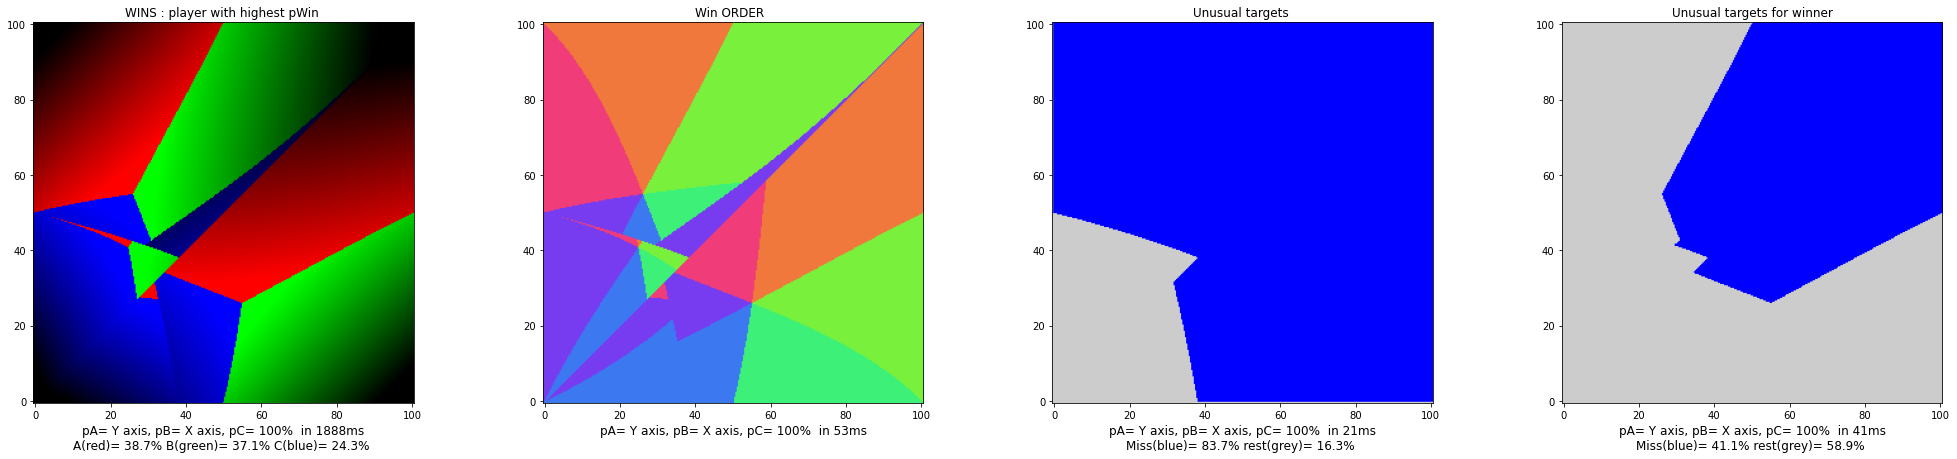

In [113]:
testAB( Test(search=[Others, Miss], AgtB=True, colors=['w','o','u','uw']) )


Third graph ( unusual targets) demonstrate that "Miss" was optimal target for at least one player in almost 84% of cases ( cases being all combinations of hit probabilities for player A and player B, with player C fixed at 100%). Rightmost graph ( unusual targets for winner, where 'winner' is person with highest win probability at that point ) shows that 'Miss' was optimal target for winners in smaller percentage ( 41% vs 84% ) when compared to cases when it was optimal to anyone - which was expected. But it is interesting that in almost half of the cases (41%) optimal strategy for winner was to select 'Miss'. 

We can do similar comparison, but allowing player C to have less than ideal hit chances:  10%, 25%, 50% and 100%.

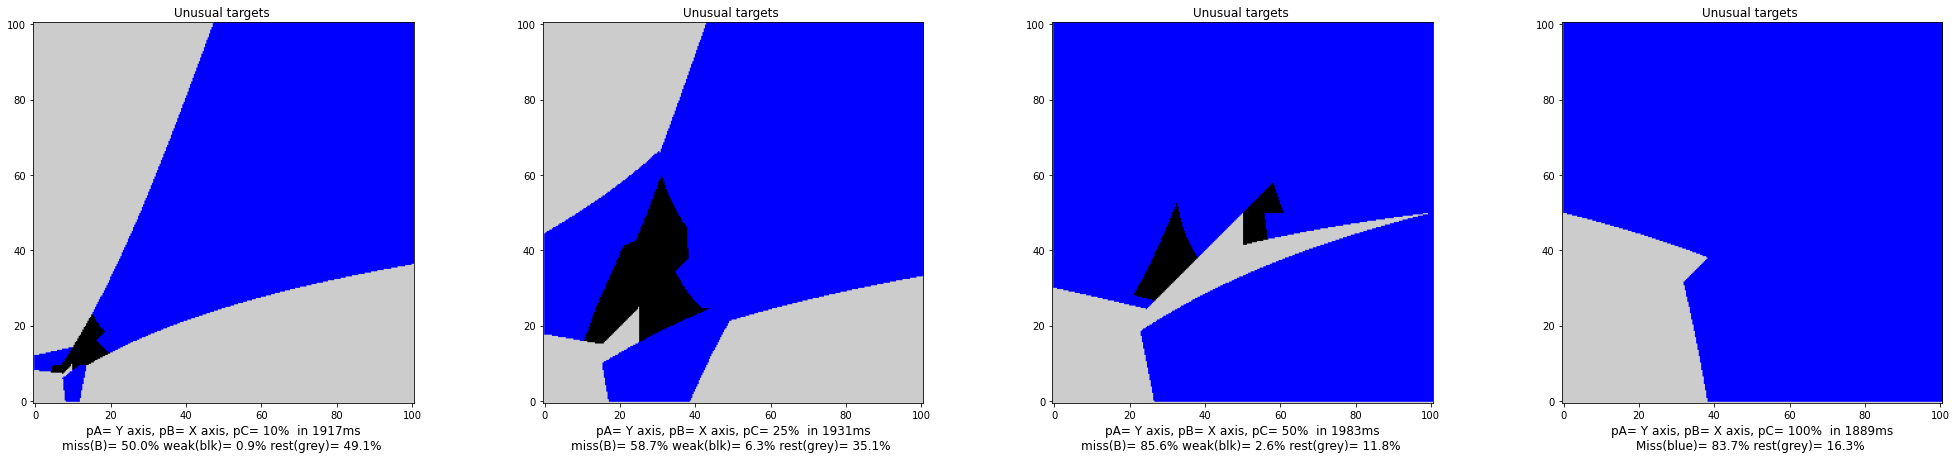

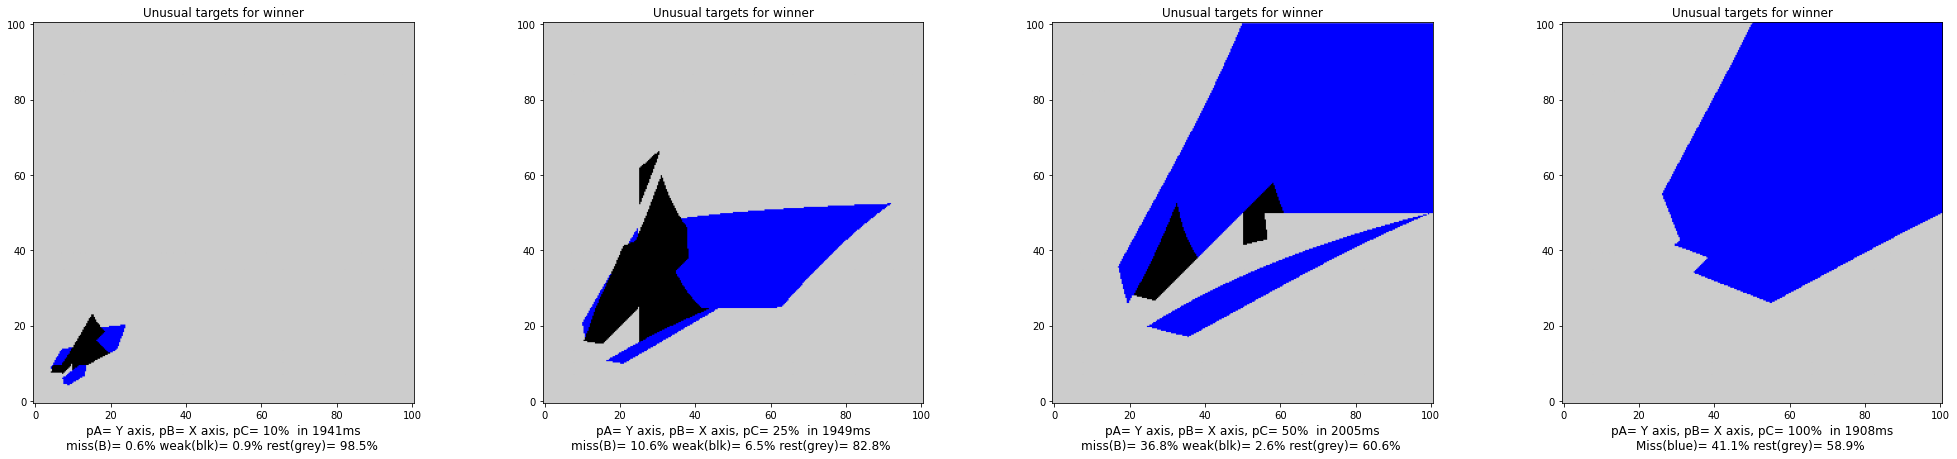

In [114]:
testAB3(pC=[0.1,0.25,0.5,1], search=[Others, Miss], AgtB=True, colors=['u'])
testAB3(pC=[0.1,0.25,0.5,1], search=[Others, Miss], AgtB=True, colors=['uw'])


"Unusual targets" ( first row of graphs above ) shows only most unusual target selected for given pixel/scenario, in order : green=Random, red=self, blue=miss, black= low threat, grey= rest. Since we only allowed [Others,Miss] as targets, there could not be green(Random) or red(Self) targets here. In cases when both "low threat" target ( someone who is not strongest) and "miss" targets are optimal for some players, graph shows blue(miss) color, as it consider Miss more "unusual" than targeting weaker player.  Bottom line is that, on these graphs, whenever optimal choice for some player was "Miss" it is represented with blue color.

We can see that "Miss" is an optimal target for at least one player in most cases ( over 50% of cases ), across all combinations of hit probabilities - not only all player A and B hit chances ( represented by Y and X axis on graphs), but also across all player C hit chances ( leftmost graph above is for pHitC=10%, followed by 25%, 50% and rightmost picture for standard pHitC=100% ).

But when looking at "Unusual targets for **winner**" ( second row of graphs ), it shows that winners would choose to 'Miss' as optimal choice in significantly smaller percentage of cases as we reduce probability of player C to hit. 

<a id='id_alternative_problem'></a>
<h2>3.6 Alternative problem - hit probabilities [ 75%, 55%, 100% ], and allowed Random targets</h2>


Alternative problem is almost same as original, with only difference in hit probabilities for players A and B ( while player C remains at 100% hit chance ):

**If first player has 75% chance to hit, second has 55% and last has 100% chance to hit - what is the chance of first player to win and who he should target at start ?**


If we allow same targets as for original problem ( targets=[Others,Miss] ), solution is obtained in similar way:

In [115]:
ptruel(pHits=[1/3,2/3,1])  # original problem
ptruel(pHits=[0.75,0.55,1]) # alternative problem, while allowed targets are still [Others, Miss]

 pHit% [  33.3%  66.7% 100.0% ] :  pWin%= [  39.7%  38.1%  22.2% ]   targets= [ m C B ] tm= 867 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  28.5%  60.2%  11.2% ]   targets= [ C m A ] tm= 873 us


It would appear that best win probability for player A is 28.5%, and his optimal target would be player C.

But **player A can do better** - while using same allowed targets (B,C,Miss) - by introducing novel approach:  **random target selection**

Essentialy, he will randomly select with same probability among allowed targets - in this case among player B, player C and Miss, each with 1/3 chance. Including 'Random' in target options result in:

In [116]:
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random]) # alternative problem, where 'Random' is also allowed target

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  32.7%  32.1%  35.1% ]   targets= [ r C A ] tm= 834 us


We can see that player A has **improved** his win chance to 32.7% ( compared to 28.5% from before ), and that his optimal target is 'r' (random).

Logic behing optimal selection can be demonstrated with:

In [117]:
ptruelWhy(pHits=[0.75,0.55,1], search=[Others,Miss,Random]) 

Legend:  * = best result, at #53. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |    0.0%   6.2%  93.8%    |   
    2  |   B A B  |    8.4%   0.0%  91.6%    |   
    3  |   B A m  |    0.0%   0.0% 100.0%    |   C+ 
    4  |   B A R  |    2.9%   2.1%  94.9%    |   
    5  |   B C A  |   11.6%   8.3%  80.1%    |   
    6  |   B C B  |   20.1%   2.1%  77.8%    |   
    7  |   B C m  |   13.1%   2.4%  84.5%    |   C+ B+ 
    8  |   B C R  |   15.0%   4.4%  80.6%    |   
    9  |   B m A  |    0.0%  13.8%  86.2%    |   
   10  |   B m B  |   18.8%   0.0%  81.2%    |   
   11  |   B m m  |    0.0%   0.0% 100.0%    |   C+ 
   12  |   B m R  |    6.8%   5.0%  88.2%    |   
   13  |   B R A  |    3.9%   9.4%  86.7%    |   
   14  |   B R B  |   15.7%   0

Since assumption of problem was that every player is allowed same target choice, it means that players B and C also could select 'Random' as target if it is optimal for them. That increase target options to 4 for each players ( 2 other players, Miss and Random ), and total number of targeting combinations to 4^3= 64 .  

But exactly same optimal target selection logic is applicable ( as explained in [original problem](#id_original_problem), or in [optimal search](#id_optimal_targets) section ). It means that :<br>
**Solution to alternative problem is :  player A can win with 32.7% probability, and his optimal initial target is 'Random' ( to randomly select, with equal chance, between allowed targets B,C and miss )**


In initial reasoning we said that 'Random' option can be used since it does not introduce new actual targets - allowed targets are still other players ( B and C for player A) and 'Miss' ( to intentionally miss).  We only assumed that player can choose to randomly select among valid targets. Probably only visible change to problem would be that now players would have to announce their selection explicitly to satisfy assumption that "players know which target choice was made by players before them ". Until now, we implicitly assumed that player C can deduce  what are player A and B choices :  first - whatever their optimal target was, it will remain same in all future round while still all 3 players are in game, and second- it is feasible that they could deduce target just by watching where players were targeting. But that was already questionable for 'Miss' target ( did player A accidentally or intentionally miss), so we mentioned that we can even assume players must announce their targets to avoid ambiguity. For 'Random' targets that is even more pronounced, but is not a problem if player A announced " I will randomly select between players B,C and Miss in all my truel rounds"

But what if we go even further here? What if player A announce " I will randomly select between players B and Miss"? Or " I will shoot at B in 25% cases, and on C in 50% cases, rest I'll miss" ?<br>
In other words, what if we **allow any random distribution** ?

Luckily, python solvers here already support any random distribution, both while specifying predefined targets or when searching for optimal target. Lets see how that differs when we use predefined targets:

In [118]:
# default alternative solution
# player A will randomly choose evenly among allowed targets B,C and Miss ( each 1/3 chance )
ptruel(pHits=[0.75,0.55,1], targets=[Random, C,A ])  
# identical solution, different way to specify random target
# random distribution for player A is explicitly stated (1/3 target B, 1/3 target C, and rest is Miss )
ptruel(pHits=[0.75,0.55,1], targets=[ [0,1/3,1/3], C,A ])  

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  32.7%  32.1%  35.1% ]   targets= [ *r, *C, *A ] tm= 845 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  32.7%  32.1%  35.1% ]   targets= [ *r, *C, *A ] tm= 1,241 us


Now lets slightly change random distribution for player A:

In [119]:
ptruel(pHits=[0.75,0.55,1], targets=[ [0,1/3,0], C,A ]) # target B in 1/3 cases, Miss otherwise
ptruel(pHits=[0.75,0.55,1], targets=[ [0,1/2,0], C,A ]) # target B in 1/2 cases, Miss otherwise
ptruel(pHits=[0.75,0.55,1], targets=[ [0,0,1/2], C,A ]) # target C in 1/2 cases, Miss otherwise

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  34.9%  25.0%  40.2% ]   targets= [ *r, *C, *A ] tm= 927 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  29.0%  20.8%  50.2% ]   targets= [ *r, *C, *A ] tm= 647 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  43.3%  44.0%  12.7% ]   targets= [ *r, *C, *A ] tm= 734 us


It obviously change result, and it appears that last distribution is best for player A - but we must not forget that here we fixed target selection, so players B and C could not select potentially beter options.

In order to really find best target options with any random distribution, we would have to allow Optimal search with any random distribution. By default, if we include random in search (like we did above with  search=[Others,Miss,Random] ) and when we ask program to find optimal solutions ( like we did when we did not specify targets, defaulting to targets=[Optimal, Optimal, Optimal] ) , program will always use "evenly random" option as shown on ptruelWhy listing above.

But there is another parameter that can instruct solver to try 'all' random distributions. That parameter is **optRndLevel**, and is expressed as list with integer value for each player defining how finely grained will be random distribution :

In [120]:
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[5,5,5])
truel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[5,5,5])

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  34.0%   6.2%  59.8% ]   targets= [ r C m ] tm= 9,337 us


array([[ 0.33971269,  0.06228066,  0.59800664],
       [-2.        ,  2.        , -1.        ],
       [ 0.        ,  0.6       ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ]])

While 'ptruel' function still display optimal target as 'r', in this case it is actually not clear what distribution that 'r' represent - to see that, use result of actual calculation function 'truel' which return multiple rows of 3 numbers ( when 3 players ):
- first row are win probabilities for each player
- second row are 'simple' optimal targets ( integer numbers that are translated to letters in ptruel, eg: -2= random, -1=miss, 0=A,1=B... )
- next row shows exact random distribution targets for player A : 0% A ( he will not target himself), 60% B ( target B in 60% of cases), 0% C ( he will not target C) ... and remainder is miss ( here in 40% of cases). This is represented as 'r' on ptruel
- same for player B - he will target C in 100% of cases, which is always. This is represented as 'C' on ptruel
- same for player C - he will not target anyone, meaning 'Miss'. This is represented as 'm' on ptruel

Since 'all distributions' would have infinite number of combinations, it must be somehow limited. So parameter accept number of 'random levels' for each player. In above example, 5 means that there would be 5 different random probabilities for each player, so examples of allowed random distributions would be : Atarget=[0,0,0] - meaning miss ; Atarget=[0,1/5,0] - meaning A will target B in 1/5 of cases, otherwise miss ; Atarget=[0,3/5,1/5] - meaning A will target B in 3/5 of cases, C in 1/5 cases, and miss in remaining 1/5 cases ; ... etc . Essentially, if optRndLevel=[5,5,5] is used, all random distribution values would be multiples of 1/5, ie 20% steps ( so 0%, 20%, 40%, 60%, 80% and 100%), but  there would be no target=[0, 15%, 0] for example.  Obviously, if we use optRndLevel=[20,20,20], it would cover all 5% steps, but it would be much slower to calculate.

Example of that random search with 20 steps instead of 5 ( more fine grained, but slower):

In [121]:
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[20,20,20])
truel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[20,20,20])

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  43.9%   8.0%  48.1% ]   targets= [ r C m ] tm= 9,256,527 us


array([[ 0.43871421,  0.08043094,  0.48085485],
       [-2.        ,  2.        , -1.        ],
       [ 0.        ,  0.45      ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ]])

Just by increasing how fine-grained random distribution can be, we changed probability of player A to win from 34% to 44%, and his optimal target from "randomly B in 60% cases, rest miss" to "randomly B in 45% of cases, rest miss"

This means that finding exact optimal solution when any random distribution is allowed may not always be computationally feasible. But finding close approximate optimal solution is doable - especially if solution is not equally sensitive to random levels across all players. In this example we see that only player A was selecting random options, regardless of 5 or 20 levels, so we could keep levels for players B and C lower. For example:

In [122]:
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[20,5,5])
truel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[20,5,5])

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  43.9%   8.0%  48.1% ]   targets= [ r C m ] tm= 94,226 us


array([[ 0.43871421,  0.08043094,  0.48085485],
       [-2.        ,  2.        , -1.        ],
       [ 0.        ,  0.45      ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ]])

Above used optRndLevel=[20,5,5] but resulted in exactly same solution as optRndLevel=[20,20,20] - while being 100x faster. That is because players B and C did not have optimal random choices, so more random levels in their case was not needed.

If we use that to further increase random levels for player A only, we get:

In [123]:
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[20,2,2])
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[50,2,2])
ptruel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[100,2,2])
truel(pHits=[0.75,0.55,1], search=[Others,Miss,Random], optRndLevel=[100,2,2])

 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  43.9%   8.0%  48.1% ]   targets= [ r C m ] tm= 13,010 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  46.0%   8.4%  45.5% ]   targets= [ r C m ] tm= 62,153 us
 pHit% [  75.0%  55.0% 100.0% ] :  pWin%= [  46.0%   8.4%  45.5% ]   targets= [ r C m ] tm= 235,386 us


array([[ 0.46025339,  0.08437979,  0.45536682],
       [-2.        ,  2.        , -1.        ],
       [ 0.        ,  0.42      ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ]])

We can see that we have same results for [20,2,2] as for [20.20.20], further confirming that players B and C did not have optimal random choices. Furthermore, we see that optimal result only slightly improved when increasing from 20 levels to 50 levels for player A ( [50,2,2]), and did not improve at all when increasing to 100 random levels.

That indicate we already found optimal result at 50 random levels, and we can assume that it would be optimal solution when any player can select any random distribution. Therefore we can state that :

**Solution to alternate problem when ANY random target distribution is allowed is :  player A can win with 46% probability, and his optimal target is random between player B in 42% of cases and Miss in 58% cases.**

Moving from 'can miss' to 'can randomly target with equal chance' improved player A win chance from 28.5% to 32.7%. But moving from 'equal random' to 'any random distribution' did not only further improve player A win chance to 46%, it made him person with highest win chance.

<a id='id_random'></a>
<h2>3.7 Random target option - where and why it change optimal targets solutions</h2>

As we could see in [solution to alternative problem](#id_alternative_problem) above, it can be optimal strategy for some players to randomly select targets in some situations. Just like in 'miss' target analysis, it does necessarily mean that selecting Random as initial target will result in them having highest chance to win - but Random can be an optimal choice for player as long as it increase their win probability.

Both mathematical solution solver and simulation solver from this document were enhanced to support random targets. While it was very easy and natural extension of simulation ( which is already based on random hit/miss results), it was quite harder to incorporate in recursive mathematical solver in a way that would not significantly increase computational time, but it was eventually doable both for 'equal Random' where players can select randomly with equal chance among valid targets, and for 'unequal Random' where player A can select for example "randomly shoot at B in 25% cases and C in 50% of cases" ( thereby not only is probability of shooting at B different from that of shooting at C, they are also different from 0% probability to intentionally Miss ). This enhancement is covering both ability to calculate win probabilities when random targeting is involved, and ability to find optimal targets when random targets are allowed.

To see how often ( and in which situations ) selecting "Random" would be an optimal strategy, we can again use "interesting targets" visualization option. Note that "Random" by default means random select among valid targets with equal chance. In this case 'valid targets' are Others and Miss, which means every player has 3 valid targets ( for example, player A can shoot B, C or Miss ), and when player A select "Random" as his targeting option it means he will randomly select to shoot at B in 1/3 cases, at C in 1/3 cases and will intentionally Miss in 1/3 of the cases. 

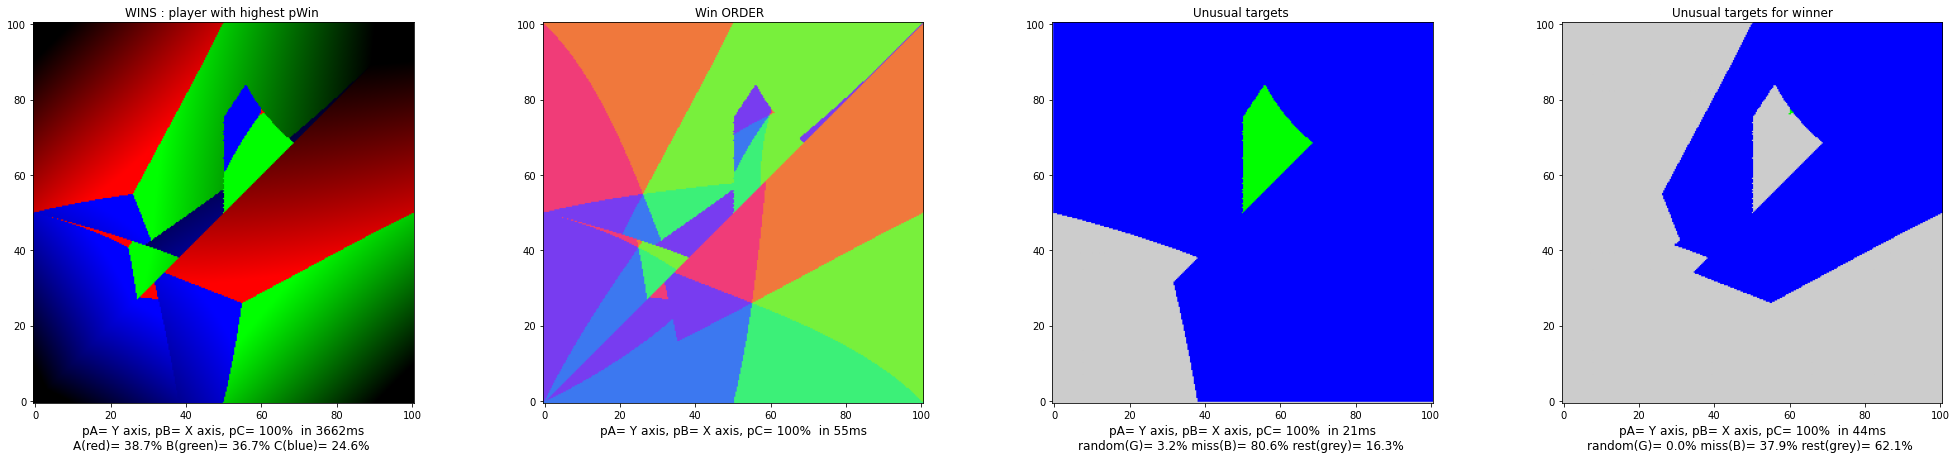

In [124]:
testAB( Test(search=[Others, Miss, Random], AgtB=True, colors=['w','o','u','uw']) )

Unusual targets graph (3rd one) is similar in shape to graph where we only [allowed Miss](#id_miss) , without Random. Most important difference is green area around pHitA=70% and pHitB=60% - that green color indicate that at least some player had 'Random' as optimal initial target.

Unusual targets for winner (last graph) is again similar to corresponding graph with just [Others,Miss] allowed, with difference in same area ( where pHit~60% ) - only this time that area is not green, indicating that Random was **not** an optimal target for winners, even if it was optimal target for other players in that area.

We can do similar comparison, but allowing player C to have less than ideal hit chances:  10%, 25%, 50% and 100%.

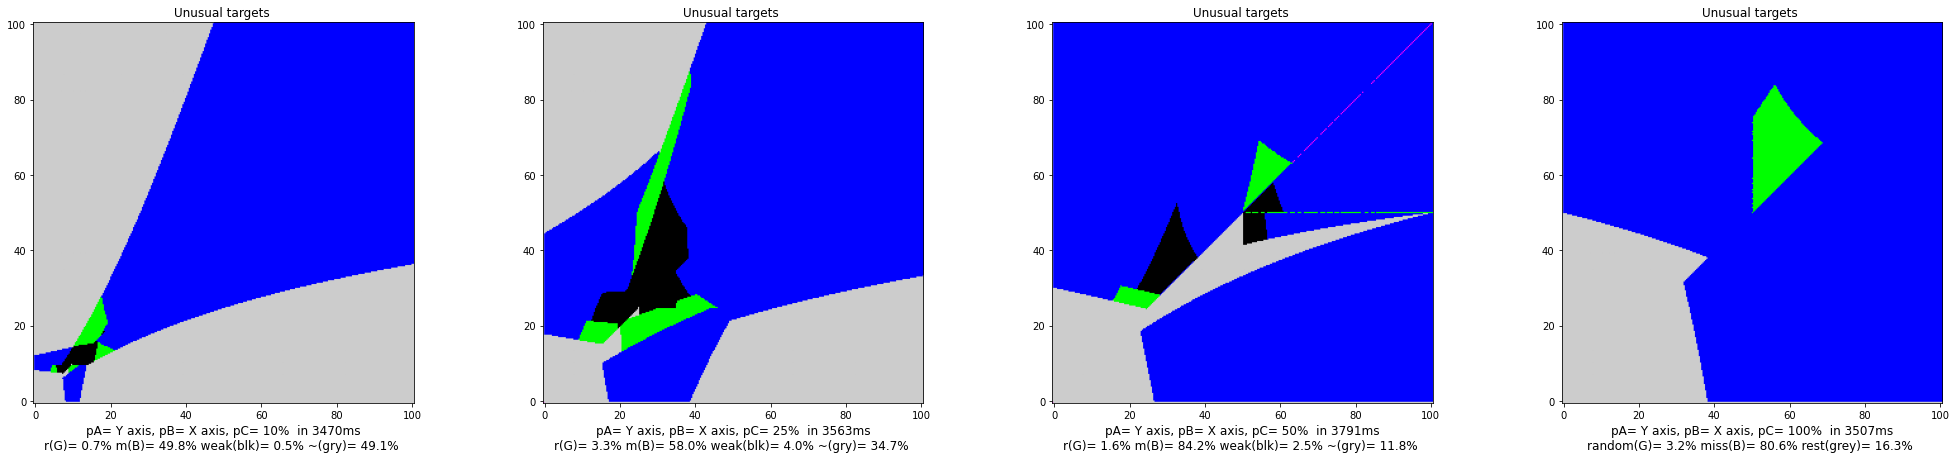

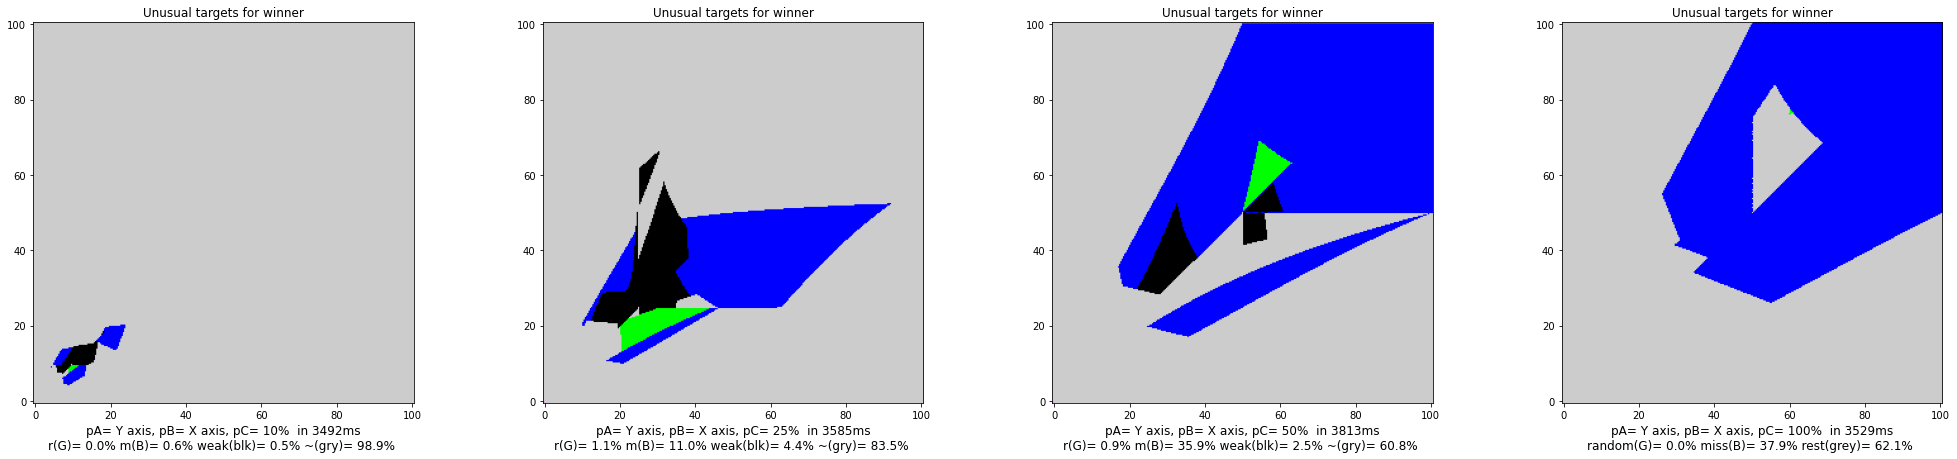

In [125]:
tst= Test( search=[Others, Miss, Random], AgtB=True, colors=['u'])
pC=[0.1,0.25,0.5,1]
testAB3t(tst, pC=pC)
testAB3t(tst._replace(colors=['uw']), pC=pC)


Top row with "unusual targets" demonstrate that 'Random' is optimal option for **some** players in noticeable number of cases (1-3% of cases). Bottom row with "unusual targets for winners" shows similar pattern as in just Miss case, namely reduced number of 'unusual' targets in general when we reduce hit chance for player C. 

But, more notably, we cab see some cases where **Random is optimal choice even for winners** , when player C is not at 100% hit chance ( for example, 3rd graph where pHitC=50%). Example of one specific point:



In [126]:
ptruel(pHits=[0.60,0.55,0.50], search=[Others, Miss])
ptruel(pHits=[0.60,0.55,0.50], search=[Others, Miss, Random])

 pHit% [  60.0%  55.0%  50.0% ] :  pWin%= [  27.4%   9.5%  63.0% ]   targets= [ B A m ] tm= 972 us
 pHit% [  60.0%  55.0%  50.0% ] :  pWin%= [  44.2%  36.8%  19.0% ]   targets= [ r C A ] tm= 986 us


In this specific case, standard optimal solution ( first line, when only others and Miss are allowed targets ) shows that player A has around 27% win chance, far behind player C at 63%.

But when we allow 'Random' targeting,  player A not only gets significantly higher win chance ( 44% vs 27%), but he also becomes a "winner" - player with highest chance to win in this particular example.

We could look at reasoning behind selection of optimal targets in this case:

In [127]:
ptruelWhy(pHits=[0.60,0.55,0.50], search=[Others, Miss, Random])

Legend:  * = best result, at #53. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   B A A  |   24.7%  15.6%  59.7%    |   
    2  |   B A B  |   32.1%   8.6%  59.3%    |   
    3  |   B A m  |   27.4%   9.5%  63.0%    |   C+ B+ 
    4  |   B A R  |   28.1%  11.3%  60.6%    |   
    5  |   B C A  |   42.4%  13.5%  44.1%    |   
    6  |   B C B  |   49.8%   6.5%  43.7%    |   
    7  |   B C m  |   47.1%   7.2%  45.7%    |   C+ 
    8  |   B C R  |   46.4%   9.1%  44.5%    |   
    9  |   B m A  |   28.1%  17.7%  54.1%    |   
   10  |   B m B  |   46.9%   0.0%  53.1%    |   
   11  |   B m m  |   37.5%   0.0%  62.5%    |   C+ 
   12  |   B m R  |   37.5%   6.5%  56.0%    |   
   13  |   B R A  |   31.9%  15.5%  52.6%    |   
   14  |   B R B  |   42.8%   5

**What if we allow different random distributions, in addition to just "equal random" ?**

Above analysis is related to default 'Random' option, which is "select randomly among valid targets ( other players and miss) with equal probability".  As we demonstrated in [alternative problem](#id_alternative_problem') solution, it is possible to have even more optimal solution when 'any random distribution' is allowed.  But such distribution require significantly more calculations ( depending on granularity parameter **optRndLevel** ), and while even high granularity was feasible for single case calculation in alternative problem ( with optRndLevel=100 ), it could be prohibitively slower for graphs with hundreds of thousands of pixels/calculations .

But in almost all cases if any player have random target as optimal option, it will be visible even at lower number of random levels, as it was demonstrated in alternative problem section. So even 2 random levels are enough to indicate which areas would have optimal targets 'random with any distribution':

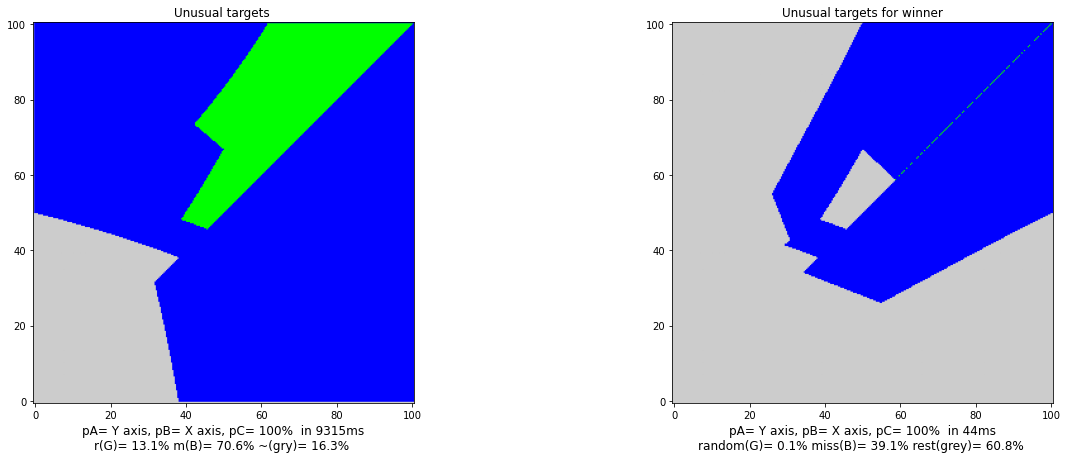

In [128]:
testAB(Test( search=[Others, Miss, Random], AgtB=True, colors=['u','uw'], optRndLevel=[2,2,2] ))

We can see that number of cases where optimal target is 'any random distribution' is noticeably larger compared to cases where 'equal random distribution' is optimal target.

To test if further increasing random details ( optRndLevel>2 ) will not significantly change this picture, we must reduce resolution :

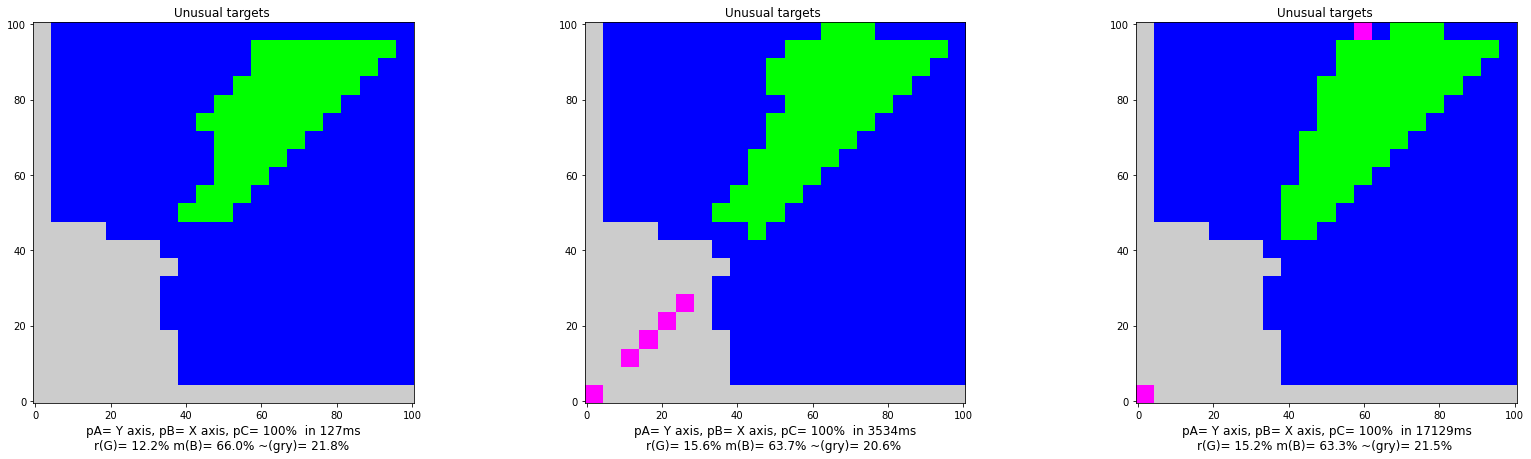

In [129]:
tst=  Test( search=[Others, Miss, Random], AgtB=True, colors=['u'], points=20 )
tst1= tst._replace( optRndLevel=[2,2,2] )
tst2= tst._replace( optRndLevel=[5,5,5] )
tst3= tst._replace( optRndLevel=[7,7,7] )
testAB( [tst1,tst2,tst3] )

Above graphs confirm that further increasing random details ( above optRndLevel=2 ) does not significantly change distribution of cases where distributed random is optimal target.

Therefore we can present below comparison between random optimal targets ( green color) in cases when 'no random', 'equal random' and 'any random' are allowed targets respectively:

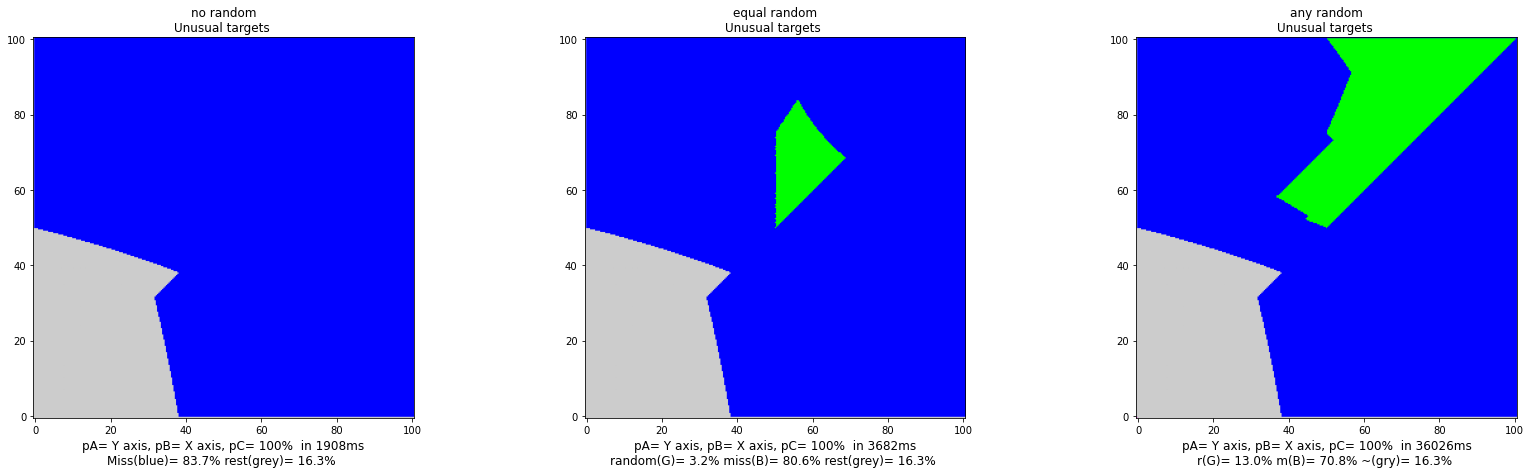

In [130]:
tst=  Test( search=[Others, Miss], AgtB=True, colors=['u'] )
tst1= tst._replace( title='no random' )  # without random option
tst2= tst._replace( search=[Others, Miss, Random], title='equal random' ) # with default ( equal ) random option
tst3= tst._replace( search=[Others, Miss, Random], optRndLevel=[3,3,3], title='any random' ) # with any random option
testAB( [tst1,tst2,tst3] )

We can look at same graphs, but for "unusual targets for winners" :

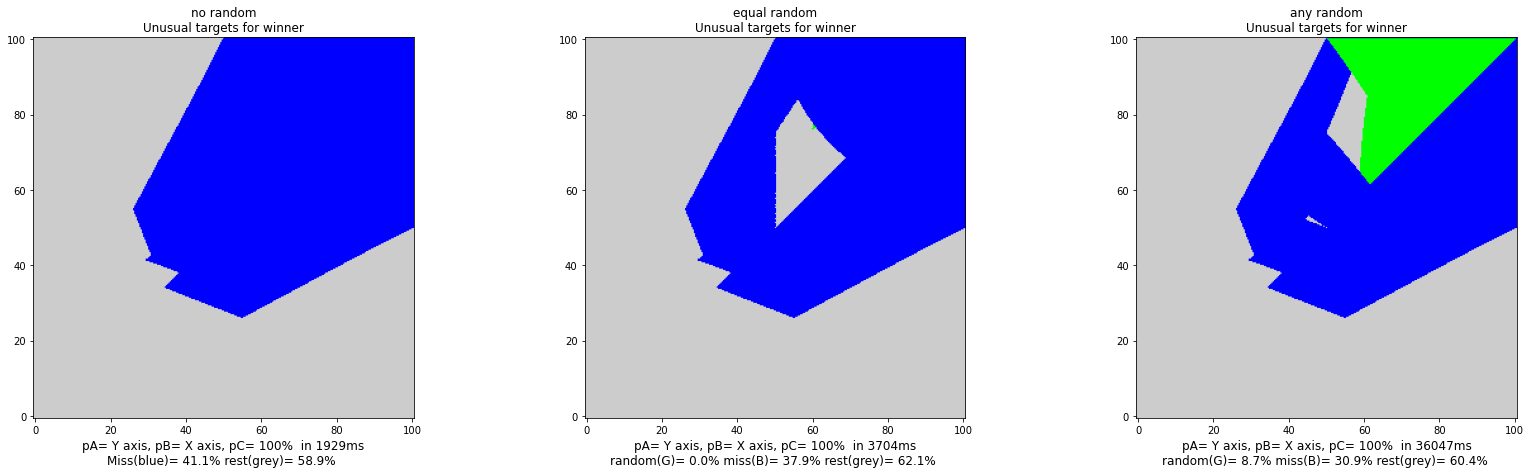

In [131]:
tst=  Test( search=[Others, Miss], AgtB=True, colors=['uw'] )
tst1= tst._replace( title='no random' )  # without random option
tst2= tst._replace( search=[Others, Miss, Random], title='equal random' ) # with default ( equal ) random option
tst3= tst._replace( search=[Others, Miss, Random], optRndLevel=[3,3,3], title='any random' ) # with any random option
testAB( [tst1,tst2,tst3] )

Most interesting in above graph is that it shows how "any random" option can result in Random being optimal even for winners in many cases ( green color on rightmost picture ), while it is not optimal anywhere for "equal random" ( middle picture).

It should be noted that above graph is for usual pHitC=100%, but we already showed that when we reduce pHitC ( for example, to 50% ) , there could be cases where even standard 'Random' is optimal choice for some winners. For example:

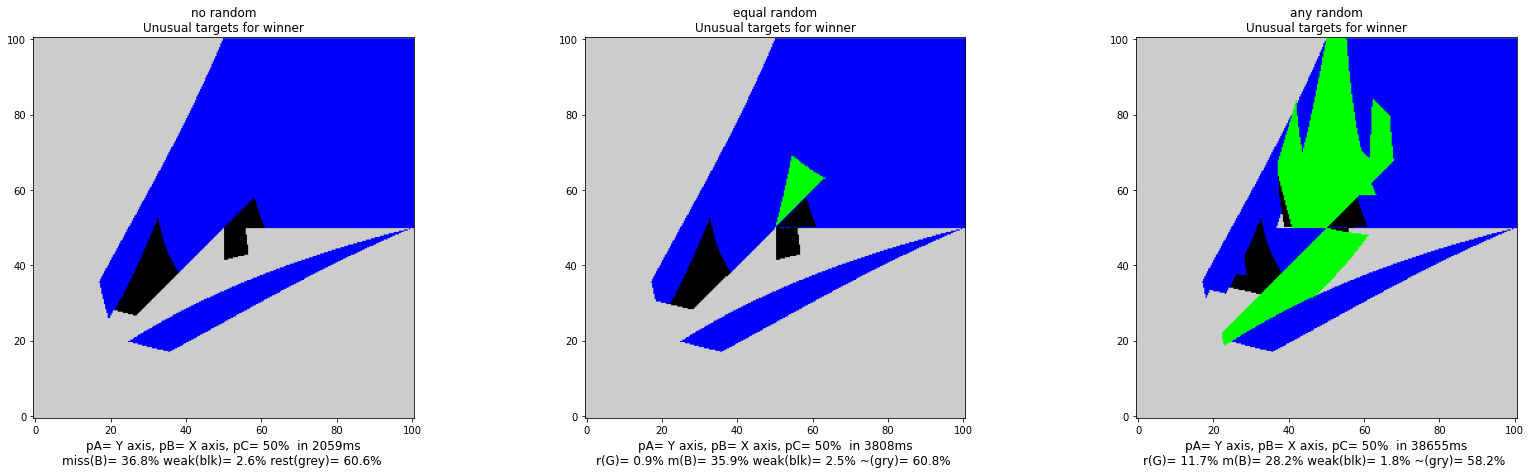

In [132]:
tst=  Test( pHits=[0, 0, 0.50], search=[Others, Miss], AgtB=True, colors=['uw'] )  # pHitC=50% 
tst1= tst._replace( title='no random' )  # without random option
tst2= tst._replace( search=[Others, Miss, Random], title='equal random' ) # with default ( equal ) random option
tst3= tst._replace( search=[Others, Miss, Random], optRndLevel=[3,3,3], title='any random' ) # with any random option
testAB( [tst1,tst2,tst3] )

When player C has hit chance fixed at 50% ( instead of 100% ), there are more cases where 'Random' is optimal choice: not only more cases when "any random" is used (3rd image from above, with more green area than previously), but also we can see that 'Random' is optimal choice even in some "equal random" cases ( 2nd image above, which previously did not have any green areas).

General **conclusions** about following questions:

**When is 'equal Random' target optimal ?**   ( 'equal Random' means equal probability to select any valid target )
* in **many** cases for 'at least one player'
* in **no** cases for 'winners',  when player C hit chance is standardly fixed at 100% 
* in **some** cases even for 'winners', when player C hit chance is reduced ( for example to 50% )

**When is 'unequal Random' target optimal ?**   ( 'unequal Random' means that any random distribution is allowed, in steps defined by **optRndLevel** parameter )
* in **more** cases for 'at least one player', compared to 'equal Random'
* in **some** cases even for 'winners'  when player C hit chance is standardly fixed at 100% 
* in **many** cases for 'winners', when player C hit chance is reduced ( for example to 50% )


In other words, standard 'Random' option is optimal in many cases for at least one player, and can be optimal even for winners if player C hit chance is reduced. If unequal Random is allowed, it is optimal in more cases than standard Random.

<a id='id_self'></a>
<h2>3.8 SELF target option - is it ever optimal targets solution</h2>

Original truel problem does not assume that players can select themselves as an target - that is essentially **suicide** attempt. 

Likewise, default allowed targets in solutions here do not include that option when searching for optimal solutions. But it is possible to specify 'Self' as target option.

For example, if A always shoot at himself (while all three players are alive), and B/C shoot at each other, we can specify that like this :

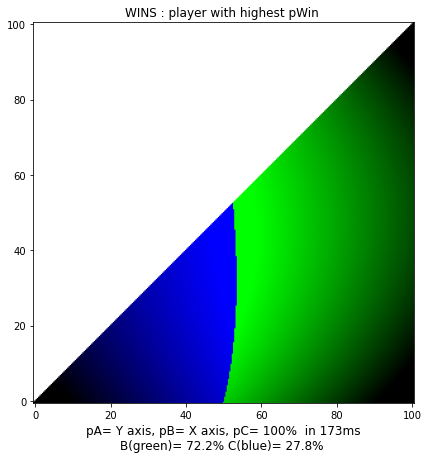

In [133]:
testAB3(targets=[Self,C,B])

It shows that 'Self' is not good option for player A, since he does not win for any hit probability case for players A/B. 

But we can also extend default search for optimal targets to allow 'Self' , and try to see if 'Self' is optimal target for any player in any hit probability case:

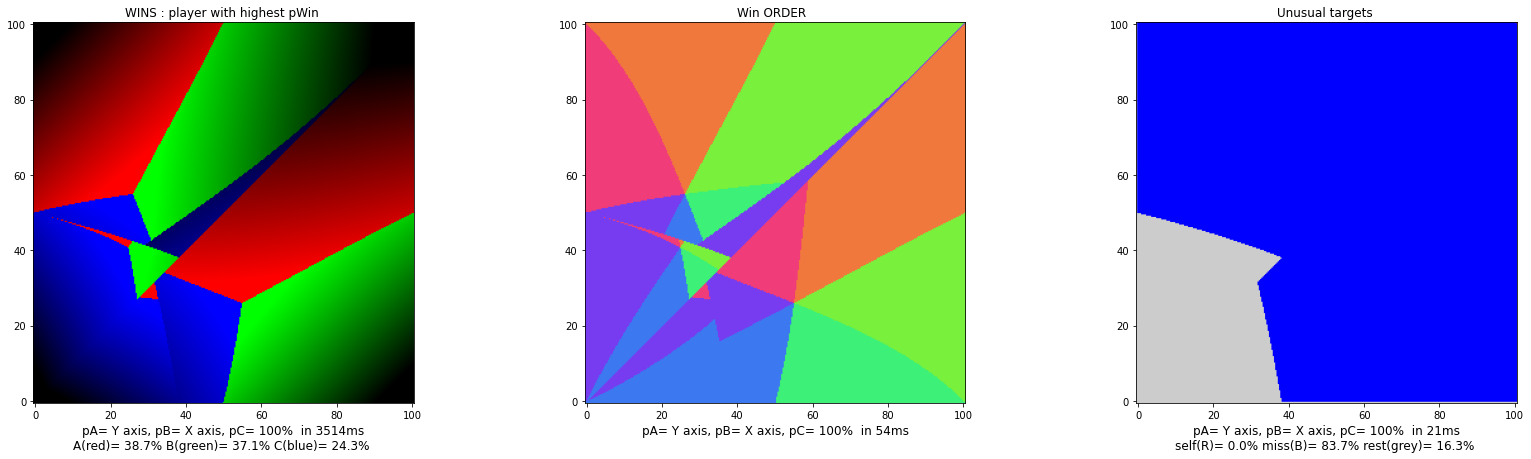

In [134]:
testAB( Test(search=[Others, Miss, Self], AgtB=True, colors=['w','o','u']) )

Above graphs look identical to situation when 'Self' is not allowed , shown in ['Miss' target analysis](#id_miss) - which indicate that **Self is never optimal target**.

To further demonstrate that, we can compare 'unusual targets' graphs when optimal search include  [Others, Miss] vs [Others, Miss, Self] vs [[Others, Miss, Self, Random ] :

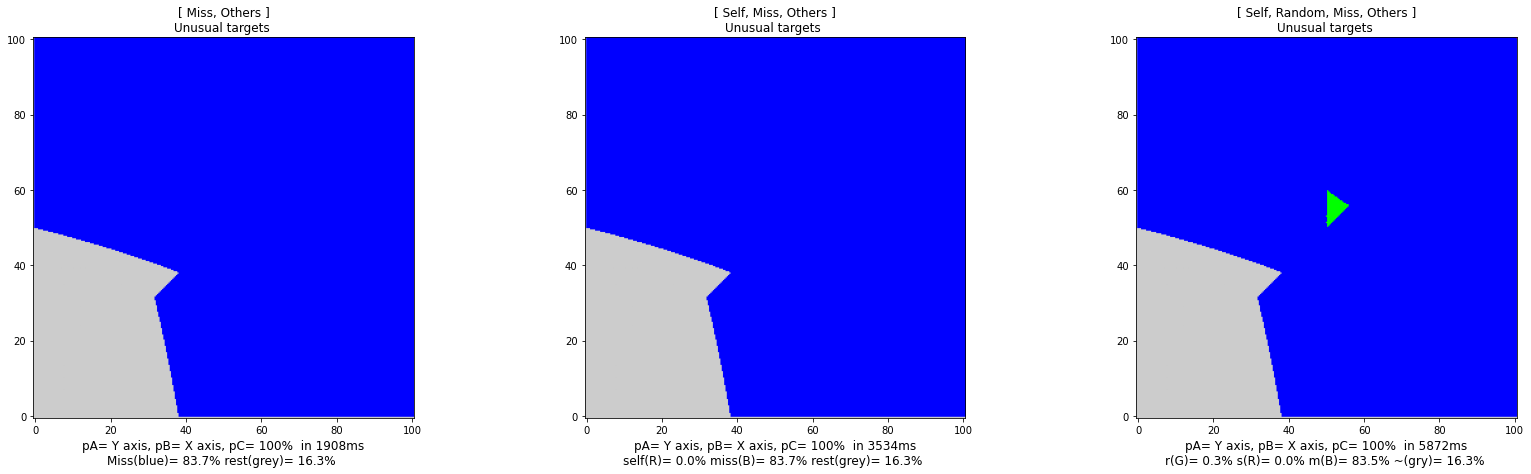

In [135]:
tst=  Test( search=[Others, Miss], AgtB=True, colors=['u'] )
tst1= tst._replace( title='[ Miss, Others ]' )  # just miss allowed
tst2= tst._replace( search=[Others, Miss, Self], title='[ Self, Miss, Others ]' ) # +self
tst3= tst._replace( search=[Others, Miss, Random, Self], title='[ Self, Random, Miss, Others ]' ) # +random
testAB( [tst1,tst2,tst3] )

If 'Self' was optimal target for any player at any point in above graphs, it would be red colored. Therefore above graphs demonstrate that 'Self targeting' is not optimal strategy at any point.

<a id='id_four_players'></a>
<h2>3.9 Four players - how different options influence four players version of truel</h2>

Original truel problem got its name from "three participants", and that is focus for majority of analyses in this document as well as majority of other/previous 'truel' documents. 

But python functions presented in this document are able to support more than just three players, either in calculation part ( where both mathematical calculation and simulation can support N>3 players and find both win probabilities and optimal targets for them ), and in visualization part ( where AB graphs can display it). So we can explore truel for more players, and in this section we will do so for "four players" truel ( **quadruel**? )

There are certain **limitations** of solvers used here, and those limitations are more pronounced for N>3 players:
* AB graphs do not support correctly 'Strongest' target options ( either in targets or search parameters )
* simulations do not support correctly finding 'Optimal' target for reduced number of players

While 'Strongest' option is rarely used anyway, and it would affect regular truel too, limitation for simulations is more affecting 'N>3' analysis when finding optimal targets. Namely, when simulation tries to find optimal target and it eliminate one player ( so it become truel instead of quadruel), it would have to now solve optimal target for that truel subcase - and that would be prohibitively slow to compute. For example, if we have 4 players with allowed targets [Others,Miss], it means each player have 3 target options and all 4 players have 3^4= 81 possible target combinations - so each simulation that search for optimal targets need to actually do 81 simulations, which already slows things down.  But if, in addition to that, we want to truly simulate for optimal targets, we would need to do same logic in every case when quadruel transforms to truel - we would need to do 3^3=27 full sub-simulations to determine which target was optimal for those truel cases.  Which would further slow down simulation 27 times. And all those slowdowns exponentially increase with larger number of allowed targets - so if [Others,Miss,Self,Random] is allowed, each player has 5 possible target choices and full simulation would need 5^4 * 5^3 sub-simulations, or 78 thousands(!) times longer execution than simple simulation with predefined targets.  

To reduce that slowdown impact, simulation procedures here are skipping that optimal target search when player is eliminated - they only check those 81 options when all players are still alive, but do not multiply by those 27 when reduced to truels. Instead, they assume players will target 'Strongest' opponent when reduced to truel. That is reasonable assumption, and it is shown in above sections that in most cases 'target Strongest' is optimal choice. But not in all cases, so this assumption result in simulation not being able to truly find optimal targets without increasing simulation time 27 times ( or 125 times when more targets are allowed ). This would exponentially increase for 5 players etc. Note that this limitation does not affect regular "truel" simulations, since there reduction is to 2 players, and for them it is always optimal to shoot each other.

Luckily, mathematical calculation functions from this document are able to find true optimal targets even for 4+ players - when number of players is reduced from 4 to 3, those functions are solving for optimal targets on every combination of those 3 remaining players also. 

Another question when analyzing 4+ players is **"what do we show on 2D AB graphs"** ? 

Even for truel it was obvious that if we use each axis for 'hit probability' range of one player ( so Y axis = 0%..100% hit chance of player A, and Y axis is same for player B ), we must fix hit probability of player C to some value ( default being to fix pHitC=100%, which match probability of player C to hit from original problem ).  Both solvers and visualizers here are able to support any pHitC, but fact remains that any AB graph will show picture for **entire** player A/B range and some **fixed** player C hit probability. For 4+ players that same logic is extended:   

2D AB graph will show results for fixed player C,D,E+ hit probabilities ( supplied in pHits parameter ) , while hit probabilities of players A and B will be on Y/X axis respectively.

So question is changed to:  what values to fix for hit probabilities of players C and D ?  Using original truel logic we can set pHitD=100%, but that leaves pHitC open.  
Below is example of winners with optimal probabilities in three cases with pHitD=100%: pHitC=25%, pHitC=50% and pHitC=100%, and last case has pHitC=phitD=50% :



( It has over 2 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

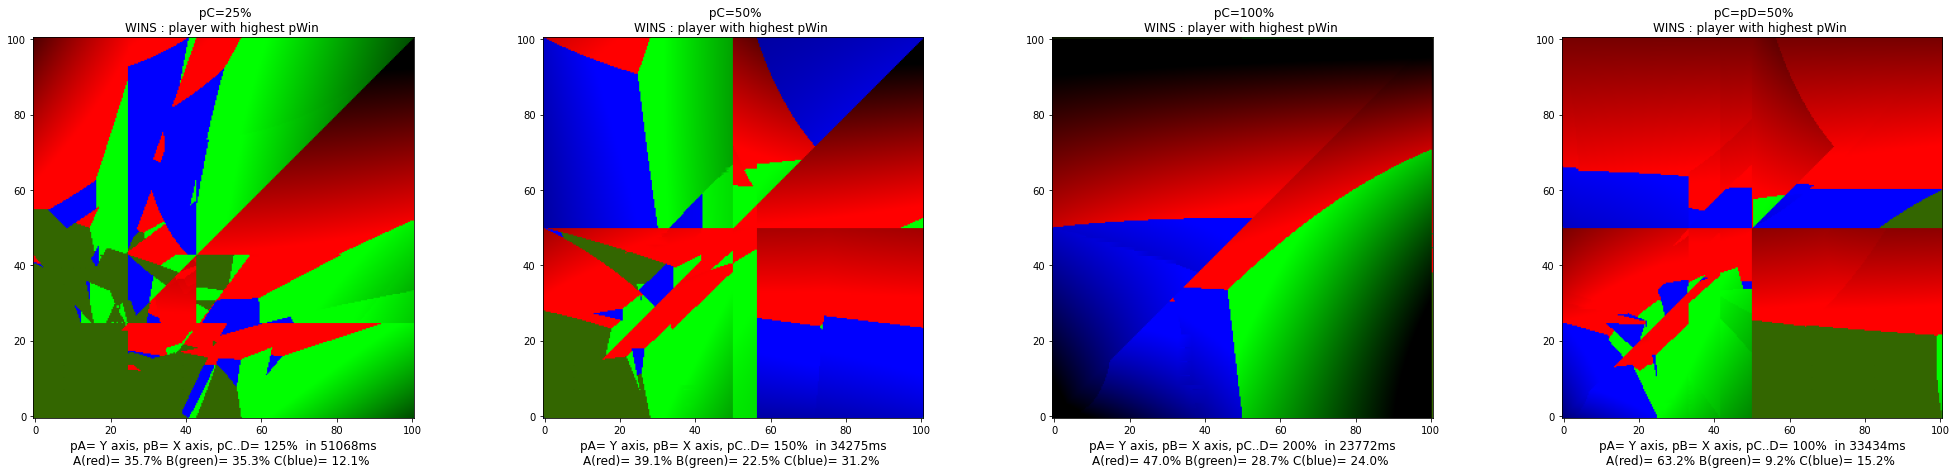

In [136]:
tst= Test( search=[Others, Miss])
tst1= tst._replace(pHits=[0,0,0.25,1], title=' pC=25%' )
tst2= tst._replace(pHits=[0,0,0.50,1], title=' pC=50%' ) 
tst3= tst._replace(pHits=[0,0,1.00,1], title=' pC=100%' )
tst4= tst._replace(pHits=[0,0,0.5,0.5], title=' pC=pD=50%' )
testAB([tst1,tst2,tst3,tst4], cache= cacheTypeSlow)

Those looks quite differently, which is not so surprising considering that they represent different hit probabilities of 2 out of 4 players. But if one should be selected as 'representative', it should probably be 2nd one with pC=50% and pD=100% hit chances.


**'Miss' as optimal target**

Lets see usual graphs ( with win orders, unusual targets for any player and unusual targets for winners ) in situation when we only allow classical [Others, Miss] targets:

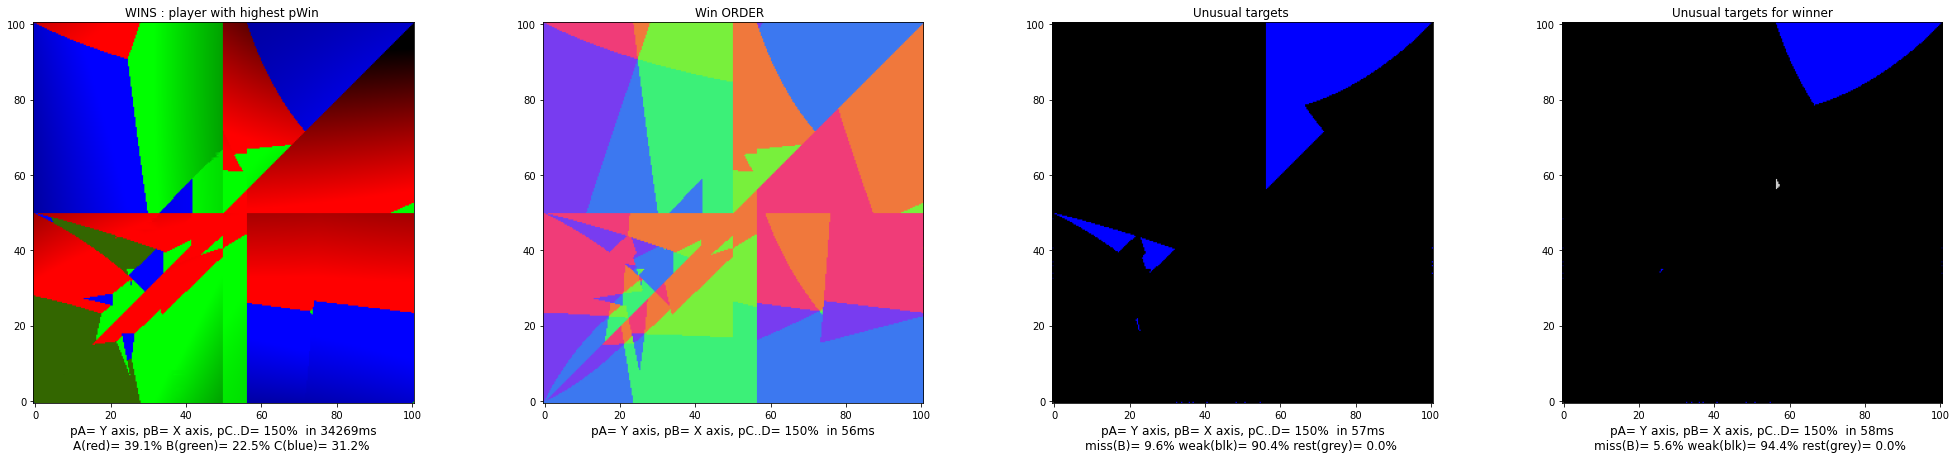

In [137]:
testAB( Test(pHits=[0,0,0.50,1], search=[Others, Miss], colors=['w','o','u','uw'])) 

We can see that 'Miss' is indeed optimal target in around 10% of the cases for 'at least one player' ( 3rd picture above) , and even in noticeable 5.6% of cases for 'winners' (4th picture). It is interesting that 'Miss' is optimal in smaller percentage of cases than for classic truel (N=3).

But since we mentioned that selection of fixed pC probabilities can significantly change results, lets see how often is 'Miss' optimal target for winners in different pHitC scenarios :

( It has over 2 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

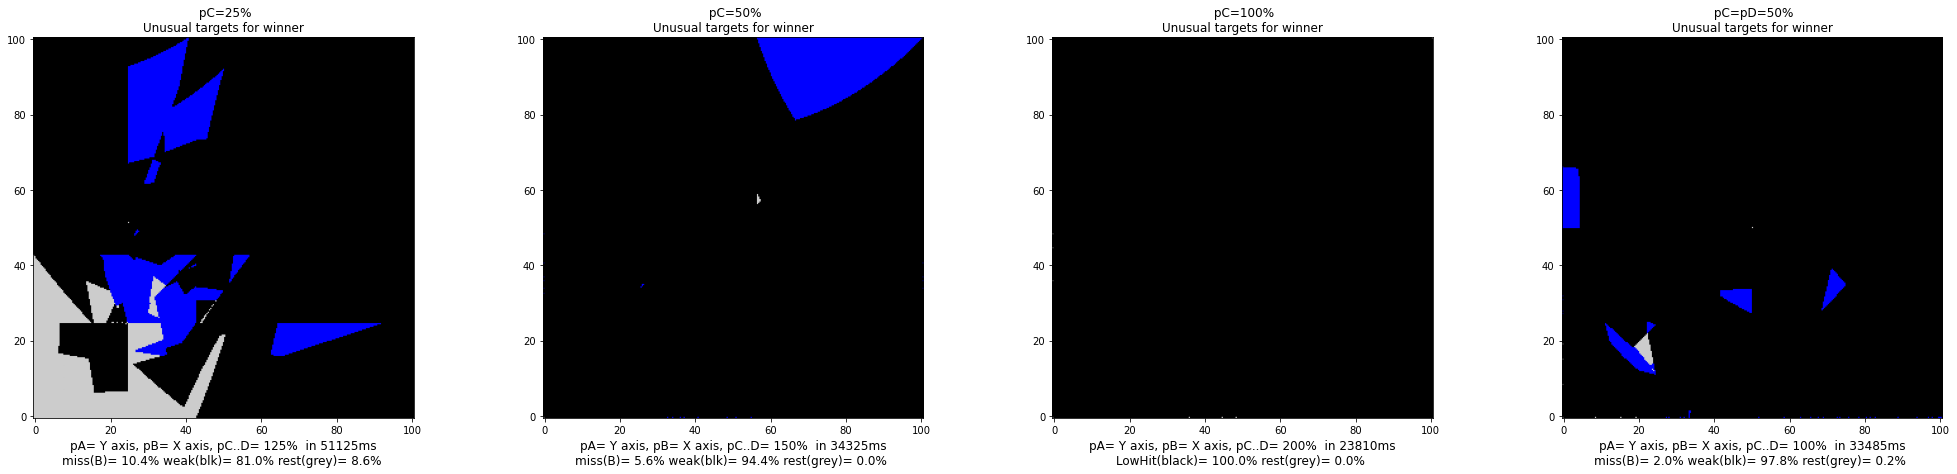

In [138]:
tst= Test(colors=['uw'], search=[Others, Miss])
tst1= tst._replace(pHits=[0,0,0.25,1], title=' pC=25%' ) 
tst2= tst._replace(pHits=[0,0,0.50,1], title=' pC=50%' ) 
tst3= tst._replace(pHits=[0,0,1.00,1], title=' pC=100%' ) 
tst4= tst._replace(pHits=[0,0,0.5,0.5], title=' pC=pD=50%' ) 
testAB( [tst1,tst2,tst3,tst4], cache= cacheTypeSlow )

It shows that 'Miss' is optimal target for winners most often for lower pHitC probabilities, so more in pC=25% than pC=50%. But important thing is that Miss can be optimal targen not only for some players, but also for winners - in certain cases.

General observation is that **'Miss' is often optimal target** both for winners and other players.

<br><br>

**'Random' as optimal target**



If we allow 'Random' as target option in 4 player quadruel, which by default means 'equal Random', we get results shown below :

( It has almost 2 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

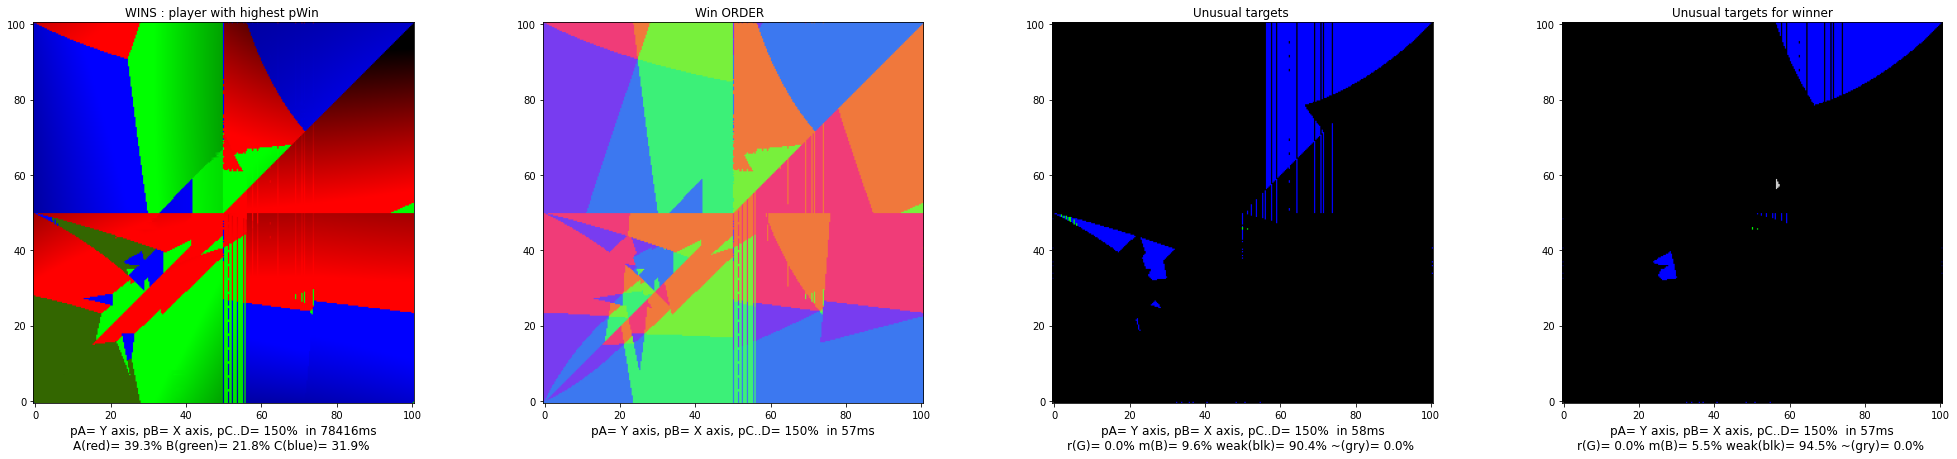

In [139]:
testAB( Test(pHits=[0,0,0.50,1], search=[Others, Miss, Random], colors=['w','o','u','uw']), cache= cacheTypeSlow) 

Above graphs indicate that there are no cases where 'equal Random' is optimal target in quadruel. That single green spot is likely boundary exception ( case where selecting random or some other choice would result in [equal win probabilities](#id_same_pwin) ).

We can also check if '**equal Random**' will be optimal target for any player in different pHitC and pHitD scenarios :

( It has over 10 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

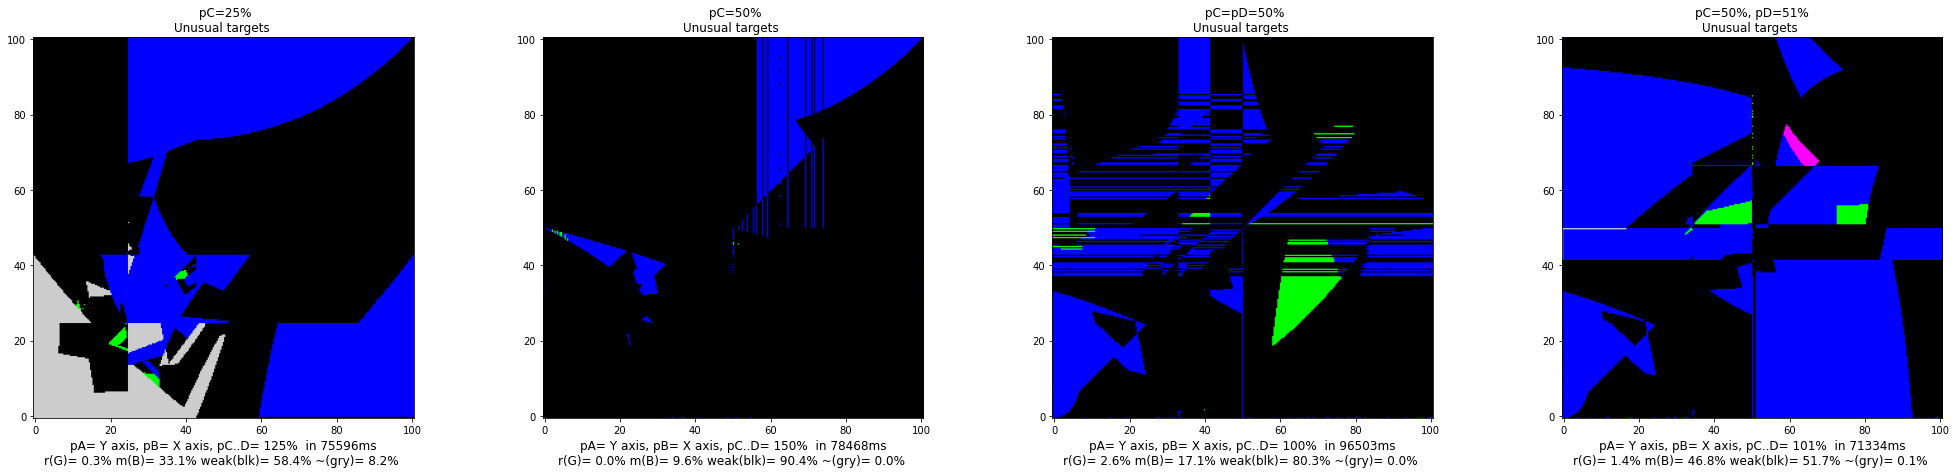

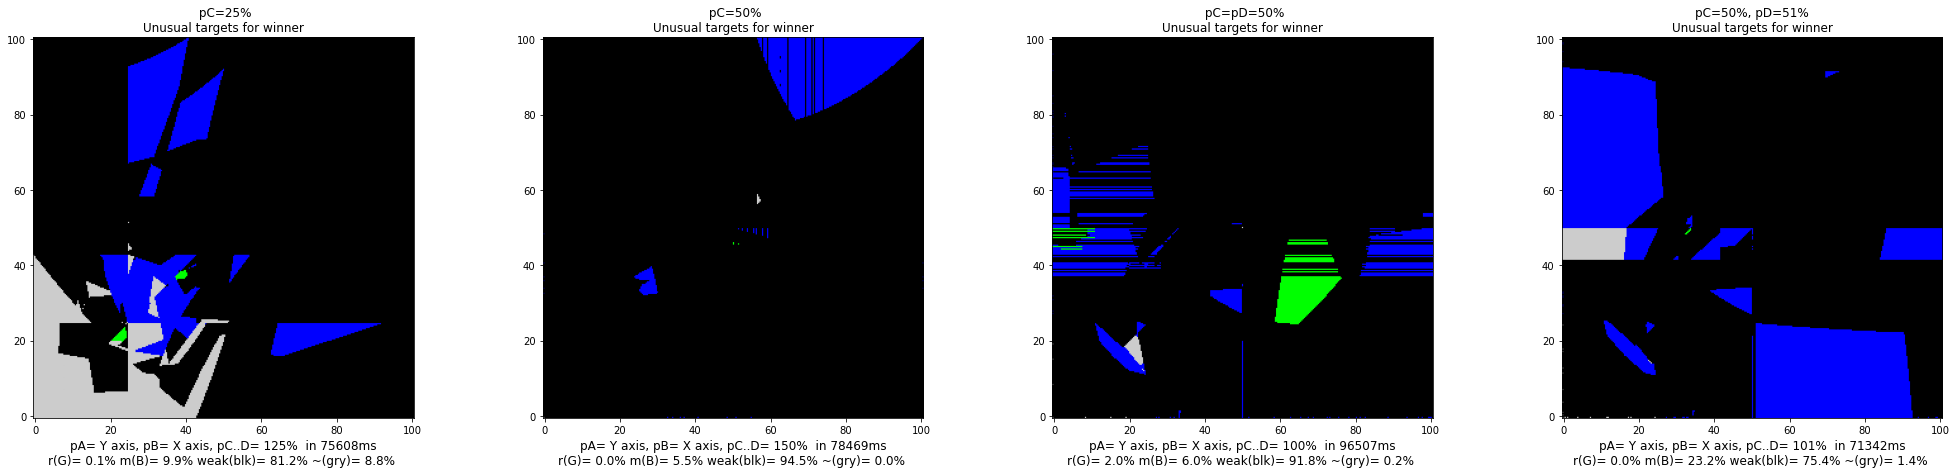

In [140]:
tst= Test(colors=['u'], search=[Others, Miss,Random])
tst1= tst._replace(pHits=[0,0,0.25,1], title=' pC=25%' ) 
tst3= tst._replace(pHits=[0,0,0.5,1], title=' pC=50%' ) 
tst4= tst._replace(pHits=[0,0,0.5,0.5], title=' pC=pD=50%' ) 
tst5= tst._replace(pHits=[0,0,0.5,0.51], title='pC=50%, pD=51%' ) 
allTests= [tst1,tst3,tst4,tst5]
testAB( allTests, cache= cacheTypeSlow) # unusual targets for any player, 1st row
testAB( Replace(allTests, colors=['uw']), cache= cacheTypeSlow) # unusual targets for winners, 2nd row

Above graph demonstrate that 'equal Random' **can** be an optimal target in some cases for 4-player quadruel - for example, in noticeable number of cases when pHitC= pHitD=50%. But since 'Random' can often be an option in edge cases ( when one player get [same win chances](#id_same_pwin) if he select different targets), and since those edge cases are more probable when pC equals pD, last picture demonstrate difference when pD at 51% is just slightly larger than pC at 50%. Even there, 'equal Random' is optimal target sometimes, but in smaller number of cases and not for winners.

When looking only at optimall targets for winners, 'equal Random' appears less often, as seen on 2nd row above. If we ignore pC=pD=50% case, due to high likelihood of edge cases, we see that 'equal Random' is optimal choice only for very small number of cases for winners. 
<br><br><br>

Graph below shows situation if we allow "**unequal Random**" , limited to  optRndLevel=2, meaning all random distributions in 50% steps ( eg, [50% 0 50%],[0 0 50%],[100% 0 0], [0 0 0]...) :

( It has almost 2 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

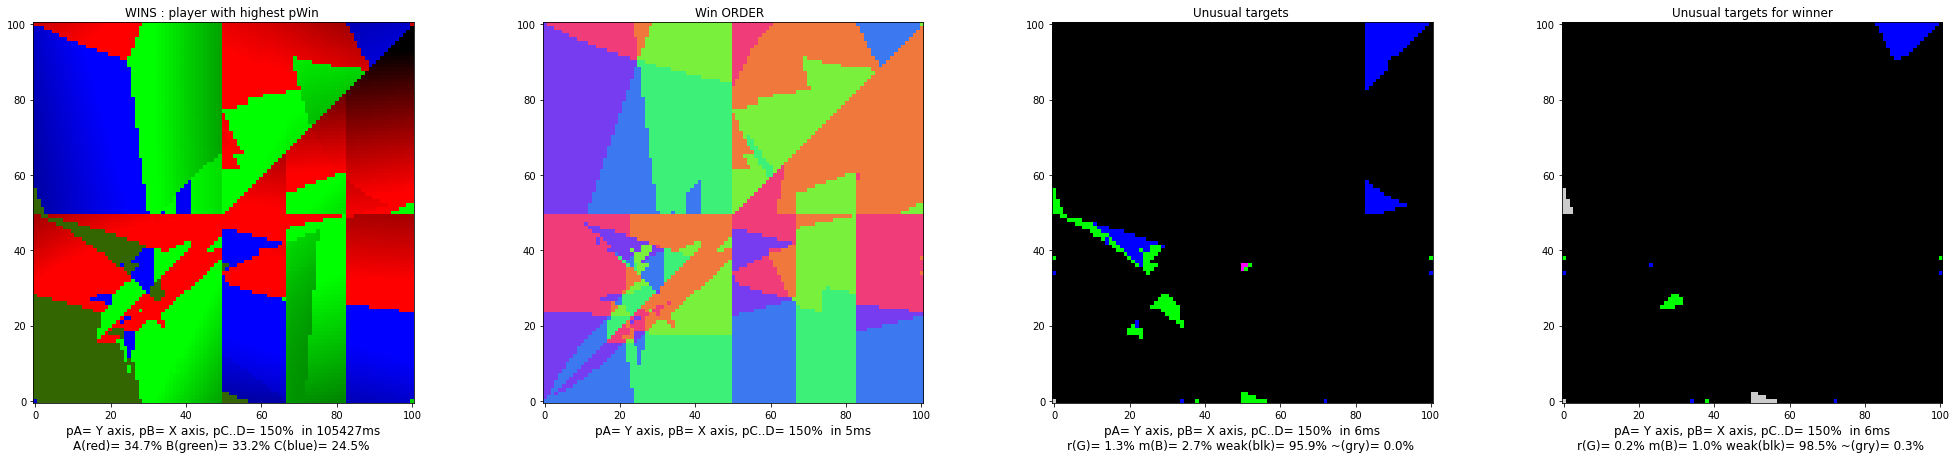

In [141]:
testAB( Test(pHits=[0,0,0.50,1], points=100, search=[Others, Miss, Random], optRndLevel=[2,2,2,2], colors=['w','o','u','uw']), cache= cacheTypeSlow ) 

While above graph is limited only to 2 random levels (50% steps), previous scenarios demonstrated that even such lower resolutions are good to indicate areas where 'Random' is optimal target.
We can see that 'unequal Random' is optimal target for at least some players in certain cases ( 3rd image above), but it is very rarely optimal target for winners - in few edge cases shown as green dots on 4th image. 

To further check if winners can use 'unequal Random' at some points, for different pHitC and pHitD and with slightly higher random granularity ( in 1/3 steps ), we can again use 'uw' colot option for 'unusual targets for winners'. In order to improve performance ( since optRndLevel=3 will significantly slow things down), images are generated in transposed order compared to those for 'equal Random' - meaning that rows represent hit percentage choice, while column represent image type ( unusual targets for all, for winners...). That way calculations are done only once for all images in one row, so we could include win orders and win percentage images at no additional computational cost :

( it has over 10 min execution, so set [SkipSlowParts](#id_skipSlow) to enable/disable calculation )

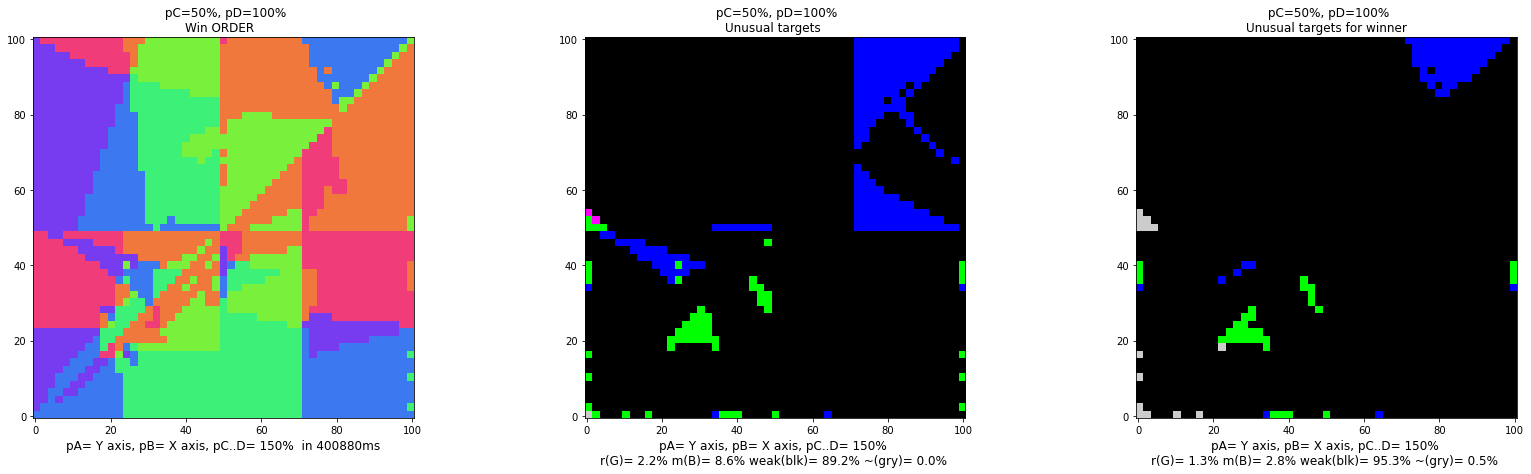

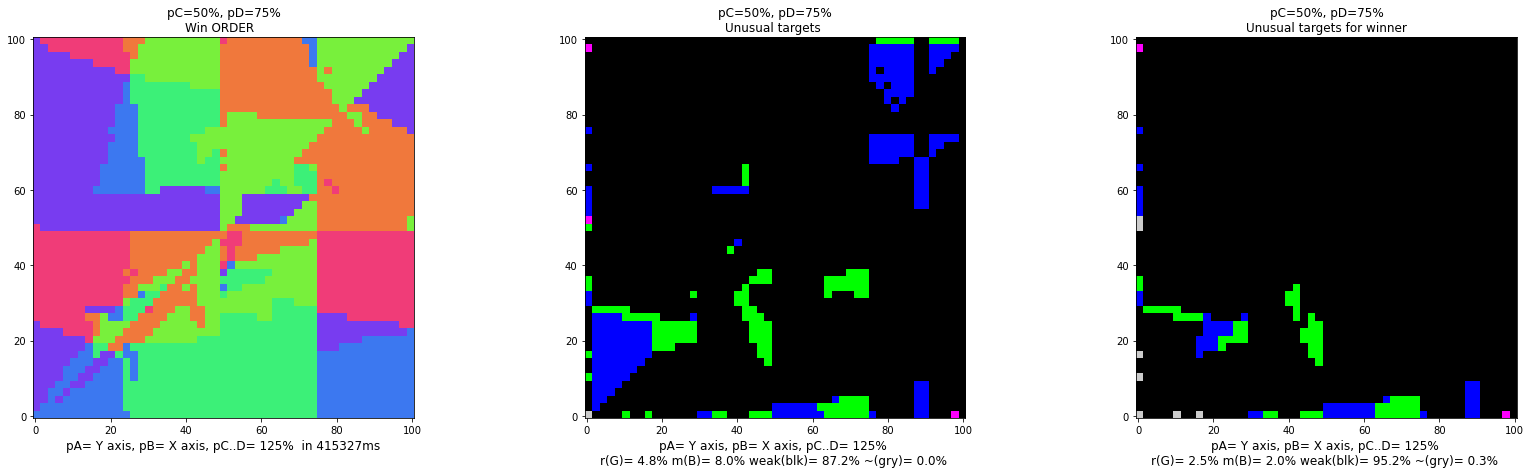

In [142]:
tst= Test(colors=['o','u','uw'], search=[Others, Miss,Random], points=50, optRndLevel=[3,3,3,3])
testAB( tst._replace(pHits=[0,0,0.5,1], title=' pC=50%, pD=100%' ), cache= cacheTypeSlow) 
testAB( tst._replace(pHits=[0,0,0.5,0.75], title='pC=50%, pD=75%' ), cache= cacheTypeSlow) 

First thing to note on first row in above images ( for pC=50%, pD=100% , with random level 3 ) is that result looks similar to previous graphs with random level 2 - unusual targets appear in roughly same area. But higher granularity of random levels appears to slightly increase number of unusual targets, and number of cases where 'unequal Random' is optimal target - especially for winners.
<br><br>
Conclusions regarding **'Random' as optimal target in 4-player quadruel**:
* 'equal Random' is optimal target in rare cases for at least some players, and in very rare cases also for winners
* 'Random' is optimal target more often in edge cases when hit probabilities are same for multiple players ( but in such cases it was not only optimal target )
* 'unequal Random' can be optimal target even for some winners, and can be optimal for 'losers' in more cases than 'equal Random'
* 'unequal Random' is more often optimal for higher random granularity ( larger optRndLevel levels )
* in general, 'Random' is less often optimal target for 4-players quadruel, compared to 3-ptruel

<br><br>

<a id='id_same_pwin'></a>
<h2>3.10 Selecting optimal targets when multiple targets result in same win probability</h2>

Finding optimal targets out of all possible targets is not always simple task, as it was explained in section [1.3 Optimal targets search](#id_optimal_targets), but it is mostly straightforward. But there is one question that was not mentioned in details in that section, and which can influence optimal result:

**What target should player select if not just one, but several of his target choices result in same best win probability for him ?**

This question does not have such straightforward answer as rest of optimal search, and it could be almost subjective what people would choose. Some example approaches are:
1) select most 'simple' target ( so single target > miss > random ) and if equally simple prefer to target player with higher hit probability [Default]
2) always prefer to target higher hit probability player ( so Miss is last )
3) prefer to target player with highest win chance ( as opposed to highest hit chance )
4) single player > random > miss, if same A>B>C...


Solvers in this document support all those options from above, through **ifEQ** parameter ( with same values as above , and default value +1 ). Default option prefers 'simplest' targets, and when both targets are equally simple ( for example, player A gets same win probability if he target player B or player C, and both B or C are equally 'simple' targets - without Random or Miss ), then prefer to target player with higher hit probability ( so in previous example, target C if player C has higher hit chance ).

Situations where this parameter influence optimal solutions are **rare**, and mostly occur on boundary/edge cases where two or more players have same hit probabilities - so on standard AB graphs, that would be mostly diagonal where pA ~ pB. But if we set hit probability for player C lower, at 50% for example, then edge cases would also be horizontal line at pA=50%, and vertical line at pB=50%.  It is also possible to get that rare edge case for other hit probabilities.  On AB graphs, such egde cases usually appear like "glitches" - individual pixels or lines that have different result color from surrounding areas.  Note that they are not errors - those are actual optimal results, at those positions and under selected ifEQ interpretation.

Probably best case to compare how different ifEQ choices could change optimal results is for 4-player cases: not only due to larger complexity and number of players, but also because there are more cases when two players have same hit probabilities, and more chances that multiple players will have same win probabilities. For example, we can look at case presented in 4-players section, where player C hit chance was fixed at 50% and player D hit chance was fixed at 100% - and, in order to make those edge cases more visible, with lower resolution of 100x100 points:


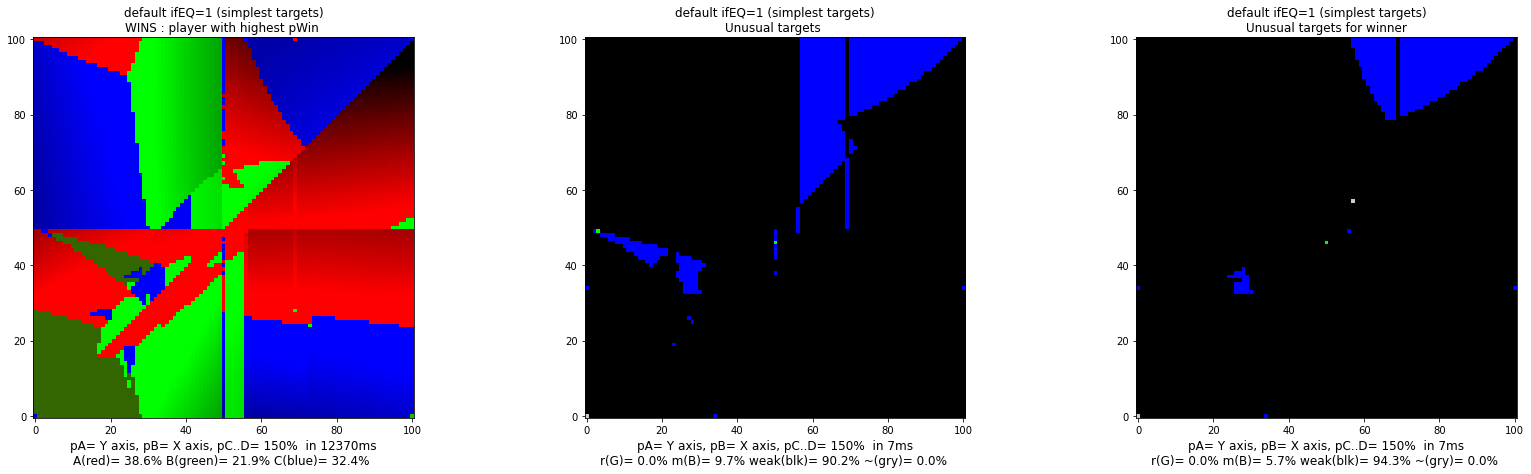

In [143]:
testAB( Test(pHits=[0,0,0.50,1], points=100,search=[Others, Miss, Random], colors=['w','u','uw'], title="default ifEQ=1 (simplest targets)")) 

We can see 'glitches' near horizontal/vertical middle lines, which were expected since pC=50% and those lines are places where either pA ~ pC (horizontal middle line) or where pB~pC (vertical middle line). But we can also see few edge cases at other positions, for example single vertical line in blue "unusual targets" graph.

If we do same graph, but with #2 option for ifEQ (always prefer to target higher hit probability player), we get results from below:

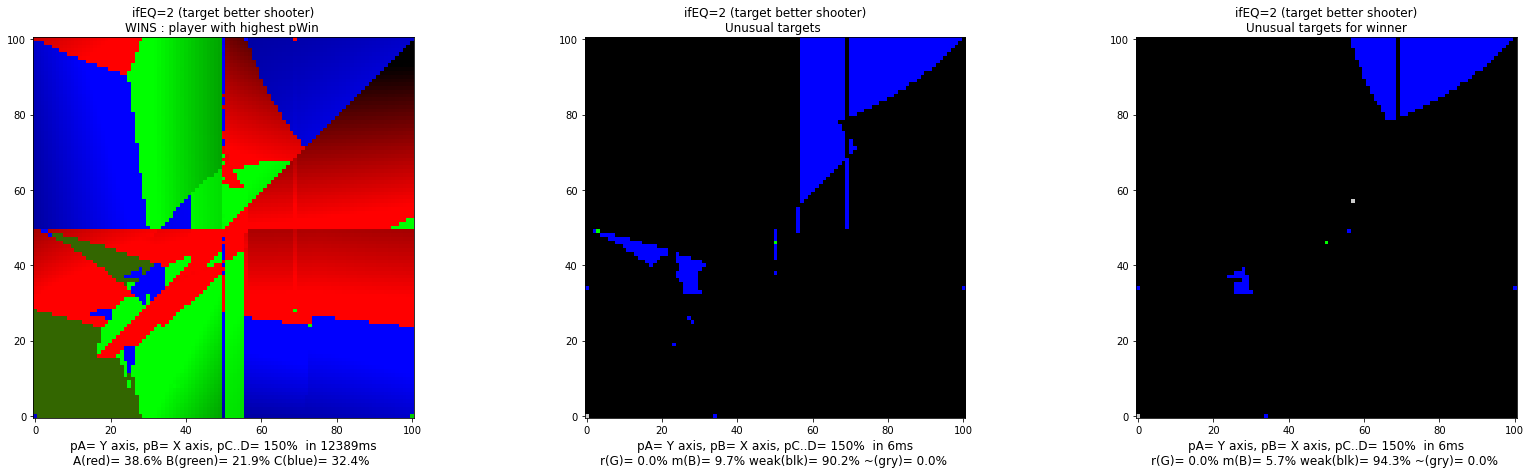

In [144]:
testAB( Test(pHits=[0,0,0.50,1], points=100,search=[Others, Miss, Random], colors=['w','u','uw'], title="ifEQ=2 (target better shooter)", ifEQ=2  )) 

Above graph looks practically identical to previous (default) option, which confirms that those edge cases are actual optimal solutions under different ifEQ assumptions.

Below is analysis with #3 option for ifEQ (prefer to target player with highest win chance):

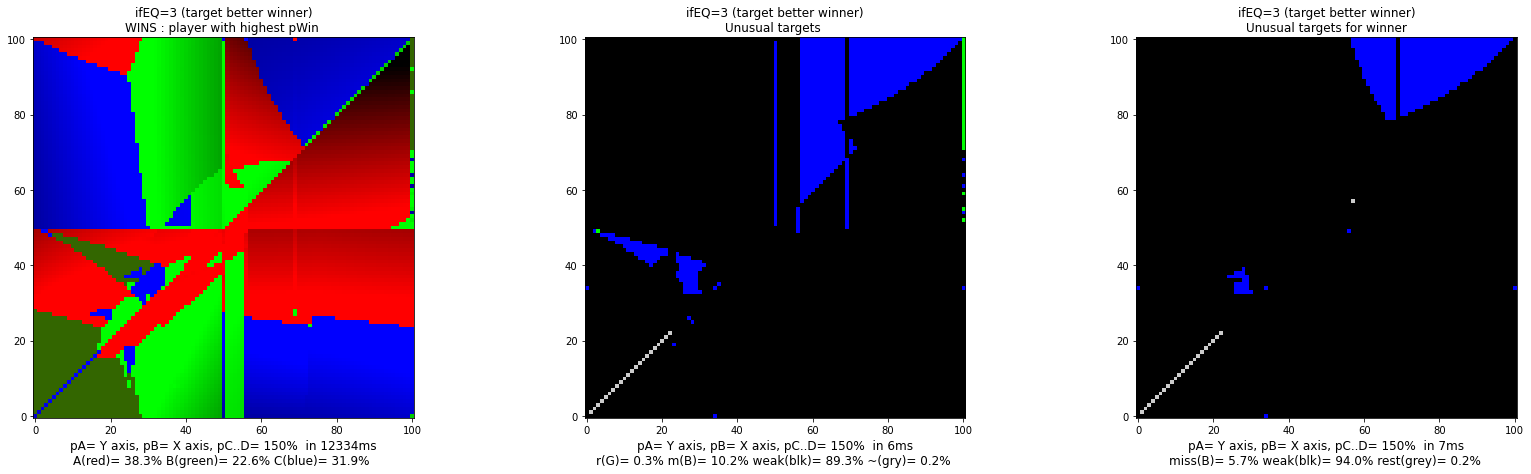

In [145]:
testAB( Test(pHits=[0,0,0.50,1], points=100,search=[Others, Miss, Random], colors=['w','u','uw'], title="ifEQ=3 (target better winner)", ifEQ=3  )) 

This time we can see more edge cases ( more "glitches")- prefering to target players with higher win chance results in more edge cases. This can be explained by fact that targeting those players reduce their win probability and make win probabilities of all players closer in general. And that could increase chance for edge cases because it increase chance that two different targets result in same win probability.

Below is analysis for ifEQ=4 case. This ifEQ option prefers targets with highest probability, so single target before randoms before Miss - and if two targets have same probability, then prefers players in shooting order (A>B>C...):

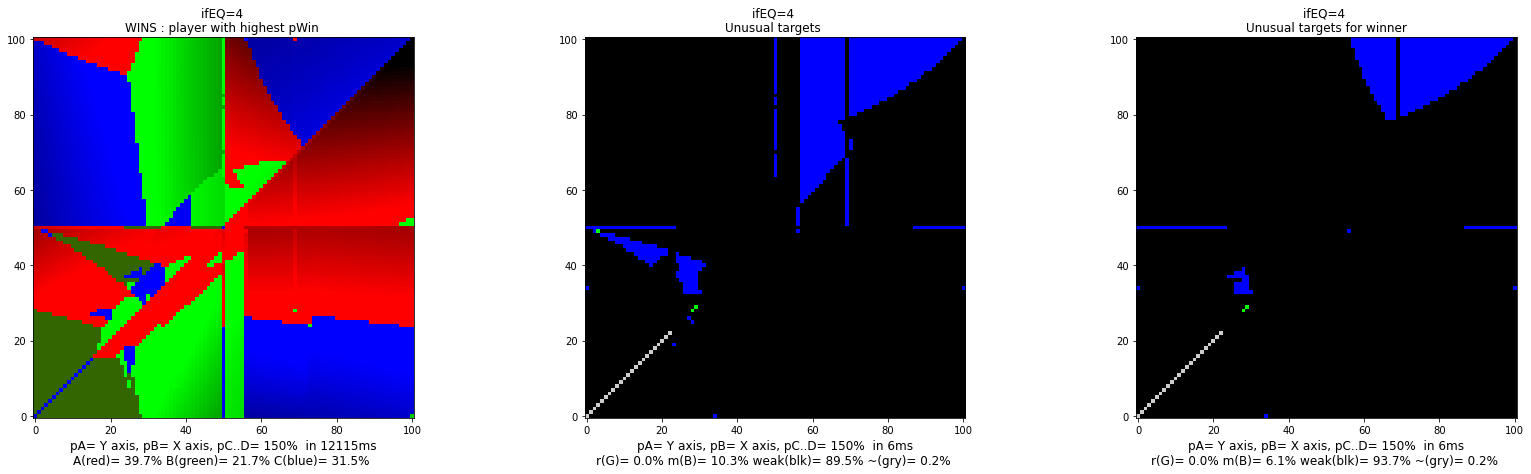

In [146]:
testAB( Test(pHits=[0,0,0.50,1], points=100,search=[Others, Miss, Random], colors=['w','u','uw'], title="ifEQ=4 ", ifEQ=4  )) 

It looks very similar to ifEQ=3 case , only with slightly more edge cases ( mostly green dots, indicating 'Random' as optimal target ) on diagonal and around pA ~ 50% (blue line indicating Miss as optimal targets on "unusual targets" images). But it also has slightly less glitches on upper right edge ( where ifEQ=3 has green line indicating 'Random' as optimal target). 

In general, ifEQ options #1 (default) and #2 look similar and exibit least edge cases, while ifEQ options #3 and #4 have only slightly more edge cases - but overall, edge cases ("glitches") that are changeable depending on ifEQ parameter are small minority, and most glitches visible on graphs persist across all interpretations of "what to select if two targets lead to same win probability" question. 

In [147]:
from datetime import datetime
t1end= datetime.now()
print("Finished calculation at ", t1end, ". Duration = ",(t1end-t0start))

Finished calculation at  2021-04-29 00:06:47.151392 . Duration =  0:32:07.342168


<br><br><br>

<a id='id_copyright'></a>
<b><h2>Copyright notice</h2></b>

Copyright (c) 2021 <i>gmnenad</i>

This document or its elements, including source code and Truel analysis results, are free to use and redistribute - as long as this article at [gmnenad.com](#https://gmnenad.com/wp-content/uploads/2021/04/Truel.html) is referenced when appropriate.